# Reproducing the Experiment in "Prediction of Pedestrian Speed with Artificial Neural Networks" by Tordeux et al.

In [1]:
# Enable these if automatic reloading of modules is wanted

# Load extension for automatic reload of modules
%load_ext autoreload
# Enable autoreload for all modules
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import inspect

import torch
from torch.utils.data import DataLoader
import logging
import pytorch_lightning as pl
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
import tensorboard
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import KFold

import preprocessing
import plotting
import pedestrian_dataset
import pedestrian_net
from weidmann_method import *

## Tensorboard

Extension for visualizing the training results.
Should only be loaded once, otherwise there is probably an error message.

To start, run `tensorboard --logdir=dir --port 6006` in a terminal or run the following cell.

In [62]:
%load_ext tensorboard
%tensorboard --logdir lightning_logs --port 6011

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [4]:
%reload_ext tensorboard

## Logging

I used Logging to print messages.
If more messages are welcome, use the logging level `logging.INFO` or even `logging.DEBUG`.
If not, use `logging.WARNING`.

In [5]:
# Set Logging Level
logger_format = '%(levelname)s - %(funcName)s \t%(message)s'
logger_level = logging.WARNING
logging.basicConfig(level=logger_level, format=logger_format)

In [6]:
# Set a torch seed
torch.manual_seed(1234)

## Preprocessing and Loading the Dataset

The different files of data in the format
(`PedID FrameID X Y Z`)
are loaded and converted into the following dictionary format:

`distances` | `speeds`
-|-
Input of our neural network. Array of size $2k+1$ containing the median speed of the $k$ nearest neighbors as the first element and the relative $x$- and $y$-positions of the $k$ nearest neighbors in the following pattern afterwards: $x_1$, $y_1$, $x_2$, $y_2$, ... | Truth value for our neural network. The speed that the pedestrian had in that frame.

To load a list of files, the method `pedestrian_dataset.create_dataset()` is used.
As its first parameter it either takes a list of data files that it should load
or a `pedestrian_dataset.PedestrianDataType` value,
which can be either `BOTTLENECK`, which loads all bottleneck files,
`CORRIDOR`, which loads all corridor files,
or `ALL`, which loads all files.

In [7]:
# Creating datasets with only the smallest corridor scenario with 30 participants
c_015_path = "./Data/Corridor_Data/ug-180-030.txt"
# Note: even when only loading one dataset, it has to be given in a list
c_015_train_val_datasets, c_015_test_dataset = pedestrian_dataset.create_dataset([c_015_path])

# Print the first item from the first train/val dataset part
print(c_015_train_val_datasets[0][0])

{'distances': array([ 296.80893951,   36.1585    ,  -91.69      ,   76.8931    ,
         62.0273    ,   -2.372     ,  201.1667    ,  -21.5438    ,
       -241.436     ,   29.8531    , -262.229     ,   32.8202    ,
        295.624     ,  -18.6053    ,  316.108     ,  -26.2509    ,
        437.719     ,   43.2941    ,  445.954     ,   -0.6295    ,
        559.384     ]), 'speed': 6.112364455756874}


In [8]:
batch_size = 16

# Create a PyTorch dataloader with the dataset

# TODO: I don't know how to do cross validation, so we combine the first 4 train/val datasets
#   to build the train dataset and use the last train/val dataset as the val dataset
#   Maybe we just have to do this everytime (and switch it up)? Could be, but not sure
c_015_temp_train_dataset = torch.utils.data.ConcatDataset(c_015_train_val_datasets[:4])
c_015_temp_val_dataset = c_015_train_val_datasets[4]

c_015_train_loader = DataLoader(c_015_temp_train_dataset, batch_size=batch_size, drop_last=True)
c_015_val_loader = DataLoader(c_015_temp_train_dataset, batch_size=batch_size, drop_last=False)

c_015_test_loader = DataLoader(c_015_test_dataset, batch_size=batch_size, drop_last=False)

# # Print the first value given by the train loader
# for item in c_015_train_loader:
#     print(item)
#     break  # break after printing the first item

In [9]:
# Creating datasets with all scenarios loaded
all_train_val_datasets, all_test_dataset = pedestrian_dataset.create_dataset(
    pedestrian_dataset.PedestrianDataType.ALL
)

# Print the first item from the first train/val dataset part
print(all_train_val_datasets[0][0])

{'distances': array([ 83.28914988, -32.428     ,  24.169     ,  37.9846    ,
        38.714     ,  -2.5528    , -57.585     ,   4.0326    ,
        69.008     ,  81.5544    ,   6.506     , -71.6767    ,
       -54.426     ,  49.6994    , -84.303     , -57.71222   ,
        80.09      ,  86.0264    , -55.428     ,  80.5664    ,
        75.733     ]), 'speed': 2.5783409394414765}


In [10]:
batch_size = 10000

# Create a PyTorch dataloader with the dataset

# TODO: I don't know how to do cross validation, so we combine the first 4 train/val datasets
#   to build the train dataset and use the last train/val dataset as the val dataset
#   Maybe we just have to do this everytime (and switch it up)? Could be, but not sure
all_temp_train_dataset = torch.utils.data.ConcatDataset(all_train_val_datasets[:4])
all_temp_val_dataset = all_train_val_datasets[4]

all_train_loader = DataLoader(all_temp_train_dataset, batch_size=batch_size, drop_last=True)
all_val_loader = DataLoader(all_temp_train_dataset, batch_size=batch_size, drop_last=False)

all_test_loader = DataLoader(all_test_dataset, batch_size=batch_size, drop_last=False)

# # Currently Disabled because for batch_size=16 this get's large
# # Print the first value given by the train loader
# for item in all_train_loader:
#     print(item)
#     break  # break after printing the first item

In [11]:
# Create normalized DataLoaders

normalized_train_loader = DataLoader(preprocessing.normalize_data(all_temp_train_dataset), batch_size=batch_size, drop_last=True)
normalized_val_loader = DataLoader(preprocessing.normalize_data(all_temp_val_dataset), batch_size=batch_size, drop_last=True)
normalized_test_loader = DataLoader(preprocessing.normalize_data(all_test_dataset), batch_size=batch_size, drop_last=False)

In [12]:
print(normalized_train_loader)

## Implementing and Training the Model

Now we need to define our model.

### Model 1 - Weidmann Method Fundamental Diagram

In [65]:
# Load the datasets with bottleneck and corridor data

bottleneck_train_val_dataset, bottleneck_test_dataset = pedestrian_dataset.create_dataset(pedestrian_dataset.PedestrianDataType.BOTTLENECK)
corridor_train_val_dataset, corridor_test_dataset = pedestrian_dataset.create_dataset(pedestrian_dataset.PedestrianDataType.CORRIDOR)
all_train_val_dataset, all_test_dataset = pedestrian_dataset.create_dataset(pedestrian_dataset.PedestrianDataType.ALL)

In [66]:
# See the histogram of bottleneck and corridor data for mean spacing and speed values
b_train_weidmann_x, b_train_weidmann_y, b_test_weidmann_x, b_test_weidmann_y = preprocessing.prepare_weidmann_data(bottleneck_train_val_dataset , bottleneck_test_dataset)
c_train_weidmann_x, c_train_weidmann_y, c_test_weidmann_x, c_test_weidmann_y = preprocessing.prepare_weidmann_data(corridor_train_val_dataset , corridor_test_dataset)

# Concatenate the train and test data to get the full dataset in order to plot the histogram
b_dataset_mean_spacing = b_train_weidmann_x + b_test_weidmann_x
b_dataset_speed = b_train_weidmann_y + b_test_weidmann_y
c_dataset_mean_spacing = c_train_weidmann_x + c_test_weidmann_x
c_dataset_speed = c_train_weidmann_y + c_test_weidmann_y

# Plot the histograms
plotting.plot_histogram(b_dataset_mean_spacing, xlabel='Mean spacing',  title='Bottleneck Mean Spacing Histogram')
plotting.plot_histogram(b_dataset_speed, xlabel='Speed',  title='Bottleneck Speed Histogram')

plotting.plot_histogram(c_dataset_mean_spacing, xlabel='Mean spacing',  title='Corridor Mean Spacing Histogram')
plotting.plot_histogram(c_dataset_speed, xlabel='Speed',  title='Corridor Speed Histogram')

ZeroDivisionError: float division by zero

In [67]:
# Adjust the experiment datasets wıth different combinations of bottleneck and corridor data
load_dataset = {'B/B': [bottleneck_train_val_dataset, bottleneck_test_dataset],
                'R/R': [corridor_train_val_dataset, corridor_test_dataset ], 
                'B/R': [bottleneck_train_val_dataset, corridor_test_dataset],
                'R/B': [corridor_train_val_dataset, bottleneck_test_dataset],
                'R+B/R': [all_train_val_dataset, corridor_test_dataset], 
                'R+B/B': [all_train_val_dataset, bottleneck_test_dataset],
                'R+B/R+B': [all_train_val_dataset, all_test_dataset]}

# Set the initial guess for the Weidmann method
initial_guess = [1, 1, 1]

mse_dic = {}
for i in load_dataset:
    # Prepare the data for the Weidmann method
    train_weidmann_x, train_weidmann_y, test_weidmann_x, test_weidmann_y = preprocessing.prepare_weidmann_data(load_dataset[i][0], load_dataset[i][1])

    # Use the Weidmann method to fit the data and get the optimized parameters and the mean squared error (mse)
    optimized_parameters, mse, y_fit = use_weidmann_method(train_weidmann_x, train_weidmann_y, test_weidmann_x, test_weidmann_y, initial_guess=initial_guess)
    #print("Optimized parameters: ", optimized_parameters)
    # Plot the results for test data 
    curve_model = np.arange(min(test_weidmann_x), max(test_weidmann_x), 0.01)
    curve_pred = weidmann_equation(curve_model, *optimized_parameters)
    plot_fd_curve(test_weidmann_x, test_weidmann_y, curve_model, curve_pred, title=i)
    mse_dic[i] = mse

ZeroDivisionError: float division by zero

In [ ]:
# Plot MSE results as a line plot
plt.figure(figsize=(10, 5))
plt.ylim(ymin=0, ymax=0.1)
plt.plot(list(mse_dic.keys()), list(mse_dic.values()))
plt.title('MSE for different scenarios')
plt.xlabel('Scenario')
plt.ylabel('MSE')
plt.show()

### Model 2 - Artificial Neural Networks

### Set up hyper parameters

In [26]:
max_epochs = 20
k = 10
hidden_size = 3
learning_rate = 1e-3
optimizer = torch.optim.Adam

# Use GPU if available
if torch.cuda.is_available():
    device = torch.device('cuda')
    print("GPU is available.")
else:
    device = torch.device('cpu')
    print("CPU will be used.")

# define an early stopping callback
early_stop_callback = EarlyStopping(monitor="val_loss", mode='min', patience=1000)

GPU is available.


#### Combine all datasets to prepare for K-fold training

In [27]:
# combine all your data into one dataset
dataset = preprocessing.normalize_data(torch.utils.data.ConcatDataset(all_train_val_datasets))

#### Set up all models with different layers

In [28]:
all_models = [[1], [2], [3], [4,2], [5,2], [5,3], [6,3], [10,4]]

#### Initialize the KFold class

In [30]:
k_folds = 10
kfold = KFold(n_splits=k_folds, shuffle=True)

### Train for all models and all KFolds and save mean values for each model

In [31]:
mean_train_losses = []
mean_test_losses = []

for layer_sizes in all_models:
    train_losses = []
    test_losses = []
    
    for fold, (train_ids, val_ids) in enumerate(kfold.split(dataset)):  
        print(f"FOLD {fold}")
        print("--------------------------------")

        # Sample elements randomly from a given list of ids, with replacement.
        train_subsampler = torch.utils.data.sampler.WeightedRandomSampler(torch.ones_like(torch.from_numpy(train_ids)), len(train_ids), replacement=True)

        val_subsampler = torch.utils.data.SubsetRandomSampler(val_ids)

        # Define data loaders for training and testing data in this fold
        trainloader = torch.utils.data.DataLoader(
                          dataset, 
                          batch_size=10000, sampler=train_subsampler)  
        valloader = torch.utils.data.DataLoader(
                          dataset,
                          batch_size=10000, sampler=val_subsampler)

        # Init the neural network
        network = pedestrian_net.PedestrianNet(k=k,
                                               hidden_sizes=layer_sizes,
                                               learning_rate=learning_rate,
                                               optimizer=optimizer)
        network.to(device)

        # Initialize a trainer
        trainer = pl.Trainer(
            max_epochs=max_epochs,
            devices='auto',
            accelerator='gpu',
            callbacks=[early_stop_callback],
            log_every_n_steps=1,
            enable_checkpointing=True
        )

        # Train the network
        trainer.fit(network, trainloader, valloader)

        # Save the current model (checkpoint)
        checkpoint_name = f"./.name/checkpoints/2023-07-05--dataAll-ep100-it001-fold{fold}.ckpt"
        trainer.save_checkpoint(checkpoint_name)
        
        # Save train losses
        train_losses.append(trainer.callback_metrics["train_loss"].numpy())
        
        # Test model
        result = trainer.test(network, dataloaders=normalized_test_loader)
        
        # Save test losses
        test_losses.append(result[0]["TEST_LOSS"])
        
    print("Training finished for model: ", network)
        
    mean_train_losses.append(np.mean(train_losses))
    mean_test_losses.append(np.mean(test_losses))

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type       | Params
-------------------------------------
0 | model | Sequential | 24    
-------------------------------------
24        Trainable params
0         Non-trainable params
24        Total params
0.000     Total estimated model params size (MB)


FOLD 0
--------------------------------
Sanity Checking DataLoader 0:  50%|███████████████████████████                           | 1/2 [00:00<00:00,  7.13it/s]

C:\Users\sukap\anaconda3\envs\i2dl\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:486: PossibleUserWarning: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test/predict dataloaders.
  rank_zero_warn(
C:\Users\sukap\anaconda3\envs\i2dl\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:240: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Epoch 0:  71%|███████████████████▏       | 39/55 [01:27<00:35,  2.23s/it, loss=0.205, v_num=127, train_loss_step=0.151]
                                                                                                                       

C:\Users\sukap\anaconda3\envs\i2dl\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:240: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Epoch 0:  89%|████████████████████████   | 49/55 [00:03<00:00, 14.11it/s, loss=0.325, v_num=128, train_loss_step=0.262]
Validation: 0it [00:00, ?it/s]
Epoch 0:  98%|██████████████████████████▌| 54/55 [00:04<00:00, 13.30it/s, loss=0.325, v_num=128, train_loss_step=0.262]
Epoch 0: 100%|█| 55/55 [00:04<00:00, 13.40it/s, loss=0.325, v_num=128, train_loss_step=0.262, val_loss_step=0.242, val_
Epoch 1:  89%|▉| 49/55 [00:07<00:00,  6.28it/s, loss=0.0827, v_num=128, train_loss_step=0.0578, val_loss_step=0.242, va
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                                                                   | 0/6 [00:00<?, ?it/s]
Epoch 1:  91%|▉| 50/55 [00:07<00:00,  6.30it/s, loss=0.0827, v_num=128, train_loss_step=0.0578, val_loss_step=0.242, va
Epoch 1:  93%|▉| 51/55 [00:07<00:00,  6.38it/s, loss=0.0827, v_num=128, train_loss_step=0.0578, val_loss_step=0.242, va
Epoch 1:  95%|▉| 52/55 [00:08<00:00,  6.45it/s, loss=0.0827, v_num=128, train_loss_step=0.0578, va

Epoch 16:  89%|▉| 49/55 [01:10<00:08,  1.44s/it, loss=0.0236, v_num=128, train_loss_step=0.0245, val_loss_step=0.0242, 
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                                                                   | 0/6 [00:00<?, ?it/s]
Epoch 16:  91%|▉| 50/55 [01:10<00:07,  1.41s/it, loss=0.0236, v_num=128, train_loss_step=0.0245, val_loss_step=0.0242, 
Epoch 16:  93%|▉| 51/55 [01:10<00:05,  1.39s/it, loss=0.0236, v_num=128, train_loss_step=0.0245, val_loss_step=0.0242, 
Epoch 16:  95%|▉| 52/55 [01:11<00:04,  1.37s/it, loss=0.0236, v_num=128, train_loss_step=0.0245, val_loss_step=0.0242, 
Epoch 16:  96%|▉| 53/55 [01:11<00:02,  1.35s/it, loss=0.0236, v_num=128, train_loss_step=0.0245, val_loss_step=0.0242, 
Epoch 16:  98%|▉| 54/55 [01:11<00:01,  1.32s/it, loss=0.0236, v_num=128, train_loss_step=0.0245, val_loss_step=0.0242, 
Epoch 16: 100%|█| 55/55 [01:11<00:00,  1.30s/it, loss=0.0236, v_num=128, train_loss_step=0.0245, val_loss_step=0.0236, 
Epoch 17:

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
C:\Users\sukap\anaconda3\envs\i2dl\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:240: PossibleUserWarning: The dataloader, test_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(



Testing DataLoader 0: 100%|████████████████████████████████████████████████████████████| 54/54 [00:02<00:00, 21.07it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        TEST_LOSS          0.016080399048882088
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
FOLD 1
--------------------------------



  | Name  | Type       | Params
-------------------------------------
0 | model | Sequential | 24    
-------------------------------------
24        Trainable params
0         Non-trainable params
24        Total params
0.000     Total estimated model params size (MB)


Epoch 0:  89%|████████████████████████   | 49/55 [00:03<00:00, 14.20it/s, loss=0.881, v_num=129, train_loss_step=0.774]
Validation: 0it [00:00, ?it/s]
Epoch 0:  98%|██████████████████████████▌| 54/55 [00:04<00:00, 12.94it/s, loss=0.881, v_num=129, train_loss_step=0.774]
Epoch 0: 100%|█| 55/55 [00:04<00:00, 13.03it/s, loss=0.881, v_num=129, train_loss_step=0.774, val_loss_step=0.771, val_
Epoch 1:  89%|▉| 49/55 [00:07<00:00,  6.36it/s, loss=0.441, v_num=129, train_loss_step=0.369, val_loss_step=0.771, val_
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                                                                   | 0/6 [00:00<?, ?it/s]
Epoch 1:  91%|▉| 50/55 [00:08<00:00,  6.14it/s, loss=0.441, v_num=129, train_loss_step=0.369, val_loss_step=0.771, val_
Epoch 1:  93%|▉| 51/55 [00:08<00:00,  6.22it/s, loss=0.441, v_num=129, train_loss_step=0.369, val_loss_step=0.771, val_
Epoch 1:  95%|▉| 52/55 [00:08<00:00,  6.29it/s, loss=0.441, v_num=129, train_loss_step=0.369, val_

Epoch 16:  89%|▉| 49/55 [01:11<00:08,  1.45s/it, loss=0.0332, v_num=129, train_loss_step=0.0315, val_loss_step=0.0332, 
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                                                                   | 0/6 [00:00<?, ?it/s]
Epoch 16:  91%|▉| 50/55 [01:11<00:07,  1.43s/it, loss=0.0332, v_num=129, train_loss_step=0.0315, val_loss_step=0.0332, 
Epoch 16:  93%|▉| 51/55 [01:11<00:05,  1.40s/it, loss=0.0332, v_num=129, train_loss_step=0.0315, val_loss_step=0.0332, 
Epoch 16:  95%|▉| 52/55 [01:11<00:04,  1.38s/it, loss=0.0332, v_num=129, train_loss_step=0.0315, val_loss_step=0.0332, 
Epoch 16:  96%|▉| 53/55 [01:11<00:02,  1.35s/it, loss=0.0332, v_num=129, train_loss_step=0.0315, val_loss_step=0.0332, 
Epoch 16:  98%|▉| 54/55 [01:11<00:01,  1.33s/it, loss=0.0332, v_num=129, train_loss_step=0.0315, val_loss_step=0.0332, 
Epoch 16: 100%|█| 55/55 [01:11<00:00,  1.31s/it, loss=0.0332, v_num=129, train_loss_step=0.0315, val_loss_step=0.0328, 
Epoch 17:

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Testing DataLoader 0: 100%|████████████████████████████████████████████████████████████| 54/54 [00:02<00:00, 20.33it/s]

GPU available: True, used: True



────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        TEST_LOSS          0.023392043985640248
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
FOLD 2
--------------------------------


TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type       | Params
-------------------------------------
0 | model | Sequential | 24    
-------------------------------------
24        Trainable params
0         Non-trainable params
24        Total params
0.000     Total estimated model params size (MB)


Epoch 0:  89%|██████████████████████▎  | 49/55 [00:03<00:00, 14.39it/s, loss=0.0178, v_num=130, train_loss_step=0.0182]
Validation: 0it [00:00, ?it/s]
Epoch 0:  98%|████████████████████████▌| 54/55 [00:04<00:00, 13.14it/s, loss=0.0178, v_num=130, train_loss_step=0.0182]
Epoch 0: 100%|█| 55/55 [00:04<00:00, 13.23it/s, loss=0.0178, v_num=130, train_loss_step=0.0182, val_loss_step=0.0173, v
Epoch 1:  89%|▉| 49/55 [00:07<00:00,  6.36it/s, loss=0.0175, v_num=130, train_loss_step=0.0211, val_loss_step=0.0173, v
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                                                                   | 0/6 [00:00<?, ?it/s]
Epoch 1:  91%|▉| 50/55 [00:08<00:00,  6.15it/s, loss=0.0175, v_num=130, train_loss_step=0.0211, val_loss_step=0.0173, v
Epoch 1:  93%|▉| 51/55 [00:08<00:00,  6.22it/s, loss=0.0175, v_num=130, train_loss_step=0.0211, val_loss_step=0.0173, v
Epoch 1:  95%|▉| 52/55 [00:08<00:00,  6.29it/s, loss=0.0175, v_num=130, train_loss_step=0.0211, va

Epoch 16:  89%|▉| 49/55 [01:12<00:08,  1.47s/it, loss=0.0165, v_num=130, train_loss_step=0.0171, val_loss_step=0.0167, 
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                                                                   | 0/6 [00:00<?, ?it/s]
Epoch 16:  91%|▉| 50/55 [01:12<00:07,  1.45s/it, loss=0.0165, v_num=130, train_loss_step=0.0171, val_loss_step=0.0167, 
Epoch 16:  93%|▉| 51/55 [01:12<00:05,  1.42s/it, loss=0.0165, v_num=130, train_loss_step=0.0171, val_loss_step=0.0167, 
Epoch 16:  95%|▉| 52/55 [01:12<00:04,  1.39s/it, loss=0.0165, v_num=130, train_loss_step=0.0171, val_loss_step=0.0167, 
Epoch 16:  96%|▉| 53/55 [01:12<00:02,  1.37s/it, loss=0.0165, v_num=130, train_loss_step=0.0171, val_loss_step=0.0167, 
Epoch 16:  98%|▉| 54/55 [01:12<00:01,  1.34s/it, loss=0.0165, v_num=130, train_loss_step=0.0171, val_loss_step=0.0167, 
Epoch 16: 100%|█| 55/55 [01:12<00:00,  1.32s/it, loss=0.0165, v_num=130, train_loss_step=0.0171, val_loss_step=0.0161, 
Epoch 17:

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|████████████████████████████████████████████████████████████| 54/54 [00:02<00:00, 18.38it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs



────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        TEST_LOSS          0.011383087160141086
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
FOLD 3
--------------------------------


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type       | Params
-------------------------------------
0 | model | Sequential | 24    
-------------------------------------
24        Trainable params
0         Non-trainable params
24        Total params
0.000     Total estimated model params size (MB)


Epoch 0:  89%|████████████████████████▉   | 49/55 [00:03<00:00, 13.76it/s, loss=0.43, v_num=131, train_loss_step=0.375]
Validation: 0it [00:00, ?it/s]
Epoch 0:  98%|███████████████████████████▍| 54/55 [00:04<00:00, 12.59it/s, loss=0.43, v_num=131, train_loss_step=0.375]
Epoch 0: 100%|█| 55/55 [00:04<00:00, 12.69it/s, loss=0.43, v_num=131, train_loss_step=0.375, val_loss_step=0.389, val_l
Epoch 1:  89%|▉| 49/55 [00:07<00:00,  6.31it/s, loss=0.337, v_num=131, train_loss_step=0.340, val_loss_step=0.389, val_
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                                                                   | 0/6 [00:00<?, ?it/s]
Epoch 1:  91%|▉| 50/55 [00:08<00:00,  6.08it/s, loss=0.337, v_num=131, train_loss_step=0.340, val_loss_step=0.389, val_
Epoch 1:  93%|▉| 51/55 [00:08<00:00,  6.15it/s, loss=0.337, v_num=131, train_loss_step=0.340, val_loss_step=0.389, val_
Epoch 1:  95%|▉| 52/55 [00:08<00:00,  6.22it/s, loss=0.337, v_num=131, train_loss_step=0.340, val_

Epoch 16:  89%|▉| 49/55 [01:12<00:08,  1.48s/it, loss=0.0299, v_num=131, train_loss_step=0.0348, val_loss_step=0.0304, 
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                                                                   | 0/6 [00:00<?, ?it/s]
Epoch 16:  91%|▉| 50/55 [01:13<00:07,  1.46s/it, loss=0.0299, v_num=131, train_loss_step=0.0348, val_loss_step=0.0304, 
Epoch 16:  93%|▉| 51/55 [01:13<00:05,  1.44s/it, loss=0.0299, v_num=131, train_loss_step=0.0348, val_loss_step=0.0304, 
Epoch 16:  95%|▉| 52/55 [01:13<00:04,  1.41s/it, loss=0.0299, v_num=131, train_loss_step=0.0348, val_loss_step=0.0304, 
Epoch 16:  96%|▉| 53/55 [01:13<00:02,  1.38s/it, loss=0.0299, v_num=131, train_loss_step=0.0348, val_loss_step=0.0304, 
Epoch 16:  98%|▉| 54/55 [01:13<00:01,  1.36s/it, loss=0.0299, v_num=131, train_loss_step=0.0348, val_loss_step=0.0304, 
Epoch 16: 100%|█| 55/55 [01:13<00:00,  1.34s/it, loss=0.0299, v_num=131, train_loss_step=0.0348, val_loss_step=0.0279, 
Epoch 17:

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Testing DataLoader 0: 100%|████████████████████████████████████████████████████████████| 54/54 [00:02<00:00, 20.95it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        TEST_LOSS          0.007084034354053313
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
FOLD 4
--------------------------------


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type       | Params
-------------------------------------
0 | model | Sequential | 24    
-------------------------------------
24        Trainable params
0         Non-trainable params
24        Total params
0.000     Total estimated model params size (MB)


Epoch 0:  89%|██████████████████████▎  | 49/55 [00:03<00:00, 14.00it/s, loss=0.0559, v_num=132, train_loss_step=0.0547]
Validation: 0it [00:00, ?it/s]
Epoch 0:  98%|████████████████████████▌| 54/55 [00:04<00:00, 12.82it/s, loss=0.0559, v_num=132, train_loss_step=0.0547]
Epoch 0: 100%|█| 55/55 [00:04<00:00, 12.92it/s, loss=0.0559, v_num=132, train_loss_step=0.0547, val_loss_step=0.0492, v
Epoch 1:  89%|▉| 49/55 [00:07<00:00,  6.32it/s, loss=0.0402, v_num=132, train_loss_step=0.0333, val_loss_step=0.0492, v
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                                                                   | 0/6 [00:00<?, ?it/s]
Epoch 1:  91%|▉| 50/55 [00:07<00:00,  6.34it/s, loss=0.0402, v_num=132, train_loss_step=0.0333, val_loss_step=0.0492, v
Epoch 1:  93%|▉| 51/55 [00:08<00:00,  6.07it/s, loss=0.0402, v_num=132, train_loss_step=0.0333, val_loss_step=0.0492, v
Epoch 1:  95%|▉| 52/55 [00:08<00:00,  6.14it/s, loss=0.0402, v_num=132, train_loss_step=0.0333, va

Epoch 16:  89%|▉| 49/55 [01:11<00:08,  1.46s/it, loss=0.0178, v_num=132, train_loss_step=0.0182, val_loss_step=0.0175, 
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                                                                   | 0/6 [00:00<?, ?it/s]
Epoch 16:  91%|▉| 50/55 [01:12<00:07,  1.44s/it, loss=0.0178, v_num=132, train_loss_step=0.0182, val_loss_step=0.0175, 
Epoch 16:  93%|▉| 51/55 [01:12<00:05,  1.42s/it, loss=0.0178, v_num=132, train_loss_step=0.0182, val_loss_step=0.0175, 
Epoch 16:  95%|▉| 52/55 [01:12<00:04,  1.39s/it, loss=0.0178, v_num=132, train_loss_step=0.0182, val_loss_step=0.0175, 
Epoch 16:  96%|▉| 53/55 [01:12<00:02,  1.36s/it, loss=0.0178, v_num=132, train_loss_step=0.0182, val_loss_step=0.0175, 
Epoch 16:  98%|▉| 54/55 [01:12<00:01,  1.34s/it, loss=0.0178, v_num=132, train_loss_step=0.0182, val_loss_step=0.0175, 
Epoch 16: 100%|█| 55/55 [01:12<00:00,  1.32s/it, loss=0.0178, v_num=132, train_loss_step=0.0182, val_loss_step=0.0178, 
Epoch 17:

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Testing DataLoader 0: 100%|████████████████████████████████████████████████████████████| 54/54 [00:02<00:00, 20.26it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        TEST_LOSS          0.011835700103047669
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
FOLD 5
--------------------------------



  | Name  | Type       | Params
-------------------------------------
0 | model | Sequential | 24    
-------------------------------------
24        Trainable params
0         Non-trainable params
24        Total params
0.000     Total estimated model params size (MB)


Epoch 0:  89%|████████████████████████   | 49/55 [00:03<00:00, 13.63it/s, loss=0.407, v_num=133, train_loss_step=0.381]
Validation: 0it [00:00, ?it/s]
Epoch 0:  98%|██████████████████████████▌| 54/55 [00:04<00:00, 12.55it/s, loss=0.407, v_num=133, train_loss_step=0.381]
Epoch 0: 100%|█| 55/55 [00:04<00:00, 12.64it/s, loss=0.407, v_num=133, train_loss_step=0.381, val_loss_step=0.384, val_
Epoch 1:  89%|▉| 49/55 [00:07<00:00,  6.26it/s, loss=0.351, v_num=133, train_loss_step=0.342, val_loss_step=0.384, val_
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                                                                   | 0/6 [00:00<?, ?it/s]
Epoch 1:  91%|▉| 50/55 [00:08<00:00,  6.05it/s, loss=0.351, v_num=133, train_loss_step=0.342, val_loss_step=0.384, val_
Epoch 1:  93%|▉| 51/55 [00:08<00:00,  6.12it/s, loss=0.351, v_num=133, train_loss_step=0.342, val_loss_step=0.384, val_
Epoch 1:  95%|▉| 52/55 [00:08<00:00,  6.11it/s, loss=0.351, v_num=133, train_loss_step=0.342, val_

Epoch 16:  89%|▉| 49/55 [01:10<00:08,  1.44s/it, loss=0.0299, v_num=133, train_loss_step=0.035, val_loss_step=0.031, va
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                                                                   | 0/6 [00:00<?, ?it/s]
Epoch 16:  91%|▉| 50/55 [01:10<00:07,  1.41s/it, loss=0.0299, v_num=133, train_loss_step=0.035, val_loss_step=0.031, va
Epoch 16:  93%|▉| 51/55 [01:10<00:05,  1.38s/it, loss=0.0299, v_num=133, train_loss_step=0.035, val_loss_step=0.031, va
Epoch 16:  95%|▉| 52/55 [01:10<00:04,  1.36s/it, loss=0.0299, v_num=133, train_loss_step=0.035, val_loss_step=0.031, va
Epoch 16:  96%|▉| 53/55 [01:10<00:02,  1.34s/it, loss=0.0299, v_num=133, train_loss_step=0.035, val_loss_step=0.031, va
Epoch 16:  98%|▉| 54/55 [01:10<00:01,  1.31s/it, loss=0.0299, v_num=133, train_loss_step=0.035, val_loss_step=0.031, va
Epoch 16: 100%|█| 55/55 [01:10<00:00,  1.29s/it, loss=0.0299, v_num=133, train_loss_step=0.035, val_loss_step=0.0283, v
Epoch 17:

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Testing DataLoader 0: 100%|████████████████████████████████████████████████████████████| 54/54 [00:02<00:00, 20.48it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        TEST_LOSS          0.007080825525860781
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
FOLD 6
--------------------------------


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type       | Params
-------------------------------------
0 | model | Sequential | 24    
-------------------------------------
24        Trainable params
0         Non-trainable params
24        Total params
0.000     Total estimated model params size (MB)


Epoch 0:  89%|██████████████████████▎  | 49/55 [00:03<00:00, 14.96it/s, loss=0.0266, v_num=134, train_loss_step=0.0256]
Validation: 0it [00:00, ?it/s]
Epoch 0:  98%|████████████████████████▌| 54/55 [00:03<00:00, 13.53it/s, loss=0.0266, v_num=134, train_loss_step=0.0256]
Epoch 0: 100%|█| 55/55 [00:04<00:00, 13.61it/s, loss=0.0266, v_num=134, train_loss_step=0.0256, val_loss_step=0.026, va
Epoch 1:  89%|▉| 49/55 [00:07<00:00,  6.70it/s, loss=0.0235, v_num=134, train_loss_step=0.0228, val_loss_step=0.026, va
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                                                                   | 0/6 [00:00<?, ?it/s]
Epoch 1:  91%|▉| 50/55 [00:07<00:00,  6.45it/s, loss=0.0235, v_num=134, train_loss_step=0.0228, val_loss_step=0.026, va
Epoch 1:  93%|▉| 51/55 [00:07<00:00,  6.44it/s, loss=0.0235, v_num=134, train_loss_step=0.0228, val_loss_step=0.026, va
Epoch 1:  95%|▉| 52/55 [00:07<00:00,  6.51it/s, loss=0.0235, v_num=134, train_loss_step=0.0228, va

Epoch 16:  89%|▉| 49/55 [01:07<00:08,  1.39s/it, loss=0.018, v_num=134, train_loss_step=0.0201, val_loss_step=0.0179, v
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                                                                   | 0/6 [00:00<?, ?it/s]
Epoch 16:  91%|▉| 50/55 [01:08<00:06,  1.37s/it, loss=0.018, v_num=134, train_loss_step=0.0201, val_loss_step=0.0179, v
Epoch 16:  93%|▉| 51/55 [01:08<00:05,  1.34s/it, loss=0.018, v_num=134, train_loss_step=0.0201, val_loss_step=0.0179, v
Epoch 16:  95%|▉| 52/55 [01:08<00:03,  1.32s/it, loss=0.018, v_num=134, train_loss_step=0.0201, val_loss_step=0.0179, v
Epoch 16:  96%|▉| 53/55 [01:08<00:02,  1.29s/it, loss=0.018, v_num=134, train_loss_step=0.0201, val_loss_step=0.0179, v
Epoch 16:  98%|▉| 54/55 [01:08<00:01,  1.27s/it, loss=0.018, v_num=134, train_loss_step=0.0201, val_loss_step=0.0179, v
Epoch 16: 100%|█| 55/55 [01:08<00:00,  1.25s/it, loss=0.018, v_num=134, train_loss_step=0.0201, val_loss_step=0.0176, v
Epoch 17:

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Testing DataLoader 0: 100%|████████████████████████████████████████████████████████████| 54/54 [00:02<00:00, 20.64it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs



────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        TEST_LOSS          0.011979161770926828
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
FOLD 7
--------------------------------


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type       | Params
-------------------------------------
0 | model | Sequential | 24    
-------------------------------------
24        Trainable params
0         Non-trainable params
24        Total params
0.000     Total estimated model params size (MB)


Epoch 0:  89%|████████████████████████   | 49/55 [00:03<00:00, 14.92it/s, loss=0.465, v_num=135, train_loss_step=0.390]
Validation: 0it [00:00, ?it/s]
Epoch 0:  98%|██████████████████████████▌| 54/55 [00:03<00:00, 13.52it/s, loss=0.465, v_num=135, train_loss_step=0.390]
Epoch 0: 100%|█| 55/55 [00:04<00:00, 13.60it/s, loss=0.465, v_num=135, train_loss_step=0.390, val_loss_step=0.388, val_
Epoch 1:  89%|▉| 49/55 [00:07<00:00,  6.71it/s, loss=0.109, v_num=135, train_loss_step=0.0806, val_loss_step=0.388, val
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                                                                   | 0/6 [00:00<?, ?it/s]
Epoch 1:  91%|▉| 50/55 [00:07<00:00,  6.48it/s, loss=0.109, v_num=135, train_loss_step=0.0806, val_loss_step=0.388, val
Epoch 1:  93%|▉| 51/55 [00:07<00:00,  6.56it/s, loss=0.109, v_num=135, train_loss_step=0.0806, val_loss_step=0.388, val
Epoch 1:  95%|▉| 52/55 [00:07<00:00,  6.63it/s, loss=0.109, v_num=135, train_loss_step=0.0806, val

Epoch 16:  89%|▉| 49/55 [01:08<00:08,  1.39s/it, loss=0.0242, v_num=135, train_loss_step=0.0233, val_loss_step=0.025, v
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                                                                   | 0/6 [00:00<?, ?it/s]
Epoch 16:  91%|▉| 50/55 [01:08<00:06,  1.37s/it, loss=0.0242, v_num=135, train_loss_step=0.0233, val_loss_step=0.025, v
Epoch 16:  93%|▉| 51/55 [01:08<00:05,  1.34s/it, loss=0.0242, v_num=135, train_loss_step=0.0233, val_loss_step=0.025, v
Epoch 16:  95%|▉| 52/55 [01:08<00:03,  1.32s/it, loss=0.0242, v_num=135, train_loss_step=0.0233, val_loss_step=0.025, v
Epoch 16:  96%|▉| 53/55 [01:08<00:02,  1.29s/it, loss=0.0242, v_num=135, train_loss_step=0.0233, val_loss_step=0.025, v
Epoch 16:  98%|▉| 54/55 [01:08<00:01,  1.27s/it, loss=0.0242, v_num=135, train_loss_step=0.0233, val_loss_step=0.025, v
Epoch 16: 100%|█| 55/55 [01:08<00:00,  1.25s/it, loss=0.0242, v_num=135, train_loss_step=0.0233, val_loss_step=0.0243, 
Epoch 17:

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Testing DataLoader 0: 100%|████████████████████████████████████████████████████████████| 54/54 [00:02<00:00, 20.61it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        TEST_LOSS          0.018669740661384507
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
FOLD 8
--------------------------------


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type       | Params
-------------------------------------
0 | model | Sequential | 24    
-------------------------------------
24        Trainable params
0         Non-trainable params
24        Total params
0.000     Total estimated model params size (MB)


Epoch 0:  89%|██████████████████████▎  | 49/55 [00:03<00:00, 14.75it/s, loss=0.0179, v_num=136, train_loss_step=0.0175]
Validation: 0it [00:00, ?it/s]
Epoch 0:  98%|████████████████████████▌| 54/55 [00:04<00:00, 13.15it/s, loss=0.0179, v_num=136, train_loss_step=0.0175]
Epoch 0: 100%|█| 55/55 [00:04<00:00, 13.24it/s, loss=0.0179, v_num=136, train_loss_step=0.0175, val_loss_step=0.0179, v
Epoch 1:  89%|▉| 49/55 [00:07<00:00,  6.62it/s, loss=0.0177, v_num=136, train_loss_step=0.0153, val_loss_step=0.0179, v
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                                                                   | 0/6 [00:00<?, ?it/s]
Epoch 1:  91%|▉| 50/55 [00:07<00:00,  6.39it/s, loss=0.0177, v_num=136, train_loss_step=0.0153, val_loss_step=0.0179, v
Epoch 1:  93%|▉| 51/55 [00:07<00:00,  6.46it/s, loss=0.0177, v_num=136, train_loss_step=0.0153, val_loss_step=0.0179, v
Epoch 1:  95%|▉| 52/55 [00:07<00:00,  6.53it/s, loss=0.0177, v_num=136, train_loss_step=0.0153, va

Epoch 16:  89%|▉| 49/55 [01:07<00:08,  1.38s/it, loss=0.0169, v_num=136, train_loss_step=0.0192, val_loss_step=0.0159, 
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                                                                   | 0/6 [00:00<?, ?it/s]
Epoch 16:  91%|▉| 50/55 [01:08<00:06,  1.36s/it, loss=0.0169, v_num=136, train_loss_step=0.0192, val_loss_step=0.0159, 
Epoch 16:  93%|▉| 51/55 [01:08<00:05,  1.34s/it, loss=0.0169, v_num=136, train_loss_step=0.0192, val_loss_step=0.0159, 
Epoch 16:  95%|▉| 52/55 [01:08<00:03,  1.31s/it, loss=0.0169, v_num=136, train_loss_step=0.0192, val_loss_step=0.0159, 
Epoch 16:  96%|▉| 53/55 [01:08<00:02,  1.29s/it, loss=0.0169, v_num=136, train_loss_step=0.0192, val_loss_step=0.0159, 
Epoch 16:  98%|▉| 54/55 [01:08<00:01,  1.27s/it, loss=0.0169, v_num=136, train_loss_step=0.0192, val_loss_step=0.0159, 
Epoch 16: 100%|█| 55/55 [01:08<00:00,  1.24s/it, loss=0.0169, v_num=136, train_loss_step=0.0192, val_loss_step=0.0171, 
Epoch 17:

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Testing DataLoader 0: 100%|████████████████████████████████████████████████████████████| 54/54 [00:02<00:00, 20.64it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        TEST_LOSS           0.01163407284279741
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
FOLD 9
--------------------------------


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type       | Params
-------------------------------------
0 | model | Sequential | 24    
-------------------------------------
24        Trainable params
0         Non-trainable params
24        Total params
0.000     Total estimated model params size (MB)


Epoch 0:  89%|██████████████████████▎  | 49/55 [00:03<00:00, 14.98it/s, loss=0.0252, v_num=137, train_loss_step=0.0249]
Validation: 0it [00:00, ?it/s]
Epoch 0:  98%|████████████████████████▌| 54/55 [00:04<00:00, 13.42it/s, loss=0.0252, v_num=137, train_loss_step=0.0249]
Epoch 0: 100%|█| 55/55 [00:04<00:00, 13.51it/s, loss=0.0252, v_num=137, train_loss_step=0.0249, val_loss_step=0.0194, v
Epoch 1:  89%|▉| 49/55 [00:07<00:00,  6.68it/s, loss=0.0182, v_num=137, train_loss_step=0.0192, val_loss_step=0.0194, v
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                                                                   | 0/6 [00:00<?, ?it/s]
Epoch 1:  91%|▉| 50/55 [00:07<00:00,  6.45it/s, loss=0.0182, v_num=137, train_loss_step=0.0192, val_loss_step=0.0194, v
Epoch 1:  93%|▉| 51/55 [00:07<00:00,  6.52it/s, loss=0.0182, v_num=137, train_loss_step=0.0192, val_loss_step=0.0194, v
Epoch 1:  95%|▉| 52/55 [00:07<00:00,  6.59it/s, loss=0.0182, v_num=137, train_loss_step=0.0192, va

Epoch 16:  89%|▉| 49/55 [01:09<00:08,  1.41s/it, loss=0.0177, v_num=137, train_loss_step=0.0176, val_loss_step=0.0175, 
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                                                                   | 0/6 [00:00<?, ?it/s]
Epoch 16:  91%|▉| 50/55 [01:09<00:06,  1.39s/it, loss=0.0177, v_num=137, train_loss_step=0.0176, val_loss_step=0.0175, 
Epoch 16:  93%|▉| 51/55 [01:09<00:05,  1.36s/it, loss=0.0177, v_num=137, train_loss_step=0.0176, val_loss_step=0.0175, 
Epoch 16:  95%|▉| 52/55 [01:09<00:04,  1.34s/it, loss=0.0177, v_num=137, train_loss_step=0.0176, val_loss_step=0.0175, 
Epoch 16:  96%|▉| 53/55 [01:09<00:02,  1.31s/it, loss=0.0177, v_num=137, train_loss_step=0.0176, val_loss_step=0.0175, 
Epoch 16:  98%|▉| 54/55 [01:09<00:01,  1.29s/it, loss=0.0177, v_num=137, train_loss_step=0.0176, val_loss_step=0.0175, 
Epoch 16: 100%|█| 55/55 [01:09<00:00,  1.27s/it, loss=0.0177, v_num=137, train_loss_step=0.0176, val_loss_step=0.017, v
Epoch 17:

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Testing DataLoader 0: 100%|████████████████████████████████████████████████████████████| 54/54 [00:02<00:00, 18.47it/s]

GPU available: True, used: True



────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        TEST_LOSS          0.012014072077658493
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Training finished for model:  PedestrianNet(
  (model): Sequential(
    (0): Linear(in_features=21, out_features=1, bias=True)
    (1): ReLU()
    (2): Linear(in_features=1, out_features=1, bias=True)
  )
)
FOLD 0
--------------------------------


TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type       | Params
-------------------------------------
0 | model | Sequential | 47    
-------------------------------------
47        Trainable params
0         Non-trainable params
47        Total params
0.000     Total estimated model params size (MB)


Epoch 0:  89%|███████████████████████▏  | 49/55 [00:03<00:00, 14.76it/s, loss=0.131, v_num=138, train_loss_step=0.0808]
Validation: 0it [00:00, ?it/s]
Epoch 0:  98%|█████████████████████████▌| 54/55 [00:04<00:00, 13.40it/s, loss=0.131, v_num=138, train_loss_step=0.0808]
Epoch 0: 100%|█| 55/55 [00:04<00:00, 13.50it/s, loss=0.131, v_num=138, train_loss_step=0.0808, val_loss_step=0.0741, va
Epoch 1:  89%|▉| 49/55 [00:07<00:00,  6.40it/s, loss=0.0298, v_num=138, train_loss_step=0.0257, val_loss_step=0.0741, v
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                                                                   | 0/6 [00:00<?, ?it/s]
Epoch 1:  91%|▉| 50/55 [00:08<00:00,  6.19it/s, loss=0.0298, v_num=138, train_loss_step=0.0257, val_loss_step=0.0741, v
Epoch 1:  93%|▉| 51/55 [00:08<00:00,  6.27it/s, loss=0.0298, v_num=138, train_loss_step=0.0257, val_loss_step=0.0741, v
Epoch 1:  95%|▉| 52/55 [00:08<00:00,  6.34it/s, loss=0.0298, v_num=138, train_loss_step=0.0257, va

Epoch 16:  89%|▉| 49/55 [01:11<00:08,  1.46s/it, loss=0.0207, v_num=138, train_loss_step=0.0159, val_loss_step=0.0206, 
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                                                                   | 0/6 [00:00<?, ?it/s]
Epoch 16:  91%|▉| 50/55 [01:11<00:07,  1.44s/it, loss=0.0207, v_num=138, train_loss_step=0.0159, val_loss_step=0.0206, 
Epoch 16:  93%|▉| 51/55 [01:11<00:05,  1.41s/it, loss=0.0207, v_num=138, train_loss_step=0.0159, val_loss_step=0.0206, 
Epoch 16:  95%|▉| 52/55 [01:11<00:04,  1.38s/it, loss=0.0207, v_num=138, train_loss_step=0.0159, val_loss_step=0.0206, 
Epoch 16:  96%|▉| 53/55 [01:11<00:02,  1.36s/it, loss=0.0207, v_num=138, train_loss_step=0.0159, val_loss_step=0.0206, 
Epoch 16:  98%|▉| 54/55 [01:12<00:01,  1.33s/it, loss=0.0207, v_num=138, train_loss_step=0.0159, val_loss_step=0.0206, 
Epoch 16: 100%|█| 55/55 [01:12<00:00,  1.31s/it, loss=0.0207, v_num=138, train_loss_step=0.0159, val_loss_step=0.0205, 
Epoch 17:

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Testing DataLoader 0: 100%|████████████████████████████████████████████████████████████| 54/54 [00:02<00:00, 21.28it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        TEST_LOSS          0.013953370565229998
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
FOLD 1
--------------------------------



  | Name  | Type       | Params
-------------------------------------
0 | model | Sequential | 47    
-------------------------------------
47        Trainable params
0         Non-trainable params
47        Total params
0.000     Total estimated model params size (MB)


Epoch 0:  89%|██████████████████████▎  | 49/55 [00:03<00:00, 14.96it/s, loss=0.0194, v_num=139, train_loss_step=0.0197]
Validation: 0it [00:00, ?it/s]
Epoch 0:  98%|████████████████████████▌| 54/55 [00:03<00:00, 13.53it/s, loss=0.0194, v_num=139, train_loss_step=0.0197]
Epoch 0: 100%|█| 55/55 [00:04<00:00, 13.62it/s, loss=0.0194, v_num=139, train_loss_step=0.0197, val_loss_step=0.0196, v
Epoch 1:  89%|▉| 49/55 [00:07<00:00,  6.67it/s, loss=0.0188, v_num=139, train_loss_step=0.0182, val_loss_step=0.0196, v
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                                                                   | 0/6 [00:00<?, ?it/s]
Epoch 1:  91%|▉| 50/55 [00:07<00:00,  6.70it/s, loss=0.0188, v_num=139, train_loss_step=0.0182, val_loss_step=0.0196, v
Epoch 1:  93%|▉| 51/55 [00:07<00:00,  6.50it/s, loss=0.0188, v_num=139, train_loss_step=0.0182, val_loss_step=0.0196, v
Epoch 1:  95%|▉| 52/55 [00:07<00:00,  6.58it/s, loss=0.0188, v_num=139, train_loss_step=0.0182, va

Epoch 16:  89%|▉| 49/55 [01:11<00:08,  1.45s/it, loss=0.0178, v_num=139, train_loss_step=0.0182, val_loss_step=0.0175, 
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                                                                   | 0/6 [00:00<?, ?it/s]
Epoch 16:  91%|▉| 50/55 [01:11<00:07,  1.43s/it, loss=0.0178, v_num=139, train_loss_step=0.0182, val_loss_step=0.0175, 
Epoch 16:  93%|▉| 51/55 [01:11<00:05,  1.41s/it, loss=0.0178, v_num=139, train_loss_step=0.0182, val_loss_step=0.0175, 
Epoch 16:  95%|▉| 52/55 [01:11<00:04,  1.38s/it, loss=0.0178, v_num=139, train_loss_step=0.0182, val_loss_step=0.0175, 
Epoch 16:  96%|▉| 53/55 [01:11<00:02,  1.36s/it, loss=0.0178, v_num=139, train_loss_step=0.0182, val_loss_step=0.0175, 
Epoch 16:  98%|▉| 54/55 [01:12<00:01,  1.33s/it, loss=0.0178, v_num=139, train_loss_step=0.0182, val_loss_step=0.0175, 
Epoch 16: 100%|█| 55/55 [01:12<00:00,  1.31s/it, loss=0.0178, v_num=139, train_loss_step=0.0182, val_loss_step=0.0182, 
Epoch 17:

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Testing DataLoader 0: 100%|████████████████████████████████████████████████████████████| 54/54 [00:02<00:00, 19.80it/s]

GPU available: True, used: True



────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        TEST_LOSS          0.011996982289432464
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
FOLD 2
--------------------------------


TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type       | Params
-------------------------------------
0 | model | Sequential | 47    
-------------------------------------
47        Trainable params
0         Non-trainable params
47        Total params
0.000     Total estimated model params size (MB)


Epoch 0:  89%|██████████████████████▎  | 49/55 [00:03<00:00, 14.26it/s, loss=0.0231, v_num=140, train_loss_step=0.0245]
Validation: 0it [00:00, ?it/s]
Epoch 0:  98%|████████████████████████▌| 54/55 [00:04<00:00, 13.12it/s, loss=0.0231, v_num=140, train_loss_step=0.0245]
Epoch 0: 100%|█| 55/55 [00:04<00:00, 13.21it/s, loss=0.0231, v_num=140, train_loss_step=0.0245, val_loss_step=0.0227, v
Epoch 1:  89%|▉| 49/55 [00:07<00:00,  6.57it/s, loss=0.0207, v_num=140, train_loss_step=0.0208, val_loss_step=0.0227, v
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                                                                   | 0/6 [00:00<?, ?it/s]
Epoch 1:  91%|▉| 50/55 [00:07<00:00,  6.36it/s, loss=0.0207, v_num=140, train_loss_step=0.0208, val_loss_step=0.0227, v
Epoch 1:  93%|▉| 51/55 [00:07<00:00,  6.44it/s, loss=0.0207, v_num=140, train_loss_step=0.0208, val_loss_step=0.0227, v
Epoch 1:  95%|▉| 52/55 [00:07<00:00,  6.51it/s, loss=0.0207, v_num=140, train_loss_step=0.0208, va

Epoch 16:  89%|▉| 49/55 [01:12<00:08,  1.48s/it, loss=0.0166, v_num=140, train_loss_step=0.0151, val_loss_step=0.0169, 
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                                                                   | 0/6 [00:00<?, ?it/s]
Epoch 16:  91%|▉| 50/55 [01:12<00:07,  1.45s/it, loss=0.0166, v_num=140, train_loss_step=0.0151, val_loss_step=0.0169, 
Epoch 16:  93%|▉| 51/55 [01:12<00:05,  1.43s/it, loss=0.0166, v_num=140, train_loss_step=0.0151, val_loss_step=0.0169, 
Epoch 16:  95%|▉| 52/55 [01:12<00:04,  1.40s/it, loss=0.0166, v_num=140, train_loss_step=0.0151, val_loss_step=0.0169, 
Epoch 16:  96%|▉| 53/55 [01:12<00:02,  1.38s/it, loss=0.0166, v_num=140, train_loss_step=0.0151, val_loss_step=0.0169, 
Epoch 16:  98%|▉| 54/55 [01:12<00:01,  1.35s/it, loss=0.0166, v_num=140, train_loss_step=0.0151, val_loss_step=0.0169, 
Epoch 16: 100%|█| 55/55 [01:13<00:00,  1.33s/it, loss=0.0166, v_num=140, train_loss_step=0.0151, val_loss_step=0.0168, 
Epoch 17:

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Testing DataLoader 0: 100%|████████████████████████████████████████████████████████████| 54/54 [00:02<00:00, 19.79it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        TEST_LOSS          0.011515549182096282
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
FOLD 3
--------------------------------


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type       | Params
-------------------------------------
0 | model | Sequential | 47    
-------------------------------------
47        Trainable params
0         Non-trainable params
47        Total params
0.000     Total estimated model params size (MB)


Epoch 0:  89%|████████████████████████   | 49/55 [00:03<00:00, 12.49it/s, loss=0.279, v_num=141, train_loss_step=0.251]
Validation: 0it [00:00, ?it/s]
Epoch 0:  98%|██████████████████████████▌| 54/55 [00:04<00:00, 11.50it/s, loss=0.279, v_num=141, train_loss_step=0.251]
Epoch 0: 100%|█| 55/55 [00:04<00:00, 11.58it/s, loss=0.279, v_num=141, train_loss_step=0.251, val_loss_step=0.258, val_
Epoch 1:  89%|▉| 49/55 [00:08<00:01,  5.75it/s, loss=0.231, v_num=141, train_loss_step=0.232, val_loss_step=0.258, val_
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                                                                   | 0/6 [00:00<?, ?it/s]
Epoch 1:  91%|▉| 50/55 [00:08<00:00,  5.58it/s, loss=0.231, v_num=141, train_loss_step=0.232, val_loss_step=0.258, val_
Epoch 1:  93%|▉| 51/55 [00:09<00:00,  5.63it/s, loss=0.231, v_num=141, train_loss_step=0.232, val_loss_step=0.258, val_
Epoch 1:  95%|▉| 52/55 [00:09<00:00,  5.68it/s, loss=0.231, v_num=141, train_loss_step=0.232, val_

Epoch 16:  89%|▉| 49/55 [01:12<00:08,  1.47s/it, loss=0.0209, v_num=141, train_loss_step=0.0228, val_loss_step=0.0217, 
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                                                                   | 0/6 [00:00<?, ?it/s]
Epoch 16:  91%|▉| 50/55 [01:12<00:07,  1.45s/it, loss=0.0209, v_num=141, train_loss_step=0.0228, val_loss_step=0.0217, 
Epoch 16:  93%|▉| 51/55 [01:12<00:05,  1.43s/it, loss=0.0209, v_num=141, train_loss_step=0.0228, val_loss_step=0.0217, 
Epoch 16:  95%|▉| 52/55 [01:12<00:04,  1.40s/it, loss=0.0209, v_num=141, train_loss_step=0.0228, val_loss_step=0.0217, 
Epoch 16:  96%|▉| 53/55 [01:12<00:02,  1.37s/it, loss=0.0209, v_num=141, train_loss_step=0.0228, val_loss_step=0.0217, 
Epoch 16:  98%|▉| 54/55 [01:12<00:01,  1.35s/it, loss=0.0209, v_num=141, train_loss_step=0.0228, val_loss_step=0.0217, 
Epoch 16: 100%|█| 55/55 [01:13<00:00,  1.33s/it, loss=0.0209, v_num=141, train_loss_step=0.0228, val_loss_step=0.0193, 
Epoch 17:

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Testing DataLoader 0: 100%|████████████████████████████████████████████████████████████| 54/54 [00:02<00:00, 20.09it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        TEST_LOSS          0.008927549515375752
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
FOLD 4
--------------------------------



  | Name  | Type       | Params
-------------------------------------
0 | model | Sequential | 47    
-------------------------------------
47        Trainable params
0         Non-trainable params
47        Total params
0.000     Total estimated model params size (MB)


Epoch 0:  89%|██████████████████████▎  | 49/55 [00:04<00:00, 12.13it/s, loss=0.0238, v_num=142, train_loss_step=0.0241]
Validation: 0it [00:00, ?it/s]
Epoch 0:  98%|████████████████████████▌| 54/55 [00:04<00:00, 11.25it/s, loss=0.0238, v_num=142, train_loss_step=0.0241]
Epoch 0: 100%|█| 55/55 [00:04<00:00, 11.34it/s, loss=0.0238, v_num=142, train_loss_step=0.0241, val_loss_step=0.0238, v
Epoch 1:  89%|▉| 49/55 [00:08<00:01,  5.61it/s, loss=0.0227, v_num=142, train_loss_step=0.0247, val_loss_step=0.0238, v
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                                                                   | 0/6 [00:00<?, ?it/s]
Epoch 1:  91%|▉| 50/55 [00:09<00:00,  5.45it/s, loss=0.0227, v_num=142, train_loss_step=0.0247, val_loss_step=0.0238, v
Epoch 1:  93%|▉| 51/55 [00:09<00:00,  5.48it/s, loss=0.0227, v_num=142, train_loss_step=0.0247, val_loss_step=0.0238, v
Epoch 1:  95%|▉| 52/55 [00:09<00:00,  5.54it/s, loss=0.0227, v_num=142, train_loss_step=0.0247, va

Epoch 16:  89%|▉| 49/55 [01:15<00:09,  1.55s/it, loss=0.0181, v_num=142, train_loss_step=0.0176, val_loss_step=0.0175, 
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                                                                   | 0/6 [00:00<?, ?it/s]
Epoch 16:  91%|▉| 50/55 [01:16<00:07,  1.52s/it, loss=0.0181, v_num=142, train_loss_step=0.0176, val_loss_step=0.0175, 
Epoch 16:  93%|▉| 51/55 [01:16<00:05,  1.49s/it, loss=0.0181, v_num=142, train_loss_step=0.0176, val_loss_step=0.0175, 
Epoch 16:  95%|▉| 52/55 [01:16<00:04,  1.46s/it, loss=0.0181, v_num=142, train_loss_step=0.0176, val_loss_step=0.0175, 
Epoch 16:  96%|▉| 53/55 [01:16<00:02,  1.44s/it, loss=0.0181, v_num=142, train_loss_step=0.0176, val_loss_step=0.0175, 
Epoch 16:  98%|▉| 54/55 [01:16<00:01,  1.41s/it, loss=0.0181, v_num=142, train_loss_step=0.0176, val_loss_step=0.0175, 
Epoch 16: 100%|█| 55/55 [01:16<00:00,  1.39s/it, loss=0.0181, v_num=142, train_loss_step=0.0176, val_loss_step=0.0178, 
Epoch 17:

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|████████████████████████████████████████████████████████████| 54/54 [00:02<00:00, 19.71it/s]

GPU available: True, used: True



────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        TEST_LOSS           0.01210004623445598
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
FOLD 5
--------------------------------


TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type       | Params
-------------------------------------
0 | model | Sequential | 47    
-------------------------------------
47        Trainable params
0         Non-trainable params
47        Total params
0.000     Total estimated model params size (MB)


Epoch 0:  89%|██████████████████████▎  | 49/55 [00:03<00:00, 13.79it/s, loss=0.0185, v_num=143, train_loss_step=0.0208]
Validation: 0it [00:00, ?it/s]
Epoch 0:  98%|████████████████████████▌| 54/55 [00:04<00:00, 12.64it/s, loss=0.0185, v_num=143, train_loss_step=0.0208]
Epoch 0: 100%|█| 55/55 [00:04<00:00, 12.73it/s, loss=0.0185, v_num=143, train_loss_step=0.0208, val_loss_step=0.0181, v
Epoch 1:  89%|▉| 49/55 [00:08<00:00,  6.02it/s, loss=0.018, v_num=143, train_loss_step=0.0184, val_loss_step=0.0181, va
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                                                                   | 0/6 [00:00<?, ?it/s]
Epoch 1:  91%|▉| 50/55 [00:08<00:00,  5.84it/s, loss=0.018, v_num=143, train_loss_step=0.0184, val_loss_step=0.0181, va
Epoch 1:  93%|▉| 51/55 [00:08<00:00,  5.91it/s, loss=0.018, v_num=143, train_loss_step=0.0184, val_loss_step=0.0181, va
Epoch 1:  95%|▉| 52/55 [00:08<00:00,  5.98it/s, loss=0.018, v_num=143, train_loss_step=0.0184, val

Epoch 16:  89%|▉| 49/55 [01:11<00:08,  1.45s/it, loss=0.0166, v_num=143, train_loss_step=0.0148, val_loss_step=0.016, v
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                                                                   | 0/6 [00:00<?, ?it/s]
Epoch 16:  91%|▉| 50/55 [01:11<00:07,  1.43s/it, loss=0.0166, v_num=143, train_loss_step=0.0148, val_loss_step=0.016, v
Epoch 16:  93%|▉| 51/55 [01:11<00:05,  1.41s/it, loss=0.0166, v_num=143, train_loss_step=0.0148, val_loss_step=0.016, v
Epoch 16:  95%|▉| 52/55 [01:11<00:04,  1.38s/it, loss=0.0166, v_num=143, train_loss_step=0.0148, val_loss_step=0.016, v
Epoch 16:  96%|▉| 53/55 [01:11<00:02,  1.35s/it, loss=0.0166, v_num=143, train_loss_step=0.0148, val_loss_step=0.016, v
Epoch 16:  98%|▉| 54/55 [01:11<00:01,  1.33s/it, loss=0.0166, v_num=143, train_loss_step=0.0148, val_loss_step=0.016, v
Epoch 16: 100%|█| 55/55 [01:11<00:00,  1.31s/it, loss=0.0166, v_num=143, train_loss_step=0.0148, val_loss_step=0.0161, 
Epoch 17:

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Testing DataLoader 0: 100%|████████████████████████████████████████████████████████████| 54/54 [00:02<00:00, 19.66it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        TEST_LOSS          0.010548266357066457
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
FOLD 6
--------------------------------


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type       | Params
-------------------------------------
0 | model | Sequential | 47    
-------------------------------------
47        Trainable params
0         Non-trainable params
47        Total params
0.000     Total estimated model params size (MB)


Epoch 0:  89%|██████████████████████▎  | 49/55 [00:03<00:00, 14.34it/s, loss=0.0379, v_num=144, train_loss_step=0.0326]
Validation: 0it [00:00, ?it/s]
Epoch 0:  98%|████████████████████████▌| 54/55 [00:04<00:00, 13.13it/s, loss=0.0379, v_num=144, train_loss_step=0.0326]
Epoch 0: 100%|█| 55/55 [00:04<00:00, 13.22it/s, loss=0.0379, v_num=144, train_loss_step=0.0326, val_loss_step=0.0275, v
Epoch 1:  89%|▉| 49/55 [00:07<00:00,  6.56it/s, loss=0.0267, v_num=144, train_loss_step=0.0275, val_loss_step=0.0275, v
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                                                                   | 0/6 [00:00<?, ?it/s]
Epoch 1:  91%|▉| 50/55 [00:07<00:00,  6.36it/s, loss=0.0267, v_num=144, train_loss_step=0.0275, val_loss_step=0.0275, v
Epoch 1:  93%|▉| 51/55 [00:07<00:00,  6.43it/s, loss=0.0267, v_num=144, train_loss_step=0.0275, val_loss_step=0.0275, v
Epoch 1:  95%|▉| 52/55 [00:07<00:00,  6.50it/s, loss=0.0267, v_num=144, train_loss_step=0.0275, va

Epoch 16:  89%|▉| 49/55 [01:11<00:08,  1.45s/it, loss=0.0211, v_num=144, train_loss_step=0.0234, val_loss_step=0.0216, 
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                                                                   | 0/6 [00:00<?, ?it/s]
Epoch 16:  91%|▉| 50/55 [01:11<00:07,  1.43s/it, loss=0.0211, v_num=144, train_loss_step=0.0234, val_loss_step=0.0216, 
Epoch 16:  93%|▉| 51/55 [01:11<00:05,  1.40s/it, loss=0.0211, v_num=144, train_loss_step=0.0234, val_loss_step=0.0216, 
Epoch 16:  95%|▉| 52/55 [01:11<00:04,  1.38s/it, loss=0.0211, v_num=144, train_loss_step=0.0234, val_loss_step=0.0216, 
Epoch 16:  96%|▉| 53/55 [01:11<00:02,  1.35s/it, loss=0.0211, v_num=144, train_loss_step=0.0234, val_loss_step=0.0216, 
Epoch 16:  98%|▉| 54/55 [01:11<00:01,  1.33s/it, loss=0.0211, v_num=144, train_loss_step=0.0234, val_loss_step=0.0216, 
Epoch 16: 100%|█| 55/55 [01:11<00:00,  1.31s/it, loss=0.0211, v_num=144, train_loss_step=0.0234, val_loss_step=0.0203, 
Epoch 17:

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Testing DataLoader 0: 100%|████████████████████████████████████████████████████████████| 54/54 [00:03<00:00, 17.96it/s]

GPU available: True, used: True



────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        TEST_LOSS           0.01417916061831717
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
FOLD 7
--------------------------------


TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type       | Params
-------------------------------------
0 | model | Sequential | 47    
-------------------------------------
47        Trainable params
0         Non-trainable params
47        Total params
0.000     Total estimated model params size (MB)


Epoch 0:  89%|███████████████████████▏  | 49/55 [00:03<00:00, 13.67it/s, loss=0.103, v_num=145, train_loss_step=0.0683]
Validation: 0it [00:00, ?it/s]
Epoch 0:  98%|█████████████████████████▌| 54/55 [00:04<00:00, 12.46it/s, loss=0.103, v_num=145, train_loss_step=0.0683]
Epoch 0: 100%|█| 55/55 [00:04<00:00, 12.55it/s, loss=0.103, v_num=145, train_loss_step=0.0683, val_loss_step=0.0554, va
Epoch 1:  89%|▉| 49/55 [00:07<00:00,  6.38it/s, loss=0.0259, v_num=145, train_loss_step=0.0222, val_loss_step=0.0554, v
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                                                                   | 0/6 [00:00<?, ?it/s]
Epoch 1:  91%|▉| 50/55 [00:08<00:00,  6.16it/s, loss=0.0259, v_num=145, train_loss_step=0.0222, val_loss_step=0.0554, v
Epoch 1:  93%|▉| 51/55 [00:08<00:00,  6.23it/s, loss=0.0259, v_num=145, train_loss_step=0.0222, val_loss_step=0.0554, v
Epoch 1:  95%|▉| 52/55 [00:08<00:00,  6.31it/s, loss=0.0259, v_num=145, train_loss_step=0.0222, va

Epoch 16:  89%|▉| 49/55 [01:11<00:08,  1.45s/it, loss=0.0201, v_num=145, train_loss_step=0.0204, val_loss_step=0.0209, 
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                                                                   | 0/6 [00:00<?, ?it/s]
Epoch 16:  91%|▉| 50/55 [01:11<00:07,  1.43s/it, loss=0.0201, v_num=145, train_loss_step=0.0204, val_loss_step=0.0209, 
Epoch 16:  93%|▉| 51/55 [01:11<00:05,  1.41s/it, loss=0.0201, v_num=145, train_loss_step=0.0204, val_loss_step=0.0209, 
Epoch 16:  95%|▉| 52/55 [01:11<00:04,  1.38s/it, loss=0.0201, v_num=145, train_loss_step=0.0204, val_loss_step=0.0209, 
Epoch 16:  96%|▉| 53/55 [01:11<00:02,  1.36s/it, loss=0.0201, v_num=145, train_loss_step=0.0204, val_loss_step=0.0209, 
Epoch 16:  98%|▉| 54/55 [01:11<00:01,  1.33s/it, loss=0.0201, v_num=145, train_loss_step=0.0204, val_loss_step=0.0209, 
Epoch 16: 100%|█| 55/55 [01:11<00:00,  1.31s/it, loss=0.0201, v_num=145, train_loss_step=0.0204, val_loss_step=0.0201, 
Epoch 17:

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Testing DataLoader 0: 100%|████████████████████████████████████████████████████████████| 54/54 [00:02<00:00, 19.87it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        TEST_LOSS           0.01328225523092548
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
FOLD 8
--------------------------------


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type       | Params
-------------------------------------
0 | model | Sequential | 47    
-------------------------------------
47        Trainable params
0         Non-trainable params
47        Total params
0.000     Total estimated model params size (MB)


Epoch 0:  89%|██████████████████████▎  | 49/55 [00:03<00:00, 12.82it/s, loss=0.0182, v_num=146, train_loss_step=0.0174]
Validation: 0it [00:00, ?it/s]
Epoch 0:  98%|████████████████████████▌| 54/55 [00:04<00:00, 11.89it/s, loss=0.0182, v_num=146, train_loss_step=0.0174]
Epoch 0: 100%|█| 55/55 [00:04<00:00, 11.97it/s, loss=0.0182, v_num=146, train_loss_step=0.0174, val_loss_step=0.0185, v
Epoch 1:  89%|▉| 49/55 [00:08<00:01,  5.82it/s, loss=0.018, v_num=146, train_loss_step=0.0201, val_loss_step=0.0185, va
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                                                                   | 0/6 [00:00<?, ?it/s]
Epoch 1:  91%|▉| 50/55 [00:08<00:00,  5.85it/s, loss=0.018, v_num=146, train_loss_step=0.0201, val_loss_step=0.0185, va
Epoch 1:  93%|▉| 51/55 [00:08<00:00,  5.68it/s, loss=0.018, v_num=146, train_loss_step=0.0201, val_loss_step=0.0185, va
Epoch 1:  95%|▉| 52/55 [00:09<00:00,  5.68it/s, loss=0.018, v_num=146, train_loss_step=0.0201, val

Epoch 16:  89%|▉| 49/55 [01:14<00:09,  1.52s/it, loss=0.0167, v_num=146, train_loss_step=0.0196, val_loss_step=0.0169, 
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                                                                   | 0/6 [00:00<?, ?it/s]
Epoch 16:  91%|▉| 50/55 [01:14<00:07,  1.50s/it, loss=0.0167, v_num=146, train_loss_step=0.0196, val_loss_step=0.0169, 
Epoch 16:  93%|▉| 51/55 [01:15<00:05,  1.47s/it, loss=0.0167, v_num=146, train_loss_step=0.0196, val_loss_step=0.0169, 
Epoch 16:  95%|▉| 52/55 [01:15<00:04,  1.44s/it, loss=0.0167, v_num=146, train_loss_step=0.0196, val_loss_step=0.0169, 
Epoch 16:  96%|▉| 53/55 [01:15<00:02,  1.42s/it, loss=0.0167, v_num=146, train_loss_step=0.0196, val_loss_step=0.0169, 
Epoch 16:  98%|▉| 54/55 [01:15<00:01,  1.39s/it, loss=0.0167, v_num=146, train_loss_step=0.0196, val_loss_step=0.0169, 
Epoch 16: 100%|█| 55/55 [01:15<00:00,  1.37s/it, loss=0.0167, v_num=146, train_loss_step=0.0196, val_loss_step=0.0162, 
Epoch 17:

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Testing DataLoader 0: 100%|████████████████████████████████████████████████████████████| 54/54 [00:02<00:00, 19.66it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        TEST_LOSS          0.011401968674808275
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
FOLD 9
--------------------------------


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type       | Params
-------------------------------------
0 | model | Sequential | 47    
-------------------------------------
47        Trainable params
0         Non-trainable params
47        Total params
0.000     Total estimated model params size (MB)


Epoch 0:  89%|██████████████████████▎  | 49/55 [00:03<00:00, 12.34it/s, loss=0.0278, v_num=147, train_loss_step=0.0242]
Validation: 0it [00:00, ?it/s]
Epoch 0:  98%|████████████████████████▌| 54/55 [00:04<00:00, 11.31it/s, loss=0.0278, v_num=147, train_loss_step=0.0242]
Epoch 0: 100%|█| 55/55 [00:04<00:00, 11.40it/s, loss=0.0278, v_num=147, train_loss_step=0.0242, val_loss_step=0.0237, v
Epoch 1:  89%|▉| 49/55 [00:08<00:00,  6.03it/s, loss=0.0213, v_num=147, train_loss_step=0.0198, val_loss_step=0.0237, v
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                                                                   | 0/6 [00:00<?, ?it/s]
Epoch 1:  91%|▉| 50/55 [00:08<00:00,  5.85it/s, loss=0.0213, v_num=147, train_loss_step=0.0198, val_loss_step=0.0237, v
Epoch 1:  93%|▉| 51/55 [00:08<00:00,  5.92it/s, loss=0.0213, v_num=147, train_loss_step=0.0198, val_loss_step=0.0237, v
Epoch 1:  95%|▉| 52/55 [00:08<00:00,  5.99it/s, loss=0.0213, v_num=147, train_loss_step=0.0198, va

Epoch 16:  89%|▉| 49/55 [01:11<00:08,  1.45s/it, loss=0.0161, v_num=147, train_loss_step=0.0128, val_loss_step=0.0163, 
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                                                                   | 0/6 [00:00<?, ?it/s]
Epoch 16:  91%|▉| 50/55 [01:11<00:07,  1.43s/it, loss=0.0161, v_num=147, train_loss_step=0.0128, val_loss_step=0.0163, 
Epoch 16:  93%|▉| 51/55 [01:11<00:05,  1.40s/it, loss=0.0161, v_num=147, train_loss_step=0.0128, val_loss_step=0.0163, 
Epoch 16:  95%|▉| 52/55 [01:11<00:04,  1.38s/it, loss=0.0161, v_num=147, train_loss_step=0.0128, val_loss_step=0.0163, 
Epoch 16:  96%|▉| 53/55 [01:11<00:02,  1.35s/it, loss=0.0161, v_num=147, train_loss_step=0.0128, val_loss_step=0.0163, 
Epoch 16:  98%|▉| 54/55 [01:11<00:01,  1.33s/it, loss=0.0161, v_num=147, train_loss_step=0.0128, val_loss_step=0.0163, 
Epoch 16: 100%|█| 55/55 [01:11<00:00,  1.30s/it, loss=0.0161, v_num=147, train_loss_step=0.0128, val_loss_step=0.0168, 
Epoch 17:

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Testing DataLoader 0: 100%|████████████████████████████████████████████████████████████| 54/54 [00:02<00:00, 19.91it/s]

GPU available: True, used: True



────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        TEST_LOSS          0.011374189973086717
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Training finished for model:  PedestrianNet(
  (model): Sequential(
    (0): Linear(in_features=21, out_features=2, bias=True)
    (1): ReLU()
    (2): Linear(in_features=2, out_features=1, bias=True)
  )
)
FOLD 0
--------------------------------


TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type       | Params
-------------------------------------
0 | model | Sequential | 70    
-------------------------------------
70        Trainable params
0         Non-trainable params
70        Total params
0.000     Total estimated model params size (MB)


Epoch 0:  89%|██████████████████████▎  | 49/55 [00:04<00:00, 12.21it/s, loss=0.0224, v_num=148, train_loss_step=0.0254]
Validation: 0it [00:00, ?it/s]
Epoch 0:  98%|████████████████████████▌| 54/55 [00:04<00:00, 11.26it/s, loss=0.0224, v_num=148, train_loss_step=0.0254]
Epoch 0: 100%|█| 55/55 [00:04<00:00, 11.34it/s, loss=0.0224, v_num=148, train_loss_step=0.0254, val_loss_step=0.0213, v
Epoch 1:  89%|▉| 49/55 [00:08<00:01,  5.64it/s, loss=0.0203, v_num=148, train_loss_step=0.0173, val_loss_step=0.0213, v
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                                                                   | 0/6 [00:00<?, ?it/s]
Epoch 1:  91%|▉| 50/55 [00:09<00:00,  5.50it/s, loss=0.0203, v_num=148, train_loss_step=0.0173, val_loss_step=0.0213, v
Epoch 1:  93%|▉| 51/55 [00:09<00:00,  5.53it/s, loss=0.0203, v_num=148, train_loss_step=0.0173, val_loss_step=0.0213, v
Epoch 1:  95%|▉| 52/55 [00:09<00:00,  5.59it/s, loss=0.0203, v_num=148, train_loss_step=0.0173, va

Epoch 16:  89%|▉| 49/55 [01:14<00:09,  1.52s/it, loss=0.0172, v_num=148, train_loss_step=0.0162, val_loss_step=0.017, v
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                                                                   | 0/6 [00:00<?, ?it/s]
Epoch 16:  91%|▉| 50/55 [01:14<00:07,  1.50s/it, loss=0.0172, v_num=148, train_loss_step=0.0162, val_loss_step=0.017, v
Epoch 16:  93%|▉| 51/55 [01:15<00:05,  1.47s/it, loss=0.0172, v_num=148, train_loss_step=0.0162, val_loss_step=0.017, v
Epoch 16:  95%|▉| 52/55 [01:15<00:04,  1.44s/it, loss=0.0172, v_num=148, train_loss_step=0.0162, val_loss_step=0.017, v
Epoch 16:  96%|▉| 53/55 [01:15<00:02,  1.42s/it, loss=0.0172, v_num=148, train_loss_step=0.0162, val_loss_step=0.017, v
Epoch 16:  98%|▉| 54/55 [01:15<00:01,  1.39s/it, loss=0.0172, v_num=148, train_loss_step=0.0162, val_loss_step=0.017, v
Epoch 16: 100%|█| 55/55 [01:15<00:00,  1.37s/it, loss=0.0172, v_num=148, train_loss_step=0.0162, val_loss_step=0.0178, 
Epoch 17:

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Testing DataLoader 0: 100%|████████████████████████████████████████████████████████████| 54/54 [00:02<00:00, 19.70it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type       | Params
-------------------------------------
0 | model | Sequential | 70    
-------------------------------------
70        Trainable params
0         Non-trainable params
70        Total params
0.000     Total estimated model params size (MB)



────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        TEST_LOSS           0.01158998206535116
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
FOLD 1
--------------------------------
Epoch 0:  89%|███████████████████████▏  | 49/55 [00:03<00:00, 14.96it/s, loss=0.042, v_num=149, train_loss_step=0.0324]
Validation: 0it [00:00, ?it/s]
Epoch 0:  98%|█████████████████████████▌| 54/55 [00:03<00:00, 13.65it/s, loss=0.042, v_num=149, train_loss_step=0.0324]
Epoch 0: 100%|█| 55/55 [00:04<00:00, 13.74it/s, loss=0.042, v_num=149, train_loss_step=0.0324, val_loss_step=0.033, val
Epoch 1:  89%|▉| 49/55 [00:07<00:00,  6.64it/s, loss=0.0199, v_num=149, train_loss_step=0.0203, val_loss_step=0.0

Epoch 15:  95%|▉| 52/55 [01:07<00:03,  1.29s/it, loss=0.0177, v_num=149, train_loss_step=0.0156, val_loss_step=0.0176, 
Epoch 15:  96%|▉| 53/55 [01:07<00:02,  1.27s/it, loss=0.0177, v_num=149, train_loss_step=0.0156, val_loss_step=0.0176, 
Epoch 15:  98%|▉| 54/55 [01:07<00:01,  1.25s/it, loss=0.0177, v_num=149, train_loss_step=0.0156, val_loss_step=0.0176, 
Epoch 15: 100%|█| 55/55 [01:07<00:00,  1.23s/it, loss=0.0177, v_num=149, train_loss_step=0.0156, val_loss_step=0.0176, 
Epoch 16:  89%|▉| 49/55 [01:11<00:08,  1.45s/it, loss=0.0176, v_num=149, train_loss_step=0.0164, val_loss_step=0.0176, 
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                                                                   | 0/6 [00:00<?, ?it/s]
Epoch 16:  91%|▉| 50/55 [01:11<00:07,  1.43s/it, loss=0.0176, v_num=149, train_loss_step=0.0164, val_loss_step=0.0176, 
Epoch 16:  93%|▉| 51/55 [01:11<00:05,  1.40s/it, loss=0.0176, v_num=149, train_loss_step=0.0164, val_loss_step=0.0176, 
Epoch 16:

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Testing DataLoader 0: 100%|████████████████████████████████████████████████████████████| 54/54 [00:02<00:00, 20.58it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        TEST_LOSS          0.012514846552273782
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
FOLD 2
--------------------------------


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type       | Params
-------------------------------------
0 | model | Sequential | 70    
-------------------------------------
70        Trainable params
0         Non-trainable params
70        Total params
0.000     Total estimated model params size (MB)


Epoch 0:  89%|██████████████████████▎  | 49/55 [00:03<00:00, 13.62it/s, loss=0.0272, v_num=150, train_loss_step=0.0274]
Validation: 0it [00:00, ?it/s]
Epoch 0:  98%|████████████████████████▌| 54/55 [00:04<00:00, 12.47it/s, loss=0.0272, v_num=150, train_loss_step=0.0274]
Epoch 0: 100%|█| 55/55 [00:04<00:00, 12.58it/s, loss=0.0272, v_num=150, train_loss_step=0.0274, val_loss_step=0.0246, v
Epoch 1:  89%|▉| 49/55 [00:07<00:00,  6.32it/s, loss=0.0202, v_num=150, train_loss_step=0.0218, val_loss_step=0.0246, v
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                                                                   | 0/6 [00:00<?, ?it/s]
Epoch 1:  91%|▉| 50/55 [00:08<00:00,  6.08it/s, loss=0.0202, v_num=150, train_loss_step=0.0218, val_loss_step=0.0246, v
Epoch 1:  93%|▉| 51/55 [00:08<00:00,  6.15it/s, loss=0.0202, v_num=150, train_loss_step=0.0218, val_loss_step=0.0246, v
Epoch 1:  95%|▉| 52/55 [00:08<00:00,  6.22it/s, loss=0.0202, v_num=150, train_loss_step=0.0218, va

Epoch 16:  89%|▉| 49/55 [01:11<00:08,  1.45s/it, loss=0.0161, v_num=150, train_loss_step=0.0121, val_loss_step=0.0169, 
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                                                                   | 0/6 [00:00<?, ?it/s]
Epoch 16:  91%|▉| 50/55 [01:11<00:07,  1.43s/it, loss=0.0161, v_num=150, train_loss_step=0.0121, val_loss_step=0.0169, 
Epoch 16:  93%|▉| 51/55 [01:11<00:05,  1.40s/it, loss=0.0161, v_num=150, train_loss_step=0.0121, val_loss_step=0.0169, 
Epoch 16:  95%|▉| 52/55 [01:11<00:04,  1.38s/it, loss=0.0161, v_num=150, train_loss_step=0.0121, val_loss_step=0.0169, 
Epoch 16:  96%|▉| 53/55 [01:11<00:02,  1.35s/it, loss=0.0161, v_num=150, train_loss_step=0.0121, val_loss_step=0.0169, 
Epoch 16:  98%|▉| 54/55 [01:11<00:01,  1.33s/it, loss=0.0161, v_num=150, train_loss_step=0.0121, val_loss_step=0.0169, 
Epoch 16: 100%|█| 55/55 [01:11<00:00,  1.31s/it, loss=0.0161, v_num=150, train_loss_step=0.0121, val_loss_step=0.0162, 
Epoch 17:

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Testing DataLoader 0: 100%|████████████████████████████████████████████████████████████| 54/54 [00:02<00:00, 19.10it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        TEST_LOSS          0.011080406796111482
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
FOLD 3
--------------------------------



  | Name  | Type       | Params
-------------------------------------
0 | model | Sequential | 70    
-------------------------------------
70        Trainable params
0         Non-trainable params
70        Total params
0.000     Total estimated model params size (MB)


Epoch 0:  89%|██████████████████████▎  | 49/55 [00:03<00:00, 14.85it/s, loss=0.0314, v_num=151, train_loss_step=0.0313]
Validation: 0it [00:00, ?it/s]
Epoch 0:  98%|████████████████████████▌| 54/55 [00:04<00:00, 13.49it/s, loss=0.0314, v_num=151, train_loss_step=0.0313]
Epoch 0: 100%|█| 55/55 [00:04<00:00, 13.59it/s, loss=0.0314, v_num=151, train_loss_step=0.0313, val_loss_step=0.0295, v
Epoch 1:  89%|▉| 49/55 [00:07<00:00,  6.60it/s, loss=0.0257, v_num=151, train_loss_step=0.0226, val_loss_step=0.0295, v
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                                                                   | 0/6 [00:00<?, ?it/s]
Epoch 1:  91%|▉| 50/55 [00:07<00:00,  6.37it/s, loss=0.0257, v_num=151, train_loss_step=0.0226, val_loss_step=0.0295, v
Epoch 1:  93%|▉| 51/55 [00:07<00:00,  6.44it/s, loss=0.0257, v_num=151, train_loss_step=0.0226, val_loss_step=0.0295, v
Epoch 1:  95%|▉| 52/55 [00:07<00:00,  6.52it/s, loss=0.0257, v_num=151, train_loss_step=0.0226, va

Epoch 16:  89%|▉| 49/55 [01:11<00:08,  1.47s/it, loss=0.0179, v_num=151, train_loss_step=0.0195, val_loss_step=0.0176, 
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                                                                   | 0/6 [00:00<?, ?it/s]
Epoch 16:  91%|▉| 50/55 [01:12<00:07,  1.44s/it, loss=0.0179, v_num=151, train_loss_step=0.0195, val_loss_step=0.0176, 
Epoch 16:  93%|▉| 51/55 [01:12<00:05,  1.41s/it, loss=0.0179, v_num=151, train_loss_step=0.0195, val_loss_step=0.0176, 
Epoch 16:  95%|▉| 52/55 [01:12<00:04,  1.39s/it, loss=0.0179, v_num=151, train_loss_step=0.0195, val_loss_step=0.0176, 
Epoch 16:  96%|▉| 53/55 [01:12<00:02,  1.36s/it, loss=0.0179, v_num=151, train_loss_step=0.0195, val_loss_step=0.0176, 
Epoch 16:  98%|▉| 54/55 [01:12<00:01,  1.34s/it, loss=0.0179, v_num=151, train_loss_step=0.0195, val_loss_step=0.0176, 
Epoch 16: 100%|█| 55/55 [01:12<00:00,  1.32s/it, loss=0.0179, v_num=151, train_loss_step=0.0195, val_loss_step=0.0188, 
Epoch 17:

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Testing DataLoader 0: 100%|████████████████████████████████████████████████████████████| 54/54 [00:03<00:00, 17.70it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        TEST_LOSS           0.0120402179151986
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
FOLD 4
--------------------------------


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type       | Params
-------------------------------------
0 | model | Sequential | 70    
-------------------------------------
70        Trainable params
0         Non-trainable params
70        Total params
0.000     Total estimated model params size (MB)


Epoch 0:  89%|████████████████████████   | 49/55 [00:03<00:00, 13.09it/s, loss=0.131, v_num=152, train_loss_step=0.107]
Validation: 0it [00:00, ?it/s]
Epoch 0:  98%|██████████████████████████▌| 54/55 [00:04<00:00, 12.04it/s, loss=0.131, v_num=152, train_loss_step=0.107]
Epoch 0: 100%|█| 55/55 [00:04<00:00, 12.12it/s, loss=0.131, v_num=152, train_loss_step=0.107, val_loss_step=0.117, val_
Epoch 1:  89%|▉| 49/55 [00:08<00:01,  5.92it/s, loss=0.1, v_num=152, train_loss_step=0.102, val_loss_step=0.117, val_lo
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                                                                   | 0/6 [00:00<?, ?it/s]
Epoch 1:  91%|▉| 50/55 [00:08<00:00,  5.73it/s, loss=0.1, v_num=152, train_loss_step=0.102, val_loss_step=0.117, val_lo
Epoch 1:  93%|▉| 51/55 [00:08<00:00,  5.80it/s, loss=0.1, v_num=152, train_loss_step=0.102, val_loss_step=0.117, val_lo
Epoch 1:  95%|▉| 52/55 [00:08<00:00,  5.87it/s, loss=0.1, v_num=152, train_loss_step=0.102, val_lo

Epoch 16:  89%|▉| 49/55 [01:12<00:08,  1.49s/it, loss=0.0177, v_num=152, train_loss_step=0.0138, val_loss_step=0.0178, 
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                                                                   | 0/6 [00:00<?, ?it/s]
Epoch 16:  91%|▉| 50/55 [01:13<00:07,  1.47s/it, loss=0.0177, v_num=152, train_loss_step=0.0138, val_loss_step=0.0178, 
Epoch 16:  93%|▉| 51/55 [01:13<00:05,  1.44s/it, loss=0.0177, v_num=152, train_loss_step=0.0138, val_loss_step=0.0178, 
Epoch 16:  95%|▉| 52/55 [01:13<00:04,  1.41s/it, loss=0.0177, v_num=152, train_loss_step=0.0138, val_loss_step=0.0178, 
Epoch 16:  96%|▉| 53/55 [01:13<00:02,  1.39s/it, loss=0.0177, v_num=152, train_loss_step=0.0138, val_loss_step=0.0178, 
Epoch 16:  98%|▉| 54/55 [01:13<00:01,  1.36s/it, loss=0.0177, v_num=152, train_loss_step=0.0138, val_loss_step=0.0178, 
Epoch 16: 100%|█| 55/55 [01:13<00:00,  1.34s/it, loss=0.0177, v_num=152, train_loss_step=0.0138, val_loss_step=0.0177, 
Epoch 17:

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Testing DataLoader 0: 100%|████████████████████████████████████████████████████████████| 54/54 [00:02<00:00, 20.32it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs



────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        TEST_LOSS          0.011707803405325689
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
FOLD 5
--------------------------------


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type       | Params
-------------------------------------
0 | model | Sequential | 70    
-------------------------------------
70        Trainable params
0         Non-trainable params
70        Total params
0.000     Total estimated model params size (MB)


Epoch 0:  89%|██████████████████████▎  | 49/55 [00:03<00:00, 13.39it/s, loss=0.0179, v_num=153, train_loss_step=0.0198]
Validation: 0it [00:00, ?it/s]
Epoch 0:  98%|████████████████████████▌| 54/55 [00:04<00:00, 12.36it/s, loss=0.0179, v_num=153, train_loss_step=0.0198]
Epoch 0: 100%|█| 55/55 [00:04<00:00, 12.44it/s, loss=0.0179, v_num=153, train_loss_step=0.0198, val_loss_step=0.0169, v
Epoch 1:  89%|▉| 49/55 [00:07<00:00,  6.27it/s, loss=0.0173, v_num=153, train_loss_step=0.0175, val_loss_step=0.0169, v
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                                                                   | 0/6 [00:00<?, ?it/s]
Epoch 1:  91%|▉| 50/55 [00:07<00:00,  6.29it/s, loss=0.0173, v_num=153, train_loss_step=0.0175, val_loss_step=0.0169, v
Epoch 1:  93%|▉| 51/55 [00:08<00:00,  6.11it/s, loss=0.0173, v_num=153, train_loss_step=0.0175, val_loss_step=0.0169, v
Epoch 1:  95%|▉| 52/55 [00:08<00:00,  6.17it/s, loss=0.0173, v_num=153, train_loss_step=0.0175, va

Epoch 16:  89%|▉| 49/55 [01:12<00:08,  1.49s/it, loss=0.0157, v_num=153, train_loss_step=0.0153, val_loss_step=0.0158, 
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                                                                   | 0/6 [00:00<?, ?it/s]
Epoch 16:  91%|▉| 50/55 [01:13<00:07,  1.47s/it, loss=0.0157, v_num=153, train_loss_step=0.0153, val_loss_step=0.0158, 
Epoch 16:  93%|▉| 51/55 [01:13<00:05,  1.44s/it, loss=0.0157, v_num=153, train_loss_step=0.0153, val_loss_step=0.0158, 
Epoch 16:  95%|▉| 52/55 [01:13<00:04,  1.41s/it, loss=0.0157, v_num=153, train_loss_step=0.0153, val_loss_step=0.0158, 
Epoch 16:  96%|▉| 53/55 [01:13<00:02,  1.39s/it, loss=0.0157, v_num=153, train_loss_step=0.0153, val_loss_step=0.0158, 
Epoch 16:  98%|▉| 54/55 [01:13<00:01,  1.36s/it, loss=0.0157, v_num=153, train_loss_step=0.0153, val_loss_step=0.0158, 
Epoch 16: 100%|█| 55/55 [01:13<00:00,  1.34s/it, loss=0.0157, v_num=153, train_loss_step=0.0153, val_loss_step=0.0164, 
Epoch 17:

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Testing DataLoader 0: 100%|████████████████████████████████████████████████████████████| 54/54 [00:02<00:00, 19.60it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        TEST_LOSS          0.011392873644165356
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
FOLD 6
--------------------------------



  | Name  | Type       | Params
-------------------------------------
0 | model | Sequential | 70    
-------------------------------------
70        Trainable params
0         Non-trainable params
70        Total params
0.000     Total estimated model params size (MB)


Epoch 0:  89%|██████████████████████▎  | 49/55 [00:03<00:00, 13.17it/s, loss=0.0326, v_num=154, train_loss_step=0.0254]
Validation: 0it [00:00, ?it/s]
Epoch 0:  98%|████████████████████████▌| 54/55 [00:04<00:00, 12.13it/s, loss=0.0326, v_num=154, train_loss_step=0.0254]
Epoch 0: 100%|█| 55/55 [00:04<00:00, 12.22it/s, loss=0.0326, v_num=154, train_loss_step=0.0254, val_loss_step=0.0232, v
Epoch 1:  89%|▉| 49/55 [00:08<00:01,  5.86it/s, loss=0.0224, v_num=154, train_loss_step=0.0251, val_loss_step=0.0232, v
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                                                                   | 0/6 [00:00<?, ?it/s]
Epoch 1:  91%|▉| 50/55 [00:08<00:00,  5.68it/s, loss=0.0224, v_num=154, train_loss_step=0.0251, val_loss_step=0.0232, v
Epoch 1:  93%|▉| 51/55 [00:08<00:00,  5.75it/s, loss=0.0224, v_num=154, train_loss_step=0.0251, val_loss_step=0.0232, v
Epoch 1:  95%|▉| 52/55 [00:08<00:00,  5.82it/s, loss=0.0224, v_num=154, train_loss_step=0.0251, va

Epoch 16:  89%|▉| 49/55 [01:14<00:09,  1.51s/it, loss=0.0188, v_num=154, train_loss_step=0.0168, val_loss_step=0.0189, 
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                                                                   | 0/6 [00:00<?, ?it/s]
Epoch 16:  91%|▉| 50/55 [01:14<00:07,  1.48s/it, loss=0.0188, v_num=154, train_loss_step=0.0168, val_loss_step=0.0189, 
Epoch 16:  93%|▉| 51/55 [01:14<00:05,  1.46s/it, loss=0.0188, v_num=154, train_loss_step=0.0168, val_loss_step=0.0189, 
Epoch 16:  95%|▉| 52/55 [01:14<00:04,  1.43s/it, loss=0.0188, v_num=154, train_loss_step=0.0168, val_loss_step=0.0189, 
Epoch 16:  96%|▉| 53/55 [01:14<00:02,  1.40s/it, loss=0.0188, v_num=154, train_loss_step=0.0168, val_loss_step=0.0189, 
Epoch 16:  98%|▉| 54/55 [01:14<00:01,  1.38s/it, loss=0.0188, v_num=154, train_loss_step=0.0168, val_loss_step=0.0189, 
Epoch 16: 100%|█| 55/55 [01:14<00:00,  1.36s/it, loss=0.0188, v_num=154, train_loss_step=0.0168, val_loss_step=0.0187, 
Epoch 17:

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Testing DataLoader 0: 100%|████████████████████████████████████████████████████████████| 54/54 [00:02<00:00, 18.56it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        TEST_LOSS           0.01266806302393323
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
FOLD 7
--------------------------------


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type       | Params
-------------------------------------
0 | model | Sequential | 70    
-------------------------------------
70        Trainable params
0         Non-trainable params
70        Total params
0.000     Total estimated model params size (MB)


Epoch 0:  89%|██████████████████████▎  | 49/55 [00:03<00:00, 13.60it/s, loss=0.0227, v_num=155, train_loss_step=0.0213]
Validation: 0it [00:00, ?it/s]
Epoch 0:  98%|████████████████████████▌| 54/55 [00:04<00:00, 12.50it/s, loss=0.0227, v_num=155, train_loss_step=0.0213]
Epoch 0: 100%|█| 55/55 [00:04<00:00, 12.60it/s, loss=0.0227, v_num=155, train_loss_step=0.0213, val_loss_step=0.0224, v
Epoch 1:  89%|▉| 49/55 [00:07<00:00,  6.26it/s, loss=0.0209, v_num=155, train_loss_step=0.0218, val_loss_step=0.0224, v
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                                                                   | 0/6 [00:00<?, ?it/s]
Epoch 1:  91%|▉| 50/55 [00:08<00:00,  6.02it/s, loss=0.0209, v_num=155, train_loss_step=0.0218, val_loss_step=0.0224, v
Epoch 1:  93%|▉| 51/55 [00:08<00:00,  6.09it/s, loss=0.0209, v_num=155, train_loss_step=0.0218, val_loss_step=0.0224, v
Epoch 1:  95%|▉| 52/55 [00:08<00:00,  6.15it/s, loss=0.0209, v_num=155, train_loss_step=0.0218, va

Epoch 16:  89%|▉| 49/55 [01:12<00:08,  1.49s/it, loss=0.0157, v_num=155, train_loss_step=0.016, val_loss_step=0.0155, v
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                                                                   | 0/6 [00:00<?, ?it/s]
Epoch 16:  91%|▉| 50/55 [01:13<00:07,  1.46s/it, loss=0.0157, v_num=155, train_loss_step=0.016, val_loss_step=0.0155, v
Epoch 16:  93%|▉| 51/55 [01:13<00:05,  1.44s/it, loss=0.0157, v_num=155, train_loss_step=0.016, val_loss_step=0.0155, v
Epoch 16:  95%|▉| 52/55 [01:13<00:04,  1.41s/it, loss=0.0157, v_num=155, train_loss_step=0.016, val_loss_step=0.0155, v
Epoch 16:  96%|▉| 53/55 [01:13<00:02,  1.39s/it, loss=0.0157, v_num=155, train_loss_step=0.016, val_loss_step=0.0155, v
Epoch 16:  98%|▉| 54/55 [01:13<00:01,  1.36s/it, loss=0.0157, v_num=155, train_loss_step=0.016, val_loss_step=0.0155, v
Epoch 16: 100%|█| 55/55 [01:13<00:00,  1.34s/it, loss=0.0157, v_num=155, train_loss_step=0.016, val_loss_step=0.0155, v
Epoch 17:

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Testing DataLoader 0: 100%|████████████████████████████████████████████████████████████| 54/54 [00:02<00:00, 20.08it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs



────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        TEST_LOSS          0.011059413867848243
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
FOLD 8
--------------------------------


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type       | Params
-------------------------------------
0 | model | Sequential | 70    
-------------------------------------
70        Trainable params
0         Non-trainable params
70        Total params
0.000     Total estimated model params size (MB)


Epoch 0:  89%|███████████████████████▏  | 49/55 [00:03<00:00, 13.55it/s, loss=0.138, v_num=156, train_loss_step=0.0711]
Validation: 0it [00:00, ?it/s]
Epoch 0:  98%|█████████████████████████▌| 54/55 [00:04<00:00, 12.35it/s, loss=0.138, v_num=156, train_loss_step=0.0711]
Epoch 0: 100%|█| 55/55 [00:04<00:00, 12.42it/s, loss=0.138, v_num=156, train_loss_step=0.0711, val_loss_step=0.0642, va
Epoch 1:  89%|▉| 49/55 [00:07<00:00,  6.17it/s, loss=0.0252, v_num=156, train_loss_step=0.0264, val_loss_step=0.0642, v
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                                                                   | 0/6 [00:00<?, ?it/s]
Epoch 1:  91%|▉| 50/55 [00:08<00:00,  5.94it/s, loss=0.0252, v_num=156, train_loss_step=0.0264, val_loss_step=0.0642, v
Epoch 1:  93%|▉| 51/55 [00:08<00:00,  6.01it/s, loss=0.0252, v_num=156, train_loss_step=0.0264, val_loss_step=0.0642, v
Epoch 1:  95%|▉| 52/55 [00:08<00:00,  6.09it/s, loss=0.0252, v_num=156, train_loss_step=0.0264, va

Epoch 16:  89%|▉| 49/55 [01:12<00:08,  1.49s/it, loss=0.0186, v_num=156, train_loss_step=0.0186, val_loss_step=0.0184, 
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                                                                   | 0/6 [00:00<?, ?it/s]
Epoch 16:  91%|▉| 50/55 [01:13<00:07,  1.46s/it, loss=0.0186, v_num=156, train_loss_step=0.0186, val_loss_step=0.0184, 
Epoch 16:  93%|▉| 51/55 [01:13<00:05,  1.43s/it, loss=0.0186, v_num=156, train_loss_step=0.0186, val_loss_step=0.0184, 
Epoch 16:  95%|▉| 52/55 [01:13<00:04,  1.41s/it, loss=0.0186, v_num=156, train_loss_step=0.0186, val_loss_step=0.0184, 
Epoch 16:  96%|▉| 53/55 [01:13<00:02,  1.38s/it, loss=0.0186, v_num=156, train_loss_step=0.0186, val_loss_step=0.0184, 
Epoch 16:  98%|▉| 54/55 [01:13<00:01,  1.36s/it, loss=0.0186, v_num=156, train_loss_step=0.0186, val_loss_step=0.0184, 
Epoch 16: 100%|█| 55/55 [01:13<00:00,  1.33s/it, loss=0.0186, v_num=156, train_loss_step=0.0186, val_loss_step=0.0185, 
Epoch 17:

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Testing DataLoader 0: 100%|████████████████████████████████████████████████████████████| 54/54 [00:02<00:00, 20.81it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        TEST_LOSS          0.013009995607146798
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
FOLD 9
--------------------------------



  | Name  | Type       | Params
-------------------------------------
0 | model | Sequential | 70    
-------------------------------------
70        Trainable params
0         Non-trainable params
70        Total params
0.000     Total estimated model params size (MB)


Epoch 0:  89%|██████████████████████▎  | 49/55 [00:03<00:00, 13.97it/s, loss=0.0179, v_num=157, train_loss_step=0.0162]
Validation: 0it [00:00, ?it/s]
Epoch 0:  98%|████████████████████████▌| 54/55 [00:04<00:00, 12.72it/s, loss=0.0179, v_num=157, train_loss_step=0.0162]
Epoch 0: 100%|█| 55/55 [00:04<00:00, 12.82it/s, loss=0.0179, v_num=157, train_loss_step=0.0162, val_loss_step=0.0175, v
Epoch 1:  89%|▉| 49/55 [00:07<00:00,  6.38it/s, loss=0.0177, v_num=157, train_loss_step=0.0176, val_loss_step=0.0175, v
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                                                                   | 0/6 [00:00<?, ?it/s]
Epoch 1:  91%|▉| 50/55 [00:08<00:00,  6.13it/s, loss=0.0177, v_num=157, train_loss_step=0.0176, val_loss_step=0.0175, v
Epoch 1:  93%|▉| 51/55 [00:08<00:00,  6.06it/s, loss=0.0177, v_num=157, train_loss_step=0.0176, val_loss_step=0.0175, v
Epoch 1:  95%|▉| 52/55 [00:08<00:00,  6.13it/s, loss=0.0177, v_num=157, train_loss_step=0.0176, va

Epoch 16:  89%|▉| 49/55 [01:12<00:08,  1.48s/it, loss=0.0148, v_num=157, train_loss_step=0.013, val_loss_step=0.0155, v
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                                                                   | 0/6 [00:00<?, ?it/s]
Epoch 16:  91%|▉| 50/55 [01:12<00:07,  1.46s/it, loss=0.0148, v_num=157, train_loss_step=0.013, val_loss_step=0.0155, v
Epoch 16:  93%|▉| 51/55 [01:12<00:05,  1.43s/it, loss=0.0148, v_num=157, train_loss_step=0.013, val_loss_step=0.0155, v
Epoch 16:  95%|▉| 52/55 [01:13<00:04,  1.40s/it, loss=0.0148, v_num=157, train_loss_step=0.013, val_loss_step=0.0155, v
Epoch 16:  96%|▉| 53/55 [01:13<00:02,  1.38s/it, loss=0.0148, v_num=157, train_loss_step=0.013, val_loss_step=0.0155, v
Epoch 16:  98%|▉| 54/55 [01:13<00:01,  1.36s/it, loss=0.0148, v_num=157, train_loss_step=0.013, val_loss_step=0.0155, v
Epoch 16: 100%|█| 55/55 [01:13<00:00,  1.33s/it, loss=0.0148, v_num=157, train_loss_step=0.013, val_loss_step=0.0151, v
Epoch 17:

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Testing DataLoader 0: 100%|████████████████████████████████████████████████████████████| 54/54 [00:02<00:00, 19.81it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        TEST_LOSS          0.010631912768846973
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Training finished for model:  PedestrianNet(
  (model): Sequential(
    (0): Linear(in_features=21, out_features=3, bias=True)
    (1): ReLU()
    (2): Linear(in_features=3, out_features=1, bias=True)
  )
)
FOLD 0
--------------------------------


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type       | Params
-------------------------------------
0 | model | Sequential | 101   
-------------------------------------
101       Trainable params
0         Non-trainable params
101       Total params
0.000     Total estimated model params size (MB)


Epoch 0:  89%|██████████████████████▎  | 49/55 [00:03<00:00, 13.93it/s, loss=0.0974, v_num=158, train_loss_step=0.0694]
Validation: 0it [00:00, ?it/s]
Epoch 0:  98%|████████████████████████▌| 54/55 [00:04<00:00, 12.75it/s, loss=0.0974, v_num=158, train_loss_step=0.0694]
Epoch 0: 100%|█| 55/55 [00:04<00:00, 12.84it/s, loss=0.0974, v_num=158, train_loss_step=0.0694, val_loss_step=0.0636, v
Epoch 1:  89%|▉| 49/55 [00:07<00:00,  6.17it/s, loss=0.0207, v_num=158, train_loss_step=0.0213, val_loss_step=0.0636, v
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                                                                   | 0/6 [00:00<?, ?it/s]
Epoch 1:  91%|▉| 50/55 [00:08<00:00,  5.94it/s, loss=0.0207, v_num=158, train_loss_step=0.0213, val_loss_step=0.0636, v
Epoch 1:  93%|▉| 51/55 [00:08<00:00,  6.02it/s, loss=0.0207, v_num=158, train_loss_step=0.0213, val_loss_step=0.0636, v
Epoch 1:  95%|▉| 52/55 [00:08<00:00,  6.09it/s, loss=0.0207, v_num=158, train_loss_step=0.0213, va

Epoch 16:  89%|▉| 49/55 [01:13<00:09,  1.51s/it, loss=0.018, v_num=158, train_loss_step=0.0158, val_loss_step=0.0177, v
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                                                                   | 0/6 [00:00<?, ?it/s]
Epoch 16:  91%|▉| 50/55 [01:13<00:07,  1.48s/it, loss=0.018, v_num=158, train_loss_step=0.0158, val_loss_step=0.0177, v
Epoch 16:  93%|▉| 51/55 [01:14<00:05,  1.45s/it, loss=0.018, v_num=158, train_loss_step=0.0158, val_loss_step=0.0177, v
Epoch 16:  95%|▉| 52/55 [01:14<00:04,  1.43s/it, loss=0.018, v_num=158, train_loss_step=0.0158, val_loss_step=0.0177, v
Epoch 16:  96%|▉| 53/55 [01:14<00:02,  1.40s/it, loss=0.018, v_num=158, train_loss_step=0.0158, val_loss_step=0.0177, v
Epoch 16:  98%|▉| 54/55 [01:14<00:01,  1.38s/it, loss=0.018, v_num=158, train_loss_step=0.0158, val_loss_step=0.0177, v
Epoch 16: 100%|█| 55/55 [01:14<00:00,  1.35s/it, loss=0.018, v_num=158, train_loss_step=0.0158, val_loss_step=0.0191, v
Epoch 17:

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Testing DataLoader 0: 100%|████████████████████████████████████████████████████████████| 54/54 [00:03<00:00, 17.34it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        TEST_LOSS          0.012786111972962628
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
FOLD 1
--------------------------------


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type       | Params
-------------------------------------
0 | model | Sequential | 101   
-------------------------------------
101       Trainable params
0         Non-trainable params
101       Total params
0.000     Total estimated model params size (MB)


Epoch 0:  89%|███████████████████████▏  | 49/55 [00:03<00:00, 12.44it/s, loss=0.018, v_num=159, train_loss_step=0.0184]
Validation: 0it [00:00, ?it/s]
Epoch 0:  98%|█████████████████████████▌| 54/55 [00:04<00:00, 11.62it/s, loss=0.018, v_num=159, train_loss_step=0.0184]
Epoch 0: 100%|█| 55/55 [00:04<00:00, 11.72it/s, loss=0.018, v_num=159, train_loss_step=0.0184, val_loss_step=0.0177, va
Epoch 1:  89%|▉| 49/55 [00:08<00:01,  5.92it/s, loss=0.0177, v_num=159, train_loss_step=0.015, val_loss_step=0.0177, va
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                                                                   | 0/6 [00:00<?, ?it/s]
Epoch 1:  91%|▉| 50/55 [00:08<00:00,  5.74it/s, loss=0.0177, v_num=159, train_loss_step=0.015, val_loss_step=0.0177, va
Epoch 1:  93%|▉| 51/55 [00:08<00:00,  5.81it/s, loss=0.0177, v_num=159, train_loss_step=0.015, val_loss_step=0.0177, va
Epoch 1:  95%|▉| 52/55 [00:08<00:00,  5.88it/s, loss=0.0177, v_num=159, train_loss_step=0.015, val

Epoch 16:  89%|▉| 49/55 [01:13<00:08,  1.50s/it, loss=0.0178, v_num=159, train_loss_step=0.0142, val_loss_step=0.0179, 
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                                                                   | 0/6 [00:00<?, ?it/s]
Epoch 16:  91%|▉| 50/55 [01:13<00:07,  1.48s/it, loss=0.0178, v_num=159, train_loss_step=0.0142, val_loss_step=0.0179, 
Epoch 16:  93%|▉| 51/55 [01:14<00:05,  1.45s/it, loss=0.0178, v_num=159, train_loss_step=0.0142, val_loss_step=0.0179, 
Epoch 16:  95%|▉| 52/55 [01:14<00:04,  1.42s/it, loss=0.0178, v_num=159, train_loss_step=0.0142, val_loss_step=0.0179, 
Epoch 16:  96%|▉| 53/55 [01:14<00:02,  1.40s/it, loss=0.0178, v_num=159, train_loss_step=0.0142, val_loss_step=0.0179, 
Epoch 16:  98%|▉| 54/55 [01:14<00:01,  1.37s/it, loss=0.0178, v_num=159, train_loss_step=0.0142, val_loss_step=0.0179, 
Epoch 16: 100%|█| 55/55 [01:14<00:00,  1.35s/it, loss=0.0178, v_num=159, train_loss_step=0.0142, val_loss_step=0.0178, 
Epoch 17:

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Testing DataLoader 0: 100%|████████████████████████████████████████████████████████████| 54/54 [00:02<00:00, 19.31it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type       | Params
-------------------------------------
0 | model | Sequential | 101   
-------------------------------------
101       Trainable params
0         Non-trainable params
101       Total params
0.000     Total estimated model params size (MB)



────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        TEST_LOSS          0.012069720422431793
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
FOLD 2
--------------------------------
Epoch 0:  89%|███████████████████████▏  | 49/55 [00:03<00:00, 13.85it/s, loss=0.023, v_num=160, train_loss_step=0.0194]
Validation: 0it [00:00, ?it/s]
Epoch 0:  98%|█████████████████████████▌| 54/55 [00:04<00:00, 12.65it/s, loss=0.023, v_num=160, train_loss_step=0.0194]
Epoch 0: 100%|█| 55/55 [00:04<00:00, 12.74it/s, loss=0.023, v_num=160, train_loss_step=0.0194, val_loss_step=0.018, val
Epoch 1:  89%|▉| 49/55 [00:07<00:00,  6.16it/s, loss=0.0178, v_num=160, train_loss_step=0.0139, val_loss_step=0.0

Epoch 15:  95%|▉| 52/55 [01:09<00:04,  1.33s/it, loss=0.0146, v_num=160, train_loss_step=0.0123, val_loss_step=0.0153, 
Epoch 15:  96%|▉| 53/55 [01:09<00:02,  1.31s/it, loss=0.0146, v_num=160, train_loss_step=0.0123, val_loss_step=0.0153, 
Epoch 15:  98%|▉| 54/55 [01:09<00:01,  1.29s/it, loss=0.0146, v_num=160, train_loss_step=0.0123, val_loss_step=0.0153, 
Epoch 15: 100%|█| 55/55 [01:09<00:00,  1.26s/it, loss=0.0146, v_num=160, train_loss_step=0.0123, val_loss_step=0.0144, 
Epoch 16:  89%|▉| 49/55 [01:13<00:08,  1.49s/it, loss=0.0147, v_num=160, train_loss_step=0.0167, val_loss_step=0.0144, 
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                                                                   | 0/6 [00:00<?, ?it/s]
Epoch 16:  91%|▉| 50/55 [01:13<00:07,  1.47s/it, loss=0.0147, v_num=160, train_loss_step=0.0167, val_loss_step=0.0144, 
Epoch 16:  93%|▉| 51/55 [01:13<00:05,  1.44s/it, loss=0.0147, v_num=160, train_loss_step=0.0167, val_loss_step=0.0144, 
Epoch 16:

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Testing DataLoader 0: 100%|████████████████████████████████████████████████████████████| 54/54 [00:02<00:00, 19.77it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs



────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        TEST_LOSS          0.010840596553677351
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
FOLD 3
--------------------------------


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type       | Params
-------------------------------------
0 | model | Sequential | 101   
-------------------------------------
101       Trainable params
0         Non-trainable params
101       Total params
0.000     Total estimated model params size (MB)


Epoch 0:  89%|████████████████████████   | 49/55 [00:03<00:00, 13.11it/s, loss=0.245, v_num=161, train_loss_step=0.209]
Validation: 0it [00:00, ?it/s]
Epoch 0:  98%|██████████████████████████▌| 54/55 [00:04<00:00, 12.12it/s, loss=0.245, v_num=161, train_loss_step=0.209]
Epoch 0: 100%|█| 55/55 [00:04<00:00, 12.23it/s, loss=0.245, v_num=161, train_loss_step=0.209, val_loss_step=0.223, val_
Epoch 1:  89%|▉| 49/55 [00:08<00:01,  5.90it/s, loss=0.178, v_num=161, train_loss_step=0.160, val_loss_step=0.223, val_
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                                                                   | 0/6 [00:00<?, ?it/s]
Epoch 1:  91%|▉| 50/55 [00:08<00:00,  5.70it/s, loss=0.178, v_num=161, train_loss_step=0.160, val_loss_step=0.223, val_
Epoch 1:  93%|▉| 51/55 [00:08<00:00,  5.77it/s, loss=0.178, v_num=161, train_loss_step=0.160, val_loss_step=0.223, val_
Epoch 1:  95%|▉| 52/55 [00:08<00:00,  5.83it/s, loss=0.178, v_num=161, train_loss_step=0.160, val_

Epoch 16:  89%|▉| 49/55 [01:26<00:10,  1.76s/it, loss=0.0189, v_num=161, train_loss_step=0.0175, val_loss_step=0.0197, 
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                                                                   | 0/6 [00:00<?, ?it/s]
Epoch 16:  91%|▉| 50/55 [01:26<00:08,  1.73s/it, loss=0.0189, v_num=161, train_loss_step=0.0175, val_loss_step=0.0197, 
Epoch 16:  93%|▉| 51/55 [01:26<00:06,  1.69s/it, loss=0.0189, v_num=161, train_loss_step=0.0175, val_loss_step=0.0197, 
Epoch 16:  95%|▉| 52/55 [01:26<00:04,  1.66s/it, loss=0.0189, v_num=161, train_loss_step=0.0175, val_loss_step=0.0197, 
Epoch 16:  96%|▉| 53/55 [01:26<00:03,  1.63s/it, loss=0.0189, v_num=161, train_loss_step=0.0175, val_loss_step=0.0197, 
Epoch 16:  98%|▉| 54/55 [01:26<00:01,  1.60s/it, loss=0.0189, v_num=161, train_loss_step=0.0175, val_loss_step=0.0197, 
Epoch 16: 100%|█| 55/55 [01:26<00:00,  1.58s/it, loss=0.0189, v_num=161, train_loss_step=0.0175, val_loss_step=0.0188, 
Epoch 17:

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Testing DataLoader 0: 100%|████████████████████████████████████████████████████████████| 54/54 [00:02<00:00, 19.82it/s]

GPU available: True, used: True



────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        TEST_LOSS           0.0142703564555707
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
FOLD 4
--------------------------------


TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type       | Params
-------------------------------------
0 | model | Sequential | 101   
-------------------------------------
101       Trainable params
0         Non-trainable params
101       Total params
0.000     Total estimated model params size (MB)


Epoch 0:  89%|████████████████████████   | 49/55 [00:03<00:00, 12.44it/s, loss=0.328, v_num=162, train_loss_step=0.325]
Validation: 0it [00:00, ?it/s]
Epoch 0:  98%|██████████████████████████▌| 54/55 [00:04<00:00, 11.60it/s, loss=0.328, v_num=162, train_loss_step=0.325]
Epoch 0: 100%|█| 55/55 [00:04<00:00, 11.70it/s, loss=0.328, v_num=162, train_loss_step=0.325, val_loss_step=0.307, val_
Epoch 1:  89%|▉| 49/55 [00:08<00:00,  6.05it/s, loss=0.277, v_num=162, train_loss_step=0.265, val_loss_step=0.307, val_
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                                                                   | 0/6 [00:00<?, ?it/s]
Epoch 1:  91%|▉| 50/55 [00:08<00:00,  5.84it/s, loss=0.277, v_num=162, train_loss_step=0.265, val_loss_step=0.307, val_
Epoch 1:  93%|▉| 51/55 [00:08<00:00,  5.91it/s, loss=0.277, v_num=162, train_loss_step=0.265, val_loss_step=0.307, val_
Epoch 1:  95%|▉| 52/55 [00:08<00:00,  5.98it/s, loss=0.277, v_num=162, train_loss_step=0.265, val_

Epoch 16:  89%|▉| 49/55 [01:14<00:09,  1.51s/it, loss=0.0235, v_num=162, train_loss_step=0.0244, val_loss_step=0.0238, 
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                                                                   | 0/6 [00:00<?, ?it/s]
Epoch 16:  91%|▉| 50/55 [01:14<00:07,  1.49s/it, loss=0.0235, v_num=162, train_loss_step=0.0244, val_loss_step=0.0238, 
Epoch 16:  93%|▉| 51/55 [01:14<00:05,  1.46s/it, loss=0.0235, v_num=162, train_loss_step=0.0244, val_loss_step=0.0238, 
Epoch 16:  95%|▉| 52/55 [01:14<00:04,  1.44s/it, loss=0.0235, v_num=162, train_loss_step=0.0244, val_loss_step=0.0238, 
Epoch 16:  96%|▉| 53/55 [01:14<00:02,  1.41s/it, loss=0.0235, v_num=162, train_loss_step=0.0244, val_loss_step=0.0238, 
Epoch 16:  98%|▉| 54/55 [01:14<00:01,  1.39s/it, loss=0.0235, v_num=162, train_loss_step=0.0244, val_loss_step=0.0238, 
Epoch 16: 100%|█| 55/55 [01:14<00:00,  1.36s/it, loss=0.0235, v_num=162, train_loss_step=0.0244, val_loss_step=0.0214, 
Epoch 17:

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Testing DataLoader 0: 100%|████████████████████████████████████████████████████████████| 54/54 [00:02<00:00, 20.37it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        TEST_LOSS          0.007972119928584587
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
FOLD 5
--------------------------------


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type       | Params
-------------------------------------
0 | model | Sequential | 101   
-------------------------------------
101       Trainable params
0         Non-trainable params
101       Total params
0.000     Total estimated model params size (MB)


Epoch 0:  89%|██████████████████████▎  | 49/55 [00:03<00:00, 14.07it/s, loss=0.0187, v_num=163, train_loss_step=0.0205]
Validation: 0it [00:00, ?it/s]
Epoch 0:  98%|████████████████████████▌| 54/55 [00:04<00:00, 12.84it/s, loss=0.0187, v_num=163, train_loss_step=0.0205]
Epoch 0: 100%|█| 55/55 [00:04<00:00, 12.94it/s, loss=0.0187, v_num=163, train_loss_step=0.0205, val_loss_step=0.0184, v
Epoch 1:  89%|▉| 49/55 [00:07<00:00,  6.23it/s, loss=0.018, v_num=163, train_loss_step=0.0155, val_loss_step=0.0184, va
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                                                                   | 0/6 [00:00<?, ?it/s]
Epoch 1:  91%|▉| 50/55 [00:08<00:00,  6.02it/s, loss=0.018, v_num=163, train_loss_step=0.0155, val_loss_step=0.0184, va
Epoch 1:  93%|▉| 51/55 [00:08<00:00,  6.09it/s, loss=0.018, v_num=163, train_loss_step=0.0155, val_loss_step=0.0184, va
Epoch 1:  95%|▉| 52/55 [00:08<00:00,  6.16it/s, loss=0.018, v_num=163, train_loss_step=0.0155, val

Epoch 16:  89%|▉| 49/55 [01:14<00:09,  1.52s/it, loss=0.0174, v_num=163, train_loss_step=0.0174, val_loss_step=0.0168, 
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                                                                   | 0/6 [00:00<?, ?it/s]
Epoch 16:  91%|▉| 50/55 [01:14<00:07,  1.49s/it, loss=0.0174, v_num=163, train_loss_step=0.0174, val_loss_step=0.0168, 
Epoch 16:  93%|▉| 51/55 [01:14<00:05,  1.47s/it, loss=0.0174, v_num=163, train_loss_step=0.0174, val_loss_step=0.0168, 
Epoch 16:  95%|▉| 52/55 [01:14<00:04,  1.44s/it, loss=0.0174, v_num=163, train_loss_step=0.0174, val_loss_step=0.0168, 
Epoch 16:  96%|▉| 53/55 [01:14<00:02,  1.41s/it, loss=0.0174, v_num=163, train_loss_step=0.0174, val_loss_step=0.0168, 
Epoch 16:  98%|▉| 54/55 [01:14<00:01,  1.39s/it, loss=0.0174, v_num=163, train_loss_step=0.0174, val_loss_step=0.0168, 
Epoch 16: 100%|█| 55/55 [01:14<00:00,  1.36s/it, loss=0.0174, v_num=163, train_loss_step=0.0174, val_loss_step=0.0169, 
Epoch 17:

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Testing DataLoader 0: 100%|████████████████████████████████████████████████████████████| 54/54 [00:02<00:00, 20.60it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs



────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        TEST_LOSS          0.011638669347304764
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
FOLD 6
--------------------------------


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type       | Params
-------------------------------------
0 | model | Sequential | 101   
-------------------------------------
101       Trainable params
0         Non-trainable params
101       Total params
0.000     Total estimated model params size (MB)


Epoch 0:  89%|██████████████████████▎  | 49/55 [00:03<00:00, 13.53it/s, loss=0.0238, v_num=164, train_loss_step=0.0235]
Validation: 0it [00:00, ?it/s]
Epoch 0:  98%|████████████████████████▌| 54/55 [00:04<00:00, 12.42it/s, loss=0.0238, v_num=164, train_loss_step=0.0235]
Epoch 0: 100%|█| 55/55 [00:04<00:00, 12.51it/s, loss=0.0238, v_num=164, train_loss_step=0.0235, val_loss_step=0.0239, v
Epoch 1:  89%|▉| 49/55 [00:07<00:00,  6.15it/s, loss=0.0196, v_num=164, train_loss_step=0.0213, val_loss_step=0.0239, v
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                                                                   | 0/6 [00:00<?, ?it/s]
Epoch 1:  91%|▉| 50/55 [00:08<00:00,  5.94it/s, loss=0.0196, v_num=164, train_loss_step=0.0213, val_loss_step=0.0239, v
Epoch 1:  93%|▉| 51/55 [00:08<00:00,  6.01it/s, loss=0.0196, v_num=164, train_loss_step=0.0213, val_loss_step=0.0239, v
Epoch 1:  95%|▉| 52/55 [00:08<00:00,  6.08it/s, loss=0.0196, v_num=164, train_loss_step=0.0213, va

Epoch 16:  89%|▉| 49/55 [01:13<00:09,  1.51s/it, loss=0.0178, v_num=164, train_loss_step=0.0163, val_loss_step=0.0175, 
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                                                                   | 0/6 [00:00<?, ?it/s]
Epoch 16:  91%|▉| 50/55 [01:14<00:07,  1.49s/it, loss=0.0178, v_num=164, train_loss_step=0.0163, val_loss_step=0.0175, 
Epoch 16:  93%|▉| 51/55 [01:14<00:05,  1.46s/it, loss=0.0178, v_num=164, train_loss_step=0.0163, val_loss_step=0.0175, 
Epoch 16:  95%|▉| 52/55 [01:14<00:04,  1.43s/it, loss=0.0178, v_num=164, train_loss_step=0.0163, val_loss_step=0.0175, 
Epoch 16:  96%|▉| 53/55 [01:14<00:02,  1.41s/it, loss=0.0178, v_num=164, train_loss_step=0.0163, val_loss_step=0.0175, 
Epoch 16:  98%|▉| 54/55 [01:14<00:01,  1.38s/it, loss=0.0178, v_num=164, train_loss_step=0.0163, val_loss_step=0.0175, 
Epoch 16: 100%|█| 55/55 [01:14<00:00,  1.36s/it, loss=0.0178, v_num=164, train_loss_step=0.0163, val_loss_step=0.0173, 
Epoch 17:

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Testing DataLoader 0: 100%|████████████████████████████████████████████████████████████| 54/54 [00:02<00:00, 19.27it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs



────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        TEST_LOSS          0.011948403639483374
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
FOLD 7
--------------------------------


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type       | Params
-------------------------------------
0 | model | Sequential | 101   
-------------------------------------
101       Trainable params
0         Non-trainable params
101       Total params
0.000     Total estimated model params size (MB)


Epoch 0:  89%|██████████████████████▎  | 49/55 [00:03<00:00, 12.35it/s, loss=0.0803, v_num=165, train_loss_step=0.0765]
Validation: 0it [00:00, ?it/s]
Epoch 0:  98%|████████████████████████▌| 54/55 [00:04<00:00, 11.56it/s, loss=0.0803, v_num=165, train_loss_step=0.0765]
Epoch 0: 100%|█| 55/55 [00:04<00:00, 11.66it/s, loss=0.0803, v_num=165, train_loss_step=0.0765, val_loss_step=0.0704, v
Epoch 1:  89%|▉| 49/55 [00:08<00:01,  5.91it/s, loss=0.0447, v_num=165, train_loss_step=0.0318, val_loss_step=0.0704, v
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                                                                   | 0/6 [00:00<?, ?it/s]
Epoch 1:  91%|▉| 50/55 [00:08<00:00,  5.72it/s, loss=0.0447, v_num=165, train_loss_step=0.0318, val_loss_step=0.0704, v
Epoch 1:  93%|▉| 51/55 [00:08<00:00,  5.79it/s, loss=0.0447, v_num=165, train_loss_step=0.0318, val_loss_step=0.0704, v
Epoch 1:  95%|▉| 52/55 [00:08<00:00,  5.86it/s, loss=0.0447, v_num=165, train_loss_step=0.0318, va

Epoch 16:  89%|▉| 49/55 [01:16<00:09,  1.55s/it, loss=0.0167, v_num=165, train_loss_step=0.0176, val_loss_step=0.017, v
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                                                                   | 0/6 [00:00<?, ?it/s]
Epoch 16:  91%|▉| 50/55 [01:16<00:07,  1.52s/it, loss=0.0167, v_num=165, train_loss_step=0.0176, val_loss_step=0.017, v
Epoch 16:  93%|▉| 51/55 [01:16<00:05,  1.50s/it, loss=0.0167, v_num=165, train_loss_step=0.0176, val_loss_step=0.017, v
Epoch 16:  95%|▉| 52/55 [01:16<00:04,  1.47s/it, loss=0.0167, v_num=165, train_loss_step=0.0176, val_loss_step=0.017, v
Epoch 16:  96%|▉| 53/55 [01:16<00:02,  1.44s/it, loss=0.0167, v_num=165, train_loss_step=0.0176, val_loss_step=0.017, v
Epoch 16:  98%|▉| 54/55 [01:16<00:01,  1.42s/it, loss=0.0167, v_num=165, train_loss_step=0.0176, val_loss_step=0.017, v
Epoch 16: 100%|█| 55/55 [01:16<00:00,  1.39s/it, loss=0.0167, v_num=165, train_loss_step=0.0176, val_loss_step=0.017, v
Epoch 17:

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Testing DataLoader 0: 100%|████████████████████████████████████████████████████████████| 54/54 [00:03<00:00, 17.52it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs



────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        TEST_LOSS          0.010858293510492792
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
FOLD 8
--------------------------------


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type       | Params
-------------------------------------
0 | model | Sequential | 101   
-------------------------------------
101       Trainable params
0         Non-trainable params
101       Total params
0.000     Total estimated model params size (MB)


Epoch 0:  89%|██████████████████████▎  | 49/55 [00:03<00:00, 12.76it/s, loss=0.0216, v_num=166, train_loss_step=0.0162]
Validation: 0it [00:00, ?it/s]
Epoch 0:  98%|████████████████████████▌| 54/55 [00:04<00:00, 11.84it/s, loss=0.0216, v_num=166, train_loss_step=0.0162]
Epoch 0: 100%|█| 55/55 [00:04<00:00, 11.93it/s, loss=0.0216, v_num=166, train_loss_step=0.0162, val_loss_step=0.0183, v
Epoch 1:  89%|▉| 49/55 [00:08<00:01,  5.96it/s, loss=0.0181, v_num=166, train_loss_step=0.0184, val_loss_step=0.0183, v
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                                                                   | 0/6 [00:00<?, ?it/s]
Epoch 1:  91%|▉| 50/55 [00:08<00:00,  5.75it/s, loss=0.0181, v_num=166, train_loss_step=0.0184, val_loss_step=0.0183, v
Epoch 1:  93%|▉| 51/55 [00:08<00:00,  5.82it/s, loss=0.0181, v_num=166, train_loss_step=0.0184, val_loss_step=0.0183, v
Epoch 1:  95%|▉| 52/55 [00:08<00:00,  5.89it/s, loss=0.0181, v_num=166, train_loss_step=0.0184, va

Epoch 16:  89%|▉| 49/55 [01:13<00:08,  1.50s/it, loss=0.0161, v_num=166, train_loss_step=0.0156, val_loss_step=0.0163, 
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                                                                   | 0/6 [00:00<?, ?it/s]
Epoch 16:  91%|▉| 50/55 [01:13<00:07,  1.48s/it, loss=0.0161, v_num=166, train_loss_step=0.0156, val_loss_step=0.0163, 
Epoch 16:  93%|▉| 51/55 [01:13<00:05,  1.45s/it, loss=0.0161, v_num=166, train_loss_step=0.0156, val_loss_step=0.0163, 
Epoch 16:  95%|▉| 52/55 [01:13<00:04,  1.42s/it, loss=0.0161, v_num=166, train_loss_step=0.0156, val_loss_step=0.0163, 
Epoch 16:  96%|▉| 53/55 [01:13<00:02,  1.40s/it, loss=0.0161, v_num=166, train_loss_step=0.0156, val_loss_step=0.0163, 
Epoch 16:  98%|▉| 54/55 [01:14<00:01,  1.37s/it, loss=0.0161, v_num=166, train_loss_step=0.0156, val_loss_step=0.0163, 
Epoch 16: 100%|█| 55/55 [01:14<00:00,  1.35s/it, loss=0.0161, v_num=166, train_loss_step=0.0156, val_loss_step=0.0157, 
Epoch 17:

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Testing DataLoader 0: 100%|████████████████████████████████████████████████████████████| 54/54 [00:02<00:00, 20.20it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs



────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        TEST_LOSS          0.010778203461827665
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
FOLD 9
--------------------------------


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type       | Params
-------------------------------------
0 | model | Sequential | 101   
-------------------------------------
101       Trainable params
0         Non-trainable params
101       Total params
0.000     Total estimated model params size (MB)


Epoch 0:  89%|██████████████████████▎  | 49/55 [00:03<00:00, 13.49it/s, loss=0.0947, v_num=167, train_loss_step=0.0893]
Validation: 0it [00:00, ?it/s]
Epoch 0:  98%|████████████████████████▌| 54/55 [00:04<00:00, 12.36it/s, loss=0.0947, v_num=167, train_loss_step=0.0893]
Epoch 0: 100%|█| 55/55 [00:04<00:00, 12.47it/s, loss=0.0947, v_num=167, train_loss_step=0.0893, val_loss_step=0.091, va
Epoch 1:  89%|▉| 49/55 [00:07<00:00,  6.19it/s, loss=0.0714, v_num=167, train_loss_step=0.066, val_loss_step=0.091, val
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                                                                   | 0/6 [00:00<?, ?it/s]
Epoch 1:  91%|▉| 50/55 [00:08<00:00,  6.21it/s, loss=0.0714, v_num=167, train_loss_step=0.066, val_loss_step=0.091, val
Epoch 1:  93%|▉| 51/55 [00:08<00:00,  6.05it/s, loss=0.0714, v_num=167, train_loss_step=0.066, val_loss_step=0.091, val
Epoch 1:  95%|▉| 52/55 [00:08<00:00,  6.12it/s, loss=0.0714, v_num=167, train_loss_step=0.066, val

Epoch 16:  89%|▉| 49/55 [01:15<00:09,  1.53s/it, loss=0.0178, v_num=167, train_loss_step=0.0156, val_loss_step=0.0178, 
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                                                                   | 0/6 [00:00<?, ?it/s]
Epoch 16:  91%|▉| 50/55 [01:15<00:07,  1.51s/it, loss=0.0178, v_num=167, train_loss_step=0.0156, val_loss_step=0.0178, 
Epoch 16:  93%|▉| 51/55 [01:15<00:05,  1.48s/it, loss=0.0178, v_num=167, train_loss_step=0.0156, val_loss_step=0.0178, 
Epoch 16:  95%|▉| 52/55 [01:15<00:04,  1.45s/it, loss=0.0178, v_num=167, train_loss_step=0.0156, val_loss_step=0.0178, 
Epoch 16:  96%|▉| 53/55 [01:15<00:02,  1.43s/it, loss=0.0178, v_num=167, train_loss_step=0.0156, val_loss_step=0.0178, 
Epoch 16:  98%|▉| 54/55 [01:15<00:01,  1.40s/it, loss=0.0178, v_num=167, train_loss_step=0.0156, val_loss_step=0.0178, 
Epoch 16: 100%|█| 55/55 [01:15<00:00,  1.38s/it, loss=0.0178, v_num=167, train_loss_step=0.0156, val_loss_step=0.0175, 
Epoch 17:

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Testing DataLoader 0: 100%|████████████████████████████████████████████████████████████| 54/54 [00:02<00:00, 18.27it/s]

GPU available: True, used: True



────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        TEST_LOSS          0.011969612570637611
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Training finished for model:  PedestrianNet(
  (model): Sequential(
    (0): Linear(in_features=21, out_features=4, bias=True)
    (1): ReLU()
    (2): Linear(in_features=4, out_features=2, bias=True)
    (3): ReLU()
    (4): Linear(in_features=2, out_features=1, bias=True)
  )
)
FOLD 0
--------------------------------


TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type       | Params
-------------------------------------
0 | model | Sequential | 125   
-------------------------------------
125       Trainable params
0         Non-trainable params
125       Total params
0.001     Total estimated model params size (MB)


Epoch 0:  89%|████████████████████████   | 49/55 [00:03<00:00, 14.30it/s, loss=0.287, v_num=168, train_loss_step=0.282]
Validation: 0it [00:00, ?it/s]
Epoch 0:  98%|██████████████████████████▌| 54/55 [00:04<00:00, 13.03it/s, loss=0.287, v_num=168, train_loss_step=0.282]
Epoch 0: 100%|█| 55/55 [00:04<00:00, 13.12it/s, loss=0.287, v_num=168, train_loss_step=0.282, val_loss_step=0.251, val_
Epoch 1:  89%|▉| 49/55 [00:08<00:00,  6.08it/s, loss=0.179, v_num=168, train_loss_step=0.152, val_loss_step=0.251, val_
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                                                                   | 0/6 [00:00<?, ?it/s]
Epoch 1:  91%|▉| 50/55 [00:08<00:00,  5.90it/s, loss=0.179, v_num=168, train_loss_step=0.152, val_loss_step=0.251, val_
Epoch 1:  93%|▉| 51/55 [00:08<00:00,  5.97it/s, loss=0.179, v_num=168, train_loss_step=0.152, val_loss_step=0.251, val_
Epoch 1:  95%|▉| 52/55 [00:08<00:00,  6.04it/s, loss=0.179, v_num=168, train_loss_step=0.152, val_

Epoch 16:  89%|▉| 49/55 [01:14<00:09,  1.52s/it, loss=0.0191, v_num=168, train_loss_step=0.0173, val_loss_step=0.0196, 
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                                                                   | 0/6 [00:00<?, ?it/s]
Epoch 16:  91%|▉| 50/55 [01:14<00:07,  1.49s/it, loss=0.0191, v_num=168, train_loss_step=0.0173, val_loss_step=0.0196, 
Epoch 16:  93%|▉| 51/55 [01:14<00:05,  1.46s/it, loss=0.0191, v_num=168, train_loss_step=0.0173, val_loss_step=0.0196, 
Epoch 16:  95%|▉| 52/55 [01:14<00:04,  1.44s/it, loss=0.0191, v_num=168, train_loss_step=0.0173, val_loss_step=0.0196, 
Epoch 16:  96%|▉| 53/55 [01:14<00:02,  1.41s/it, loss=0.0191, v_num=168, train_loss_step=0.0173, val_loss_step=0.0196, 
Epoch 16:  98%|▉| 54/55 [01:14<00:01,  1.39s/it, loss=0.0191, v_num=168, train_loss_step=0.0173, val_loss_step=0.0196, 
Epoch 16: 100%|█| 55/55 [01:14<00:00,  1.36s/it, loss=0.0191, v_num=168, train_loss_step=0.0173, val_loss_step=0.0183, 
Epoch 17:

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Testing DataLoader 0: 100%|████████████████████████████████████████████████████████████| 54/54 [00:02<00:00, 19.26it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        TEST_LOSS           0.00995430083549977
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
FOLD 1
--------------------------------


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type       | Params
-------------------------------------
0 | model | Sequential | 125   
-------------------------------------
125       Trainable params
0         Non-trainable params
125       Total params
0.001     Total estimated model params size (MB)


Epoch 0:  89%|████████████████████████   | 49/55 [00:03<00:00, 12.96it/s, loss=0.259, v_num=169, train_loss_step=0.245]
Validation: 0it [00:00, ?it/s]
Epoch 0:  98%|██████████████████████████▌| 54/55 [00:04<00:00, 11.97it/s, loss=0.259, v_num=169, train_loss_step=0.245]
Epoch 0: 100%|█| 55/55 [00:04<00:00, 12.04it/s, loss=0.259, v_num=169, train_loss_step=0.245, val_loss_step=0.251, val_
Epoch 1:  89%|▉| 49/55 [00:08<00:01,  5.94it/s, loss=0.21, v_num=169, train_loss_step=0.189, val_loss_step=0.251, val_l
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                                                                   | 0/6 [00:00<?, ?it/s]
Epoch 1:  91%|▉| 50/55 [00:08<00:00,  5.74it/s, loss=0.21, v_num=169, train_loss_step=0.189, val_loss_step=0.251, val_l
Epoch 1:  93%|▉| 51/55 [00:08<00:00,  5.81it/s, loss=0.21, v_num=169, train_loss_step=0.189, val_loss_step=0.251, val_l
Epoch 1:  95%|▉| 52/55 [00:08<00:00,  5.88it/s, loss=0.21, v_num=169, train_loss_step=0.189, val_l

Epoch 16:  89%|▉| 49/55 [01:15<00:09,  1.55s/it, loss=0.0197, v_num=169, train_loss_step=0.0172, val_loss_step=0.0217, 
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                                                                   | 0/6 [00:00<?, ?it/s]
Epoch 16:  91%|▉| 50/55 [01:16<00:07,  1.53s/it, loss=0.0197, v_num=169, train_loss_step=0.0172, val_loss_step=0.0217, 
Epoch 16:  93%|▉| 51/55 [01:16<00:05,  1.50s/it, loss=0.0197, v_num=169, train_loss_step=0.0172, val_loss_step=0.0217, 
Epoch 16:  95%|▉| 52/55 [01:16<00:04,  1.47s/it, loss=0.0197, v_num=169, train_loss_step=0.0172, val_loss_step=0.0217, 
Epoch 16:  96%|▉| 53/55 [01:16<00:02,  1.44s/it, loss=0.0197, v_num=169, train_loss_step=0.0172, val_loss_step=0.0217, 
Epoch 16:  98%|▉| 54/55 [01:16<00:01,  1.42s/it, loss=0.0197, v_num=169, train_loss_step=0.0172, val_loss_step=0.0217, 
Epoch 16: 100%|█| 55/55 [01:16<00:00,  1.39s/it, loss=0.0197, v_num=169, train_loss_step=0.0172, val_loss_step=0.0201, 
Epoch 17:

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Testing DataLoader 0: 100%|████████████████████████████████████████████████████████████| 54/54 [00:02<00:00, 19.51it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        TEST_LOSS          0.015302733392584563
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
FOLD 2
--------------------------------



  | Name  | Type       | Params
-------------------------------------
0 | model | Sequential | 125   
-------------------------------------
125       Trainable params
0         Non-trainable params
125       Total params
0.001     Total estimated model params size (MB)


Epoch 0:  89%|██████████████████████▎  | 49/55 [00:03<00:00, 13.53it/s, loss=0.0745, v_num=170, train_loss_step=0.0317]
Validation: 0it [00:00, ?it/s]
Epoch 0:  98%|████████████████████████▌| 54/55 [00:04<00:00, 12.47it/s, loss=0.0745, v_num=170, train_loss_step=0.0317]
Epoch 0: 100%|█| 55/55 [00:04<00:00, 12.57it/s, loss=0.0745, v_num=170, train_loss_step=0.0317, val_loss_step=0.0311, v
Epoch 1:  89%|▉| 49/55 [00:08<00:00,  6.00it/s, loss=0.0293, v_num=170, train_loss_step=0.032, val_loss_step=0.0311, va
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                                                                   | 0/6 [00:00<?, ?it/s]
Epoch 1:  91%|▉| 50/55 [00:08<00:00,  5.82it/s, loss=0.0293, v_num=170, train_loss_step=0.032, val_loss_step=0.0311, va
Epoch 1:  93%|▉| 51/55 [00:08<00:00,  5.89it/s, loss=0.0293, v_num=170, train_loss_step=0.032, val_loss_step=0.0311, va
Epoch 1:  95%|▉| 52/55 [00:08<00:00,  5.96it/s, loss=0.0293, v_num=170, train_loss_step=0.032, val

Epoch 16:  89%|▉| 49/55 [01:14<00:09,  1.52s/it, loss=0.0177, v_num=170, train_loss_step=0.0165, val_loss_step=0.0174, 
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                                                                   | 0/6 [00:00<?, ?it/s]
Epoch 16:  91%|▉| 50/55 [01:14<00:07,  1.49s/it, loss=0.0177, v_num=170, train_loss_step=0.0165, val_loss_step=0.0174, 
Epoch 16:  93%|▉| 51/55 [01:14<00:05,  1.46s/it, loss=0.0177, v_num=170, train_loss_step=0.0165, val_loss_step=0.0174, 
Epoch 16:  95%|▉| 52/55 [01:14<00:04,  1.43s/it, loss=0.0177, v_num=170, train_loss_step=0.0165, val_loss_step=0.0174, 
Epoch 16:  96%|▉| 53/55 [01:14<00:02,  1.41s/it, loss=0.0177, v_num=170, train_loss_step=0.0165, val_loss_step=0.0174, 
Epoch 16:  98%|▉| 54/55 [01:14<00:01,  1.38s/it, loss=0.0177, v_num=170, train_loss_step=0.0165, val_loss_step=0.0174, 
Epoch 16: 100%|█| 55/55 [01:14<00:00,  1.36s/it, loss=0.0177, v_num=170, train_loss_step=0.0165, val_loss_step=0.0182, 
Epoch 17:

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Testing DataLoader 0: 100%|████████████████████████████████████████████████████████████| 54/54 [00:02<00:00, 19.88it/s]

GPU available: True, used: True



────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        TEST_LOSS          0.012172656488505487
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
FOLD 3
--------------------------------


TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type       | Params
-------------------------------------
0 | model | Sequential | 125   
-------------------------------------
125       Trainable params
0         Non-trainable params
125       Total params
0.001     Total estimated model params size (MB)


Epoch 0:  89%|████████████████████████   | 49/55 [00:03<00:00, 13.13it/s, loss=0.613, v_num=171, train_loss_step=0.596]
Validation: 0it [00:00, ?it/s]
Epoch 0:  98%|██████████████████████████▌| 54/55 [00:04<00:00, 12.06it/s, loss=0.613, v_num=171, train_loss_step=0.596]
Epoch 0: 100%|█| 55/55 [00:04<00:00, 12.17it/s, loss=0.613, v_num=171, train_loss_step=0.596, val_loss_step=0.591, val_
Epoch 1:  89%|▉| 49/55 [00:08<00:00,  6.10it/s, loss=0.542, v_num=171, train_loss_step=0.518, val_loss_step=0.591, val_
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                                                                   | 0/6 [00:00<?, ?it/s]
Epoch 1:  91%|▉| 50/55 [00:08<00:00,  5.87it/s, loss=0.542, v_num=171, train_loss_step=0.518, val_loss_step=0.591, val_
Epoch 1:  93%|▉| 51/55 [00:08<00:00,  5.95it/s, loss=0.542, v_num=171, train_loss_step=0.518, val_loss_step=0.591, val_
Epoch 1:  95%|▉| 52/55 [00:08<00:00,  6.02it/s, loss=0.542, v_num=171, train_loss_step=0.518, val_

Epoch 16:  89%|▉| 49/55 [01:14<00:09,  1.51s/it, loss=0.059, v_num=171, train_loss_step=0.0512, val_loss_step=0.0653, v
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                                                                   | 0/6 [00:00<?, ?it/s]
Epoch 16:  91%|▉| 50/55 [01:14<00:07,  1.49s/it, loss=0.059, v_num=171, train_loss_step=0.0512, val_loss_step=0.0653, v
Epoch 16:  93%|▉| 51/55 [01:14<00:05,  1.46s/it, loss=0.059, v_num=171, train_loss_step=0.0512, val_loss_step=0.0653, v
Epoch 16:  95%|▉| 52/55 [01:14<00:04,  1.44s/it, loss=0.059, v_num=171, train_loss_step=0.0512, val_loss_step=0.0653, v
Epoch 16:  96%|▉| 53/55 [01:14<00:02,  1.41s/it, loss=0.059, v_num=171, train_loss_step=0.0512, val_loss_step=0.0653, v
Epoch 16:  98%|▉| 54/55 [01:14<00:01,  1.38s/it, loss=0.059, v_num=171, train_loss_step=0.0512, val_loss_step=0.0653, v
Epoch 16: 100%|█| 55/55 [01:14<00:00,  1.36s/it, loss=0.059, v_num=171, train_loss_step=0.0512, val_loss_step=0.0535, v
Epoch 17:

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Testing DataLoader 0: 100%|████████████████████████████████████████████████████████████| 54/54 [00:02<00:00, 19.80it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        TEST_LOSS          0.012091922185288515
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
FOLD 4
--------------------------------


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type       | Params
-------------------------------------
0 | model | Sequential | 125   
-------------------------------------
125       Trainable params
0         Non-trainable params
125       Total params
0.001     Total estimated model params size (MB)


Epoch 0:  89%|████████████████████████   | 49/55 [00:03<00:00, 13.48it/s, loss=0.142, v_num=172, train_loss_step=0.119]
Validation: 0it [00:00, ?it/s]
Epoch 0:  98%|██████████████████████████▌| 54/55 [00:04<00:00, 12.40it/s, loss=0.142, v_num=172, train_loss_step=0.119]
Epoch 0: 100%|█| 55/55 [00:04<00:00, 12.49it/s, loss=0.142, v_num=172, train_loss_step=0.119, val_loss_step=0.130, val_
Epoch 1:  89%|▉| 49/55 [00:08<00:00,  6.10it/s, loss=0.112, v_num=172, train_loss_step=0.104, val_loss_step=0.130, val_
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                                                                   | 0/6 [00:00<?, ?it/s]
Epoch 1:  91%|▉| 50/55 [00:08<00:00,  5.88it/s, loss=0.112, v_num=172, train_loss_step=0.104, val_loss_step=0.130, val_
Epoch 1:  93%|▉| 51/55 [00:08<00:00,  5.95it/s, loss=0.112, v_num=172, train_loss_step=0.104, val_loss_step=0.130, val_
Epoch 1:  95%|▉| 52/55 [00:08<00:00,  6.02it/s, loss=0.112, v_num=172, train_loss_step=0.104, val_

Epoch 16:  89%|▉| 49/55 [01:14<00:09,  1.52s/it, loss=0.0177, v_num=172, train_loss_step=0.0136, val_loss_step=0.0176, 
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                                                                   | 0/6 [00:00<?, ?it/s]
Epoch 16:  91%|▉| 50/55 [01:14<00:07,  1.49s/it, loss=0.0177, v_num=172, train_loss_step=0.0136, val_loss_step=0.0176, 
Epoch 16:  93%|▉| 51/55 [01:14<00:05,  1.46s/it, loss=0.0177, v_num=172, train_loss_step=0.0136, val_loss_step=0.0176, 
Epoch 16:  95%|▉| 52/55 [01:14<00:04,  1.43s/it, loss=0.0177, v_num=172, train_loss_step=0.0136, val_loss_step=0.0176, 
Epoch 16:  96%|▉| 53/55 [01:14<00:02,  1.41s/it, loss=0.0177, v_num=172, train_loss_step=0.0136, val_loss_step=0.0176, 
Epoch 16:  98%|▉| 54/55 [01:14<00:01,  1.38s/it, loss=0.0177, v_num=172, train_loss_step=0.0136, val_loss_step=0.0176, 
Epoch 16: 100%|█| 55/55 [01:14<00:00,  1.36s/it, loss=0.0177, v_num=172, train_loss_step=0.0136, val_loss_step=0.0183, 
Epoch 17:

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Testing DataLoader 0: 100%|████████████████████████████████████████████████████████████| 54/54 [00:03<00:00, 17.80it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        TEST_LOSS          0.011531115852438338
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
FOLD 5
--------------------------------


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type       | Params
-------------------------------------
0 | model | Sequential | 125   
-------------------------------------
125       Trainable params
0         Non-trainable params
125       Total params
0.001     Total estimated model params size (MB)


Epoch 0:  89%|██████████████████████▎  | 49/55 [00:04<00:00, 11.55it/s, loss=0.0181, v_num=173, train_loss_step=0.0164]
Validation: 0it [00:00, ?it/s]
Epoch 0:  98%|████████████████████████▌| 54/55 [00:04<00:00, 10.88it/s, loss=0.0181, v_num=173, train_loss_step=0.0164]
Epoch 0: 100%|█| 55/55 [00:05<00:00, 10.97it/s, loss=0.0181, v_num=173, train_loss_step=0.0164, val_loss_step=0.0187, v
Epoch 1:  89%|▉| 49/55 [00:08<00:01,  5.85it/s, loss=0.0178, v_num=173, train_loss_step=0.0169, val_loss_step=0.0187, v
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                                                                   | 0/6 [00:00<?, ?it/s]
Epoch 1:  91%|▉| 50/55 [00:08<00:00,  5.66it/s, loss=0.0178, v_num=173, train_loss_step=0.0169, val_loss_step=0.0187, v
Epoch 1:  93%|▉| 51/55 [00:08<00:00,  5.73it/s, loss=0.0178, v_num=173, train_loss_step=0.0169, val_loss_step=0.0187, v
Epoch 1:  95%|▉| 52/55 [00:08<00:00,  5.80it/s, loss=0.0178, v_num=173, train_loss_step=0.0169, va

Epoch 16:  89%|▉| 49/55 [01:13<00:09,  1.51s/it, loss=0.0146, v_num=173, train_loss_step=0.0134, val_loss_step=0.0145, 
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                                                                   | 0/6 [00:00<?, ?it/s]
Epoch 16:  91%|▉| 50/55 [01:14<00:07,  1.49s/it, loss=0.0146, v_num=173, train_loss_step=0.0134, val_loss_step=0.0145, 
Epoch 16:  93%|▉| 51/55 [01:14<00:05,  1.46s/it, loss=0.0146, v_num=173, train_loss_step=0.0134, val_loss_step=0.0145, 
Epoch 16:  95%|▉| 52/55 [01:14<00:04,  1.43s/it, loss=0.0146, v_num=173, train_loss_step=0.0134, val_loss_step=0.0145, 
Epoch 16:  96%|▉| 53/55 [01:14<00:02,  1.40s/it, loss=0.0146, v_num=173, train_loss_step=0.0134, val_loss_step=0.0145, 
Epoch 16:  98%|▉| 54/55 [01:14<00:01,  1.38s/it, loss=0.0146, v_num=173, train_loss_step=0.0134, val_loss_step=0.0145, 
Epoch 16: 100%|█| 55/55 [01:14<00:00,  1.36s/it, loss=0.0146, v_num=173, train_loss_step=0.0134, val_loss_step=0.0145, 
Epoch 17:

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Testing DataLoader 0: 100%|████████████████████████████████████████████████████████████| 54/54 [00:02<00:00, 18.48it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs



────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        TEST_LOSS          0.010171412183337615
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
FOLD 6
--------------------------------


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type       | Params
-------------------------------------
0 | model | Sequential | 125   
-------------------------------------
125       Trainable params
0         Non-trainable params
125       Total params
0.001     Total estimated model params size (MB)


Epoch 0:  89%|████████████████████████   | 49/55 [00:03<00:00, 14.41it/s, loss=0.115, v_num=174, train_loss_step=0.114]
Validation: 0it [00:00, ?it/s]
Epoch 0:  98%|██████████████████████████▌| 54/55 [00:04<00:00, 13.18it/s, loss=0.115, v_num=174, train_loss_step=0.114]
Epoch 0: 100%|█| 55/55 [00:04<00:00, 13.28it/s, loss=0.115, v_num=174, train_loss_step=0.114, val_loss_step=0.105, val_
Epoch 1:  89%|▉| 49/55 [00:07<00:00,  6.27it/s, loss=0.0887, v_num=174, train_loss_step=0.0815, val_loss_step=0.105, va
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                                                                   | 0/6 [00:00<?, ?it/s]
Epoch 1:  91%|▉| 50/55 [00:07<00:00,  6.28it/s, loss=0.0887, v_num=174, train_loss_step=0.0815, val_loss_step=0.105, va
Epoch 1:  93%|▉| 51/55 [00:08<00:00,  6.11it/s, loss=0.0887, v_num=174, train_loss_step=0.0815, val_loss_step=0.105, va
Epoch 1:  95%|▉| 52/55 [00:08<00:00,  6.18it/s, loss=0.0887, v_num=174, train_loss_step=0.0815, va

Epoch 16:  89%|▉| 49/55 [01:15<00:09,  1.53s/it, loss=0.0177, v_num=174, train_loss_step=0.0158, val_loss_step=0.0178, 
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                                                                   | 0/6 [00:00<?, ?it/s]
Epoch 16:  91%|▉| 50/55 [01:15<00:07,  1.51s/it, loss=0.0177, v_num=174, train_loss_step=0.0158, val_loss_step=0.0178, 
Epoch 16:  93%|▉| 51/55 [01:15<00:05,  1.48s/it, loss=0.0177, v_num=174, train_loss_step=0.0158, val_loss_step=0.0178, 
Epoch 16:  95%|▉| 52/55 [01:15<00:04,  1.45s/it, loss=0.0177, v_num=174, train_loss_step=0.0158, val_loss_step=0.0178, 
Epoch 16:  96%|▉| 53/55 [01:15<00:02,  1.43s/it, loss=0.0177, v_num=174, train_loss_step=0.0158, val_loss_step=0.0178, 
Epoch 16:  98%|▉| 54/55 [01:15<00:01,  1.40s/it, loss=0.0177, v_num=174, train_loss_step=0.0158, val_loss_step=0.0178, 
Epoch 16: 100%|█| 55/55 [01:15<00:00,  1.38s/it, loss=0.0177, v_num=174, train_loss_step=0.0158, val_loss_step=0.0181, 
Epoch 17:

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Testing DataLoader 0: 100%|████████████████████████████████████████████████████████████| 54/54 [00:02<00:00, 19.51it/s]

GPU available: True, used: True



────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        TEST_LOSS          0.011803493626317009
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
FOLD 7
--------------------------------


TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type       | Params
-------------------------------------
0 | model | Sequential | 125   
-------------------------------------
125       Trainable params
0         Non-trainable params
125       Total params
0.001     Total estimated model params size (MB)


Epoch 0:  89%|██████████████████████▎  | 49/55 [00:03<00:00, 13.40it/s, loss=0.0638, v_num=175, train_loss_step=0.0479]
Validation: 0it [00:00, ?it/s]
Epoch 0:  98%|████████████████████████▌| 54/55 [00:04<00:00, 12.20it/s, loss=0.0638, v_num=175, train_loss_step=0.0479]
Epoch 0: 100%|█| 55/55 [00:04<00:00, 12.28it/s, loss=0.0638, v_num=175, train_loss_step=0.0479, val_loss_step=0.051, va
Epoch 1:  89%|▉| 49/55 [00:08<00:00,  6.07it/s, loss=0.0187, v_num=175, train_loss_step=0.0173, val_loss_step=0.051, va
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                                                                   | 0/6 [00:00<?, ?it/s]
Epoch 1:  91%|▉| 50/55 [00:08<00:00,  5.86it/s, loss=0.0187, v_num=175, train_loss_step=0.0173, val_loss_step=0.051, va
Epoch 1:  93%|▉| 51/55 [00:08<00:00,  5.93it/s, loss=0.0187, v_num=175, train_loss_step=0.0173, val_loss_step=0.051, va
Epoch 1:  95%|▉| 52/55 [00:08<00:00,  6.00it/s, loss=0.0187, v_num=175, train_loss_step=0.0173, va

Epoch 16:  89%|▉| 49/55 [01:17<00:09,  1.58s/it, loss=0.0177, v_num=175, train_loss_step=0.0192, val_loss_step=0.0176, 
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                                                                   | 0/6 [00:00<?, ?it/s]
Epoch 16:  91%|▉| 50/55 [01:17<00:07,  1.55s/it, loss=0.0177, v_num=175, train_loss_step=0.0192, val_loss_step=0.0176, 
Epoch 16:  93%|▉| 51/55 [01:17<00:06,  1.52s/it, loss=0.0177, v_num=175, train_loss_step=0.0192, val_loss_step=0.0176, 
Epoch 16:  95%|▉| 52/55 [01:17<00:04,  1.49s/it, loss=0.0177, v_num=175, train_loss_step=0.0192, val_loss_step=0.0176, 
Epoch 16:  96%|▉| 53/55 [01:17<00:02,  1.46s/it, loss=0.0177, v_num=175, train_loss_step=0.0192, val_loss_step=0.0176, 
Epoch 16:  98%|▉| 54/55 [01:17<00:01,  1.44s/it, loss=0.0177, v_num=175, train_loss_step=0.0192, val_loss_step=0.0176, 
Epoch 16: 100%|█| 55/55 [01:17<00:00,  1.41s/it, loss=0.0177, v_num=175, train_loss_step=0.0192, val_loss_step=0.0177, 
Epoch 17:

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Testing DataLoader 0: 100%|████████████████████████████████████████████████████████████| 54/54 [00:02<00:00, 18.04it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        TEST_LOSS          0.012177403677975299
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
FOLD 8
--------------------------------


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type       | Params
-------------------------------------
0 | model | Sequential | 125   
-------------------------------------
125       Trainable params
0         Non-trainable params
125       Total params
0.001     Total estimated model params size (MB)


Epoch 0:  89%|████████████████████████   | 49/55 [00:03<00:00, 13.52it/s, loss=0.079, v_num=176, train_loss_step=0.082]
Validation: 0it [00:00, ?it/s]
Epoch 0:  98%|██████████████████████████▌| 54/55 [00:04<00:00, 12.25it/s, loss=0.079, v_num=176, train_loss_step=0.082]
Epoch 0: 100%|█| 55/55 [00:04<00:00, 12.34it/s, loss=0.079, v_num=176, train_loss_step=0.082, val_loss_step=0.0738, val
Epoch 1:  89%|▉| 49/55 [00:08<00:00,  6.03it/s, loss=0.0582, v_num=176, train_loss_step=0.0497, val_loss_step=0.0738, v
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                                                                   | 0/6 [00:00<?, ?it/s]
Epoch 1:  91%|▉| 50/55 [00:08<00:00,  5.80it/s, loss=0.0582, v_num=176, train_loss_step=0.0497, val_loss_step=0.0738, v
Epoch 1:  93%|▉| 51/55 [00:08<00:00,  5.87it/s, loss=0.0582, v_num=176, train_loss_step=0.0497, val_loss_step=0.0738, v
Epoch 1:  95%|▉| 52/55 [00:08<00:00,  5.94it/s, loss=0.0582, v_num=176, train_loss_step=0.0497, va

Epoch 16:  89%|▉| 49/55 [01:13<00:08,  1.50s/it, loss=0.0179, v_num=176, train_loss_step=0.0167, val_loss_step=0.0168, 
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                                                                   | 0/6 [00:00<?, ?it/s]
Epoch 16:  91%|▉| 50/55 [01:13<00:07,  1.48s/it, loss=0.0179, v_num=176, train_loss_step=0.0167, val_loss_step=0.0168, 
Epoch 16:  93%|▉| 51/55 [01:13<00:05,  1.45s/it, loss=0.0179, v_num=176, train_loss_step=0.0167, val_loss_step=0.0168, 
Epoch 16:  95%|▉| 52/55 [01:13<00:04,  1.42s/it, loss=0.0179, v_num=176, train_loss_step=0.0167, val_loss_step=0.0168, 
Epoch 16:  96%|▉| 53/55 [01:14<00:02,  1.40s/it, loss=0.0179, v_num=176, train_loss_step=0.0167, val_loss_step=0.0168, 
Epoch 16:  98%|▉| 54/55 [01:14<00:01,  1.37s/it, loss=0.0179, v_num=176, train_loss_step=0.0167, val_loss_step=0.0168, 
Epoch 16: 100%|█| 55/55 [01:14<00:00,  1.35s/it, loss=0.0179, v_num=176, train_loss_step=0.0167, val_loss_step=0.018, v
Epoch 17:

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Testing DataLoader 0: 100%|████████████████████████████████████████████████████████████| 54/54 [00:02<00:00, 20.37it/s]

GPU available: True, used: True



────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        TEST_LOSS           0.01195608383943112
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
FOLD 9
--------------------------------


TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type       | Params
-------------------------------------
0 | model | Sequential | 125   
-------------------------------------
125       Trainable params
0         Non-trainable params
125       Total params
0.001     Total estimated model params size (MB)


Epoch 0:  89%|██████████████████████▎  | 49/55 [00:03<00:00, 13.68it/s, loss=0.0218, v_num=177, train_loss_step=0.0152]
Validation: 0it [00:00, ?it/s]
Epoch 0:  98%|████████████████████████▌| 54/55 [00:04<00:00, 12.58it/s, loss=0.0218, v_num=177, train_loss_step=0.0152]
Epoch 0: 100%|█| 55/55 [00:04<00:00, 12.67it/s, loss=0.0218, v_num=177, train_loss_step=0.0152, val_loss_step=0.0192, v
Epoch 1:  89%|▉| 49/55 [00:07<00:00,  6.32it/s, loss=0.0175, v_num=177, train_loss_step=0.0142, val_loss_step=0.0192, v
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                                                                   | 0/6 [00:00<?, ?it/s]
Epoch 1:  91%|▉| 50/55 [00:08<00:00,  6.12it/s, loss=0.0175, v_num=177, train_loss_step=0.0142, val_loss_step=0.0192, v
Epoch 1:  93%|▉| 51/55 [00:08<00:00,  6.19it/s, loss=0.0175, v_num=177, train_loss_step=0.0142, val_loss_step=0.0192, v
Epoch 1:  95%|▉| 52/55 [00:08<00:00,  6.26it/s, loss=0.0175, v_num=177, train_loss_step=0.0142, va

Epoch 16:  89%|▉| 49/55 [01:13<00:09,  1.50s/it, loss=0.017, v_num=177, train_loss_step=0.0189, val_loss_step=0.0171, v
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                                                                   | 0/6 [00:00<?, ?it/s]
Epoch 16:  91%|▉| 50/55 [01:13<00:07,  1.48s/it, loss=0.017, v_num=177, train_loss_step=0.0189, val_loss_step=0.0171, v
Epoch 16:  93%|▉| 51/55 [01:13<00:05,  1.45s/it, loss=0.017, v_num=177, train_loss_step=0.0189, val_loss_step=0.0171, v
Epoch 16:  95%|▉| 52/55 [01:13<00:04,  1.42s/it, loss=0.017, v_num=177, train_loss_step=0.0189, val_loss_step=0.0171, v
Epoch 16:  96%|▉| 53/55 [01:13<00:02,  1.40s/it, loss=0.017, v_num=177, train_loss_step=0.0189, val_loss_step=0.0171, v
Epoch 16:  98%|▉| 54/55 [01:14<00:01,  1.37s/it, loss=0.017, v_num=177, train_loss_step=0.0189, val_loss_step=0.0171, v
Epoch 16: 100%|█| 55/55 [01:14<00:00,  1.35s/it, loss=0.017, v_num=177, train_loss_step=0.0189, val_loss_step=0.0164, v
Epoch 17:

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Testing DataLoader 0: 100%|████████████████████████████████████████████████████████████| 54/54 [00:03<00:00, 17.87it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        TEST_LOSS          0.011283351736124096
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Training finished for model:  PedestrianNet(
  (model): Sequential(
    (0): Linear(in_features=21, out_features=5, bias=True)
    (1): ReLU()
    (2): Linear(in_features=5, out_features=2, bias=True)
    (3): ReLU()
    (4): Linear(in_features=2, out_features=1, bias=True)
  )
)
FOLD 0
--------------------------------


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type       | Params
-------------------------------------
0 | model | Sequential | 132   
-------------------------------------
132       Trainable params
0         Non-trainable params
132       Total params
0.001     Total estimated model params size (MB)


Epoch 0:  89%|███████████████████████▏  | 49/55 [00:03<00:00, 14.07it/s, loss=0.018, v_num=178, train_loss_step=0.0165]
Validation: 0it [00:00, ?it/s]
Epoch 0:  98%|█████████████████████████▌| 54/55 [00:04<00:00, 12.88it/s, loss=0.018, v_num=178, train_loss_step=0.0165]
Epoch 0: 100%|█| 55/55 [00:04<00:00, 12.97it/s, loss=0.018, v_num=178, train_loss_step=0.0165, val_loss_step=0.0184, va
Epoch 1:  89%|▉| 49/55 [00:07<00:00,  6.19it/s, loss=0.0174, v_num=178, train_loss_step=0.0197, val_loss_step=0.0184, v
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                                                                   | 0/6 [00:00<?, ?it/s]
Epoch 1:  91%|▉| 50/55 [00:08<00:00,  5.98it/s, loss=0.0174, v_num=178, train_loss_step=0.0197, val_loss_step=0.0184, v
Epoch 1:  93%|▉| 51/55 [00:08<00:00,  6.05it/s, loss=0.0174, v_num=178, train_loss_step=0.0197, val_loss_step=0.0184, v
Epoch 1:  95%|▉| 52/55 [00:08<00:00,  6.12it/s, loss=0.0174, v_num=178, train_loss_step=0.0197, va

Epoch 16:  89%|▉| 49/55 [01:12<00:08,  1.48s/it, loss=0.0138, v_num=178, train_loss_step=0.0141, val_loss_step=0.0138, 
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                                                                   | 0/6 [00:00<?, ?it/s]
Epoch 16:  91%|▉| 50/55 [01:12<00:07,  1.46s/it, loss=0.0138, v_num=178, train_loss_step=0.0141, val_loss_step=0.0138, 
Epoch 16:  93%|▉| 51/55 [01:12<00:05,  1.43s/it, loss=0.0138, v_num=178, train_loss_step=0.0141, val_loss_step=0.0138, 
Epoch 16:  95%|▉| 52/55 [01:13<00:04,  1.40s/it, loss=0.0138, v_num=178, train_loss_step=0.0141, val_loss_step=0.0138, 
Epoch 16:  96%|▉| 53/55 [01:13<00:02,  1.38s/it, loss=0.0138, v_num=178, train_loss_step=0.0141, val_loss_step=0.0138, 
Epoch 16:  98%|▉| 54/55 [01:13<00:01,  1.35s/it, loss=0.0138, v_num=178, train_loss_step=0.0141, val_loss_step=0.0138, 
Epoch 16: 100%|█| 55/55 [01:13<00:00,  1.33s/it, loss=0.0138, v_num=178, train_loss_step=0.0141, val_loss_step=0.0138, 
Epoch 17:

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Testing DataLoader 0: 100%|████████████████████████████████████████████████████████████| 54/54 [00:02<00:00, 19.68it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        TEST_LOSS          0.010932078349427292
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
FOLD 1
--------------------------------


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type       | Params
-------------------------------------
0 | model | Sequential | 132   
-------------------------------------
132       Trainable params
0         Non-trainable params
132       Total params
0.001     Total estimated model params size (MB)


Epoch 0:  89%|██████████████████████▎  | 49/55 [00:03<00:00, 13.16it/s, loss=0.0544, v_num=179, train_loss_step=0.0324]
Validation: 0it [00:00, ?it/s]
Epoch 0:  98%|████████████████████████▌| 54/55 [00:04<00:00, 12.21it/s, loss=0.0544, v_num=179, train_loss_step=0.0324]
Epoch 0: 100%|█| 55/55 [00:04<00:00, 12.31it/s, loss=0.0544, v_num=179, train_loss_step=0.0324, val_loss_step=0.0304, v
Epoch 1:  89%|▉| 49/55 [00:07<00:00,  6.14it/s, loss=0.0221, v_num=179, train_loss_step=0.0197, val_loss_step=0.0304, v
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                                                                   | 0/6 [00:00<?, ?it/s]
Epoch 1:  91%|▉| 50/55 [00:08<00:00,  5.96it/s, loss=0.0221, v_num=179, train_loss_step=0.0197, val_loss_step=0.0304, v
Epoch 1:  93%|▉| 51/55 [00:08<00:00,  6.04it/s, loss=0.0221, v_num=179, train_loss_step=0.0197, val_loss_step=0.0304, v
Epoch 1:  95%|▉| 52/55 [00:08<00:00,  6.11it/s, loss=0.0221, v_num=179, train_loss_step=0.0197, va

Epoch 16:  89%|▉| 49/55 [01:12<00:08,  1.48s/it, loss=0.0185, v_num=179, train_loss_step=0.0205, val_loss_step=0.0191, 
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                                                                   | 0/6 [00:00<?, ?it/s]
Epoch 16:  91%|▉| 50/55 [01:12<00:07,  1.45s/it, loss=0.0185, v_num=179, train_loss_step=0.0205, val_loss_step=0.0191, 
Epoch 16:  93%|▉| 51/55 [01:12<00:05,  1.42s/it, loss=0.0185, v_num=179, train_loss_step=0.0205, val_loss_step=0.0191, 
Epoch 16:  95%|▉| 52/55 [01:12<00:04,  1.40s/it, loss=0.0185, v_num=179, train_loss_step=0.0205, val_loss_step=0.0191, 
Epoch 16:  96%|▉| 53/55 [01:12<00:02,  1.37s/it, loss=0.0185, v_num=179, train_loss_step=0.0205, val_loss_step=0.0191, 
Epoch 16:  98%|▉| 54/55 [01:12<00:01,  1.35s/it, loss=0.0185, v_num=179, train_loss_step=0.0205, val_loss_step=0.0191, 
Epoch 16: 100%|█| 55/55 [01:12<00:00,  1.32s/it, loss=0.0185, v_num=179, train_loss_step=0.0205, val_loss_step=0.0176, 
Epoch 17:

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Testing DataLoader 0: 100%|████████████████████████████████████████████████████████████| 54/54 [00:03<00:00, 17.84it/s]


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type       | Params
-------------------------------------
0 | model | Sequential | 132   
-------------------------------------
132       Trainable params
0         Non-trainable params
132       Total params
0.001     Total estimated model params size (MB)


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        TEST_LOSS           0.01226292937977845
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
FOLD 2
--------------------------------
Epoch 0:  89%|███████████████████████▏  | 49/55 [00:03<00:00, 13.21it/s, loss=0.0193, v_num=180, train_loss_step=0.018]
Validation: 0it [00:00, ?it/s]
Epoch 0:  98%|█████████████████████████▌| 54/55 [00:04<00:00, 12.20it/s, loss=0.0193, v_num=180, train_loss_step=0.018]
Epoch 0: 100%|█| 55/55 [00:04<00:00, 12.29it/s, loss=0.0193, v_num=180, train_loss_step=0.018, val_loss_step=0.0191, va
Epoch 1:  89%|▉| 49/55 [00:07<00:00,  6.25it/s, loss=0.018, v_num=180, train_loss_step=0.0173, val_loss_step=0.019

Epoch 15:  95%|▉| 52/55 [01:07<00:03,  1.31s/it, loss=0.016, v_num=180, train_loss_step=0.0168, val_loss_step=0.0164, v
Epoch 15:  96%|▉| 53/55 [01:08<00:02,  1.28s/it, loss=0.016, v_num=180, train_loss_step=0.0168, val_loss_step=0.0164, v
Epoch 15:  98%|▉| 54/55 [01:08<00:01,  1.26s/it, loss=0.016, v_num=180, train_loss_step=0.0168, val_loss_step=0.0164, v
Epoch 15: 100%|█| 55/55 [01:08<00:00,  1.24s/it, loss=0.016, v_num=180, train_loss_step=0.0168, val_loss_step=0.016, va
Epoch 16:  89%|▉| 49/55 [01:11<00:08,  1.46s/it, loss=0.0157, v_num=180, train_loss_step=0.0147, val_loss_step=0.016, v
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                                                                   | 0/6 [00:00<?, ?it/s]
Epoch 16:  91%|▉| 50/55 [01:12<00:07,  1.44s/it, loss=0.0157, v_num=180, train_loss_step=0.0147, val_loss_step=0.016, v
Epoch 16:  93%|▉| 51/55 [01:12<00:05,  1.41s/it, loss=0.0157, v_num=180, train_loss_step=0.0147, val_loss_step=0.016, v
Epoch 16:

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Testing DataLoader 0: 100%|████████████████████████████████████████████████████████████| 54/54 [00:02<00:00, 19.51it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        TEST_LOSS          0.010901762754974805
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
FOLD 3
--------------------------------


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type       | Params
-------------------------------------
0 | model | Sequential | 132   
-------------------------------------
132       Trainable params
0         Non-trainable params
132       Total params
0.001     Total estimated model params size (MB)


Epoch 0:  89%|██████████████████████▎  | 49/55 [00:03<00:00, 12.80it/s, loss=0.0196, v_num=181, train_loss_step=0.0244]
Validation: 0it [00:00, ?it/s]
Epoch 0:  98%|████████████████████████▌| 54/55 [00:04<00:00, 11.86it/s, loss=0.0196, v_num=181, train_loss_step=0.0244]
Epoch 0: 100%|█| 55/55 [00:04<00:00, 11.96it/s, loss=0.0196, v_num=181, train_loss_step=0.0244, val_loss_step=0.0188, v
Epoch 1:  89%|▉| 49/55 [00:08<00:00,  6.04it/s, loss=0.0186, v_num=181, train_loss_step=0.0165, val_loss_step=0.0188, v
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                                                                   | 0/6 [00:00<?, ?it/s]
Epoch 1:  91%|▉| 50/55 [00:08<00:00,  6.07it/s, loss=0.0186, v_num=181, train_loss_step=0.0165, val_loss_step=0.0188, v
Epoch 1:  93%|▉| 51/55 [00:08<00:00,  5.92it/s, loss=0.0186, v_num=181, train_loss_step=0.0165, val_loss_step=0.0188, v
Epoch 1:  95%|▉| 52/55 [00:08<00:00,  5.99it/s, loss=0.0186, v_num=181, train_loss_step=0.0165, va

Epoch 16:  89%|▉| 49/55 [01:12<00:08,  1.47s/it, loss=0.0165, v_num=181, train_loss_step=0.0163, val_loss_step=0.0164, 
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                                                                   | 0/6 [00:00<?, ?it/s]
Epoch 16:  91%|▉| 50/55 [01:12<00:07,  1.45s/it, loss=0.0165, v_num=181, train_loss_step=0.0163, val_loss_step=0.0164, 
Epoch 16:  93%|▉| 51/55 [01:12<00:05,  1.43s/it, loss=0.0165, v_num=181, train_loss_step=0.0163, val_loss_step=0.0164, 
Epoch 16:  95%|▉| 52/55 [01:12<00:04,  1.40s/it, loss=0.0165, v_num=181, train_loss_step=0.0163, val_loss_step=0.0164, 
Epoch 16:  96%|▉| 53/55 [01:12<00:02,  1.38s/it, loss=0.0165, v_num=181, train_loss_step=0.0163, val_loss_step=0.0164, 
Epoch 16:  98%|▉| 54/55 [01:12<00:01,  1.35s/it, loss=0.0165, v_num=181, train_loss_step=0.0163, val_loss_step=0.0164, 
Epoch 16: 100%|█| 55/55 [01:13<00:00,  1.33s/it, loss=0.0165, v_num=181, train_loss_step=0.0163, val_loss_step=0.017, v
Epoch 17:

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Testing DataLoader 0: 100%|████████████████████████████████████████████████████████████| 54/54 [00:02<00:00, 19.59it/s]

GPU available: True, used: True



────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        TEST_LOSS          0.011825996658660062
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
FOLD 4
--------------------------------


TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type       | Params
-------------------------------------
0 | model | Sequential | 132   
-------------------------------------
132       Trainable params
0         Non-trainable params
132       Total params
0.001     Total estimated model params size (MB)


Epoch 0:  89%|██████████████████████▎  | 49/55 [00:03<00:00, 13.15it/s, loss=0.0178, v_num=182, train_loss_step=0.0191]
Validation: 0it [00:00, ?it/s]
Epoch 0:  98%|████████████████████████▌| 54/55 [00:04<00:00, 12.21it/s, loss=0.0178, v_num=182, train_loss_step=0.0191]
Epoch 0: 100%|█| 55/55 [00:04<00:00, 12.30it/s, loss=0.0178, v_num=182, train_loss_step=0.0191, val_loss_step=0.0183, v
Epoch 1:  89%|▉| 49/55 [00:07<00:00,  6.14it/s, loss=0.0169, v_num=182, train_loss_step=0.0152, val_loss_step=0.0183, v
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                                                                   | 0/6 [00:00<?, ?it/s]
Epoch 1:  91%|▉| 50/55 [00:08<00:00,  5.93it/s, loss=0.0169, v_num=182, train_loss_step=0.0152, val_loss_step=0.0183, v
Epoch 1:  93%|▉| 51/55 [00:08<00:00,  6.00it/s, loss=0.0169, v_num=182, train_loss_step=0.0152, val_loss_step=0.0183, v
Epoch 1:  95%|▉| 52/55 [00:08<00:00,  6.07it/s, loss=0.0169, v_num=182, train_loss_step=0.0152, va

Epoch 16:  89%|▉| 49/55 [01:12<00:08,  1.49s/it, loss=0.0161, v_num=182, train_loss_step=0.0165, val_loss_step=0.0166, 
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                                                                   | 0/6 [00:00<?, ?it/s]
Epoch 16:  91%|▉| 50/55 [01:13<00:07,  1.46s/it, loss=0.0161, v_num=182, train_loss_step=0.0165, val_loss_step=0.0166, 
Epoch 16:  93%|▉| 51/55 [01:13<00:05,  1.44s/it, loss=0.0161, v_num=182, train_loss_step=0.0165, val_loss_step=0.0166, 
Epoch 16:  95%|▉| 52/55 [01:13<00:04,  1.41s/it, loss=0.0161, v_num=182, train_loss_step=0.0165, val_loss_step=0.0166, 
Epoch 16:  96%|▉| 53/55 [01:13<00:02,  1.38s/it, loss=0.0161, v_num=182, train_loss_step=0.0165, val_loss_step=0.0166, 
Epoch 16:  98%|▉| 54/55 [01:13<00:01,  1.36s/it, loss=0.0161, v_num=182, train_loss_step=0.0165, val_loss_step=0.0166, 
Epoch 16: 100%|█| 55/55 [01:13<00:00,  1.34s/it, loss=0.0161, v_num=182, train_loss_step=0.0165, val_loss_step=0.0157, 
Epoch 17:

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Testing DataLoader 0: 100%|████████████████████████████████████████████████████████████| 54/54 [00:02<00:00, 18.67it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs



────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        TEST_LOSS          0.011354376390827498
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
FOLD 5
--------------------------------


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type       | Params
-------------------------------------
0 | model | Sequential | 132   
-------------------------------------
132       Trainable params
0         Non-trainable params
132       Total params
0.001     Total estimated model params size (MB)


Epoch 0:  89%|████████████████████████▉   | 49/55 [00:03<00:00, 13.07it/s, loss=0.34, v_num=183, train_loss_step=0.335]
Validation: 0it [00:00, ?it/s]
Epoch 0:  98%|███████████████████████████▍| 54/55 [00:04<00:00, 12.07it/s, loss=0.34, v_num=183, train_loss_step=0.335]
Epoch 0: 100%|█| 55/55 [00:04<00:00, 12.17it/s, loss=0.34, v_num=183, train_loss_step=0.335, val_loss_step=0.321, val_l
Epoch 1:  89%|▉| 49/55 [00:07<00:00,  6.13it/s, loss=0.288, v_num=183, train_loss_step=0.273, val_loss_step=0.321, val_
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                                                                   | 0/6 [00:00<?, ?it/s]
Epoch 1:  91%|▉| 50/55 [00:08<00:00,  5.92it/s, loss=0.288, v_num=183, train_loss_step=0.273, val_loss_step=0.321, val_
Epoch 1:  93%|▉| 51/55 [00:08<00:00,  5.99it/s, loss=0.288, v_num=183, train_loss_step=0.273, val_loss_step=0.321, val_
Epoch 1:  95%|▉| 52/55 [00:08<00:00,  6.06it/s, loss=0.288, v_num=183, train_loss_step=0.273, val_

Epoch 16:  89%|▉| 49/55 [01:13<00:09,  1.51s/it, loss=0.0183, v_num=183, train_loss_step=0.0218, val_loss_step=0.0249, 
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                                                                   | 0/6 [00:00<?, ?it/s]
Epoch 16:  91%|▉| 50/55 [01:14<00:07,  1.48s/it, loss=0.0183, v_num=183, train_loss_step=0.0218, val_loss_step=0.0249, 
Epoch 16:  93%|▉| 51/55 [01:14<00:05,  1.46s/it, loss=0.0183, v_num=183, train_loss_step=0.0218, val_loss_step=0.0249, 
Epoch 16:  95%|▉| 52/55 [01:14<00:04,  1.43s/it, loss=0.0183, v_num=183, train_loss_step=0.0218, val_loss_step=0.0249, 
Epoch 16:  96%|▉| 53/55 [01:14<00:02,  1.40s/it, loss=0.0183, v_num=183, train_loss_step=0.0218, val_loss_step=0.0249, 
Epoch 16:  98%|▉| 54/55 [01:14<00:01,  1.38s/it, loss=0.0183, v_num=183, train_loss_step=0.0218, val_loss_step=0.0249, 
Epoch 16: 100%|█| 55/55 [01:14<00:00,  1.36s/it, loss=0.0183, v_num=183, train_loss_step=0.0218, val_loss_step=0.018, v
Epoch 17:

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Testing DataLoader 0: 100%|████████████████████████████████████████████████████████████| 54/54 [00:02<00:00, 20.22it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs



────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        TEST_LOSS          0.011823680468531415
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
FOLD 6
--------------------------------


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type       | Params
-------------------------------------
0 | model | Sequential | 132   
-------------------------------------
132       Trainable params
0         Non-trainable params
132       Total params
0.001     Total estimated model params size (MB)


Epoch 0:  89%|███████████████████████▏  | 49/55 [00:03<00:00, 13.78it/s, loss=0.0905, v_num=184, train_loss_step=0.074]
Validation: 0it [00:00, ?it/s]
Epoch 0:  98%|█████████████████████████▌| 54/55 [00:04<00:00, 12.56it/s, loss=0.0905, v_num=184, train_loss_step=0.074]
Epoch 0: 100%|█| 55/55 [00:04<00:00, 12.67it/s, loss=0.0905, v_num=184, train_loss_step=0.074, val_loss_step=0.082, val
Epoch 1:  89%|▉| 49/55 [00:08<00:00,  6.01it/s, loss=0.0682, v_num=184, train_loss_step=0.0661, val_loss_step=0.082, va
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                                                                   | 0/6 [00:00<?, ?it/s]
Epoch 1:  91%|▉| 50/55 [00:08<00:00,  5.79it/s, loss=0.0682, v_num=184, train_loss_step=0.0661, val_loss_step=0.082, va
Epoch 1:  93%|▉| 51/55 [00:08<00:00,  5.86it/s, loss=0.0682, v_num=184, train_loss_step=0.0661, val_loss_step=0.082, va
Epoch 1:  95%|▉| 52/55 [00:08<00:00,  5.93it/s, loss=0.0682, v_num=184, train_loss_step=0.0661, va

Epoch 16:  89%|▉| 49/55 [01:14<00:09,  1.52s/it, loss=0.0179, v_num=184, train_loss_step=0.019, val_loss_step=0.0177, v
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                                                                   | 0/6 [00:00<?, ?it/s]
Epoch 16:  91%|▉| 50/55 [01:14<00:07,  1.50s/it, loss=0.0179, v_num=184, train_loss_step=0.019, val_loss_step=0.0177, v
Epoch 16:  93%|▉| 51/55 [01:14<00:05,  1.47s/it, loss=0.0179, v_num=184, train_loss_step=0.019, val_loss_step=0.0177, v
Epoch 16:  95%|▉| 52/55 [01:14<00:04,  1.44s/it, loss=0.0179, v_num=184, train_loss_step=0.019, val_loss_step=0.0177, v
Epoch 16:  96%|▉| 53/55 [01:15<00:02,  1.42s/it, loss=0.0179, v_num=184, train_loss_step=0.019, val_loss_step=0.0177, v
Epoch 16:  98%|▉| 54/55 [01:15<00:01,  1.39s/it, loss=0.0179, v_num=184, train_loss_step=0.019, val_loss_step=0.0177, v
Epoch 16: 100%|█| 55/55 [01:15<00:00,  1.37s/it, loss=0.0179, v_num=184, train_loss_step=0.019, val_loss_step=0.0177, v
Epoch 17:

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Testing DataLoader 0: 100%|████████████████████████████████████████████████████████████| 54/54 [00:02<00:00, 19.96it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs



────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        TEST_LOSS          0.011957901444542687
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
FOLD 7
--------------------------------


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type       | Params
-------------------------------------
0 | model | Sequential | 132   
-------------------------------------
132       Trainable params
0         Non-trainable params
132       Total params
0.001     Total estimated model params size (MB)


Epoch 0:  89%|███████████████████████▏  | 49/55 [00:03<00:00, 12.44it/s, loss=0.0973, v_num=185, train_loss_step=0.102]
Validation: 0it [00:00, ?it/s]
Epoch 0:  98%|█████████████████████████▌| 54/55 [00:04<00:00, 11.54it/s, loss=0.0973, v_num=185, train_loss_step=0.102]
Epoch 0: 100%|█| 55/55 [00:04<00:00, 11.64it/s, loss=0.0973, v_num=185, train_loss_step=0.102, val_loss_step=0.0852, va
Epoch 1:  89%|▉| 49/55 [00:08<00:01,  6.00it/s, loss=0.0739, v_num=185, train_loss_step=0.0774, val_loss_step=0.0852, v
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                                                                   | 0/6 [00:00<?, ?it/s]
Epoch 1:  91%|▉| 50/55 [00:08<00:00,  5.79it/s, loss=0.0739, v_num=185, train_loss_step=0.0774, val_loss_step=0.0852, v
Epoch 1:  93%|▉| 51/55 [00:08<00:00,  5.87it/s, loss=0.0739, v_num=185, train_loss_step=0.0774, val_loss_step=0.0852, v
Epoch 1:  95%|▉| 52/55 [00:08<00:00,  5.93it/s, loss=0.0739, v_num=185, train_loss_step=0.0774, va

Epoch 16:  89%|▉| 49/55 [01:14<00:09,  1.51s/it, loss=0.0178, v_num=185, train_loss_step=0.0176, val_loss_step=0.0184, 
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                                                                   | 0/6 [00:00<?, ?it/s]
Epoch 16:  91%|▉| 50/55 [01:14<00:07,  1.49s/it, loss=0.0178, v_num=185, train_loss_step=0.0176, val_loss_step=0.0184, 
Epoch 16:  93%|▉| 51/55 [01:14<00:05,  1.46s/it, loss=0.0178, v_num=185, train_loss_step=0.0176, val_loss_step=0.0184, 
Epoch 16:  95%|▉| 52/55 [01:14<00:04,  1.44s/it, loss=0.0178, v_num=185, train_loss_step=0.0176, val_loss_step=0.0184, 
Epoch 16:  96%|▉| 53/55 [01:14<00:02,  1.41s/it, loss=0.0178, v_num=185, train_loss_step=0.0176, val_loss_step=0.0184, 
Epoch 16:  98%|▉| 54/55 [01:14<00:01,  1.38s/it, loss=0.0178, v_num=185, train_loss_step=0.0176, val_loss_step=0.0184, 
Epoch 16: 100%|█| 55/55 [01:14<00:00,  1.36s/it, loss=0.0178, v_num=185, train_loss_step=0.0176, val_loss_step=0.0179, 
Epoch 17:

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Testing DataLoader 0: 100%|████████████████████████████████████████████████████████████| 54/54 [00:02<00:00, 19.42it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores



────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        TEST_LOSS          0.011895945233415594
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
FOLD 8
--------------------------------


IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type       | Params
-------------------------------------
0 | model | Sequential | 132   
-------------------------------------
132       Trainable params
0         Non-trainable params
132       Total params
0.001     Total estimated model params size (MB)


Epoch 0:  89%|███████████████████████▏  | 49/55 [00:03<00:00, 13.62it/s, loss=0.0264, v_num=186, train_loss_step=0.020]
Validation: 0it [00:00, ?it/s]
Epoch 0:  98%|█████████████████████████▌| 54/55 [00:04<00:00, 12.55it/s, loss=0.0264, v_num=186, train_loss_step=0.020]
Epoch 0: 100%|█| 55/55 [00:04<00:00, 12.65it/s, loss=0.0264, v_num=186, train_loss_step=0.020, val_loss_step=0.0228, va
Epoch 1:  89%|▉| 49/55 [00:07<00:00,  6.24it/s, loss=0.0184, v_num=186, train_loss_step=0.0201, val_loss_step=0.0228, v
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                                                                   | 0/6 [00:00<?, ?it/s]
Epoch 1:  91%|▉| 50/55 [00:08<00:00,  6.03it/s, loss=0.0184, v_num=186, train_loss_step=0.0201, val_loss_step=0.0228, v
Epoch 1:  93%|▉| 51/55 [00:08<00:00,  6.10it/s, loss=0.0184, v_num=186, train_loss_step=0.0201, val_loss_step=0.0228, v
Epoch 1:  95%|▉| 52/55 [00:08<00:00,  6.18it/s, loss=0.0184, v_num=186, train_loss_step=0.0201, va

Epoch 16:  89%|▉| 49/55 [01:13<00:08,  1.49s/it, loss=0.0165, v_num=186, train_loss_step=0.0175, val_loss_step=0.0166, 
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                                                                   | 0/6 [00:00<?, ?it/s]
Epoch 16:  91%|▉| 50/55 [01:13<00:07,  1.47s/it, loss=0.0165, v_num=186, train_loss_step=0.0175, val_loss_step=0.0166, 
Epoch 16:  93%|▉| 51/55 [01:13<00:05,  1.44s/it, loss=0.0165, v_num=186, train_loss_step=0.0175, val_loss_step=0.0166, 
Epoch 16:  95%|▉| 52/55 [01:13<00:04,  1.41s/it, loss=0.0165, v_num=186, train_loss_step=0.0175, val_loss_step=0.0166, 
Epoch 16:  96%|▉| 53/55 [01:13<00:02,  1.39s/it, loss=0.0165, v_num=186, train_loss_step=0.0175, val_loss_step=0.0166, 
Epoch 16:  98%|▉| 54/55 [01:13<00:01,  1.36s/it, loss=0.0165, v_num=186, train_loss_step=0.0175, val_loss_step=0.0166, 
Epoch 16: 100%|█| 55/55 [01:13<00:00,  1.34s/it, loss=0.0165, v_num=186, train_loss_step=0.0175, val_loss_step=0.016, v
Epoch 17:

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Testing DataLoader 0: 100%|████████████████████████████████████████████████████████████| 54/54 [00:03<00:00, 16.35it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        TEST_LOSS          0.010980051745617789
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
FOLD 9
--------------------------------


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type       | Params
-------------------------------------
0 | model | Sequential | 132   
-------------------------------------
132       Trainable params
0         Non-trainable params
132       Total params
0.001     Total estimated model params size (MB)


Epoch 0:  89%|██████████████████████▎  | 49/55 [00:03<00:00, 13.35it/s, loss=0.0208, v_num=187, train_loss_step=0.0138]
Validation: 0it [00:00, ?it/s]
Epoch 0:  98%|████████████████████████▌| 54/55 [00:04<00:00, 12.27it/s, loss=0.0208, v_num=187, train_loss_step=0.0138]
Epoch 0: 100%|█| 55/55 [00:04<00:00, 12.38it/s, loss=0.0208, v_num=187, train_loss_step=0.0138, val_loss_step=0.0193, v
Epoch 1:  89%|▉| 49/55 [00:08<00:01,  5.93it/s, loss=0.0187, v_num=187, train_loss_step=0.021, val_loss_step=0.0193, va
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                                                                   | 0/6 [00:00<?, ?it/s]
Epoch 1:  91%|▉| 50/55 [00:08<00:00,  5.72it/s, loss=0.0187, v_num=187, train_loss_step=0.021, val_loss_step=0.0193, va
Epoch 1:  93%|▉| 51/55 [00:08<00:00,  5.79it/s, loss=0.0187, v_num=187, train_loss_step=0.021, val_loss_step=0.0193, va
Epoch 1:  95%|▉| 52/55 [00:08<00:00,  5.86it/s, loss=0.0187, v_num=187, train_loss_step=0.021, val

Epoch 16:  89%|▉| 49/55 [01:14<00:09,  1.53s/it, loss=0.016, v_num=187, train_loss_step=0.0165, val_loss_step=0.0159, v
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                                                                   | 0/6 [00:00<?, ?it/s]
Epoch 16:  91%|▉| 50/55 [01:15<00:07,  1.51s/it, loss=0.016, v_num=187, train_loss_step=0.0165, val_loss_step=0.0159, v
Epoch 16:  93%|▉| 51/55 [01:15<00:05,  1.48s/it, loss=0.016, v_num=187, train_loss_step=0.0165, val_loss_step=0.0159, v
Epoch 16:  95%|▉| 52/55 [01:15<00:04,  1.45s/it, loss=0.016, v_num=187, train_loss_step=0.0165, val_loss_step=0.0159, v
Epoch 16:  96%|▉| 53/55 [01:15<00:02,  1.43s/it, loss=0.016, v_num=187, train_loss_step=0.0165, val_loss_step=0.0159, v
Epoch 16:  98%|▉| 54/55 [01:15<00:01,  1.40s/it, loss=0.016, v_num=187, train_loss_step=0.0165, val_loss_step=0.0159, v
Epoch 16: 100%|█| 55/55 [01:15<00:00,  1.38s/it, loss=0.016, v_num=187, train_loss_step=0.0165, val_loss_step=0.0159, v
Epoch 17:

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Testing DataLoader 0: 100%|████████████████████████████████████████████████████████████| 54/54 [00:02<00:00, 18.50it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs



────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        TEST_LOSS          0.010967730101623236
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Training finished for model:  PedestrianNet(
  (model): Sequential(
    (0): Linear(in_features=21, out_features=5, bias=True)
    (1): ReLU()
    (2): Linear(in_features=5, out_features=3, bias=True)
    (3): ReLU()
    (4): Linear(in_features=3, out_features=1, bias=True)
  )
)
FOLD 0
--------------------------------


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type       | Params
-------------------------------------
0 | model | Sequential | 157   
-------------------------------------
157       Trainable params
0         Non-trainable params
157       Total params
0.001     Total estimated model params size (MB)


Epoch 0:  89%|██████████████████████▎  | 49/55 [00:03<00:00, 13.18it/s, loss=0.0356, v_num=188, train_loss_step=0.0204]
Validation: 0it [00:00, ?it/s]
Epoch 0:  98%|████████████████████████▌| 54/55 [00:04<00:00, 12.12it/s, loss=0.0356, v_num=188, train_loss_step=0.0204]
Epoch 0: 100%|█| 55/55 [00:04<00:00, 12.22it/s, loss=0.0356, v_num=188, train_loss_step=0.0204, val_loss_step=0.0241, v
Epoch 1:  89%|▉| 49/55 [00:08<00:01,  5.96it/s, loss=0.0187, v_num=188, train_loss_step=0.0188, val_loss_step=0.0241, v
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                                                                   | 0/6 [00:00<?, ?it/s]
Epoch 1:  91%|▉| 50/55 [00:08<00:00,  5.98it/s, loss=0.0187, v_num=188, train_loss_step=0.0188, val_loss_step=0.0241, v
Epoch 1:  93%|▉| 51/55 [00:08<00:00,  5.84it/s, loss=0.0187, v_num=188, train_loss_step=0.0188, val_loss_step=0.0241, v
Epoch 1:  95%|▉| 52/55 [00:08<00:00,  5.91it/s, loss=0.0187, v_num=188, train_loss_step=0.0188, va

Epoch 16:  89%|▉| 49/55 [01:14<00:09,  1.53s/it, loss=0.0175, v_num=188, train_loss_step=0.0142, val_loss_step=0.0172, 
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                                                                   | 0/6 [00:00<?, ?it/s]
Epoch 16:  91%|▉| 50/55 [01:15<00:07,  1.50s/it, loss=0.0175, v_num=188, train_loss_step=0.0142, val_loss_step=0.0172, 
Epoch 16:  93%|▉| 51/55 [01:15<00:05,  1.48s/it, loss=0.0175, v_num=188, train_loss_step=0.0142, val_loss_step=0.0172, 
Epoch 16:  95%|▉| 52/55 [01:15<00:04,  1.45s/it, loss=0.0175, v_num=188, train_loss_step=0.0142, val_loss_step=0.0172, 
Epoch 16:  96%|▉| 53/55 [01:15<00:02,  1.42s/it, loss=0.0175, v_num=188, train_loss_step=0.0142, val_loss_step=0.0172, 
Epoch 16:  98%|▉| 54/55 [01:15<00:01,  1.40s/it, loss=0.0175, v_num=188, train_loss_step=0.0142, val_loss_step=0.0172, 
Epoch 16: 100%|█| 55/55 [01:15<00:00,  1.37s/it, loss=0.0175, v_num=188, train_loss_step=0.0142, val_loss_step=0.0182, 
Epoch 17:

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Testing DataLoader 0: 100%|████████████████████████████████████████████████████████████| 54/54 [00:02<00:00, 20.02it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs



────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        TEST_LOSS          0.011862381787295385
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
FOLD 1
--------------------------------


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type       | Params
-------------------------------------
0 | model | Sequential | 157   
-------------------------------------
157       Trainable params
0         Non-trainable params
157       Total params
0.001     Total estimated model params size (MB)


Epoch 0:  89%|████████████████████████   | 49/55 [00:03<00:00, 14.13it/s, loss=0.227, v_num=189, train_loss_step=0.182]
Validation: 0it [00:00, ?it/s]
Epoch 0:  98%|██████████████████████████▌| 54/55 [00:04<00:00, 12.86it/s, loss=0.227, v_num=189, train_loss_step=0.182]
Epoch 0: 100%|█| 55/55 [00:04<00:00, 12.96it/s, loss=0.227, v_num=189, train_loss_step=0.182, val_loss_step=0.161, val_
Epoch 1:  89%|▉| 49/55 [00:07<00:00,  6.18it/s, loss=0.044, v_num=189, train_loss_step=0.036, val_loss_step=0.161, val_
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                                                                   | 0/6 [00:00<?, ?it/s]
Epoch 1:  91%|▉| 50/55 [00:08<00:00,  5.96it/s, loss=0.044, v_num=189, train_loss_step=0.036, val_loss_step=0.161, val_
Epoch 1:  93%|▉| 51/55 [00:08<00:00,  6.04it/s, loss=0.044, v_num=189, train_loss_step=0.036, val_loss_step=0.161, val_
Epoch 1:  95%|▉| 52/55 [00:08<00:00,  6.11it/s, loss=0.044, v_num=189, train_loss_step=0.036, val_

Epoch 16:  89%|▉| 49/55 [01:14<00:09,  1.52s/it, loss=0.0178, v_num=189, train_loss_step=0.0169, val_loss_step=0.018, v
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                                                                   | 0/6 [00:00<?, ?it/s]
Epoch 16:  91%|▉| 50/55 [01:14<00:07,  1.49s/it, loss=0.0178, v_num=189, train_loss_step=0.0169, val_loss_step=0.018, v
Epoch 16:  93%|▉| 51/55 [01:14<00:05,  1.46s/it, loss=0.0178, v_num=189, train_loss_step=0.0169, val_loss_step=0.018, v
Epoch 16:  95%|▉| 52/55 [01:14<00:04,  1.44s/it, loss=0.0178, v_num=189, train_loss_step=0.0169, val_loss_step=0.018, v
Epoch 16:  96%|▉| 53/55 [01:14<00:02,  1.41s/it, loss=0.0178, v_num=189, train_loss_step=0.0169, val_loss_step=0.018, v
Epoch 16:  98%|▉| 54/55 [01:14<00:01,  1.39s/it, loss=0.0178, v_num=189, train_loss_step=0.0169, val_loss_step=0.018, v
Epoch 16: 100%|█| 55/55 [01:14<00:00,  1.36s/it, loss=0.0178, v_num=189, train_loss_step=0.0169, val_loss_step=0.0175, 
Epoch 17:

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Testing DataLoader 0: 100%|████████████████████████████████████████████████████████████| 54/54 [00:02<00:00, 20.12it/s]

GPU available: True, used: True



────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        TEST_LOSS          0.011714045604453532
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
FOLD 2
--------------------------------


TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type       | Params
-------------------------------------
0 | model | Sequential | 157   
-------------------------------------
157       Trainable params
0         Non-trainable params
157       Total params
0.001     Total estimated model params size (MB)


Epoch 0:  89%|███████████████████████▏  | 49/55 [00:03<00:00, 14.47it/s, loss=0.102, v_num=190, train_loss_step=0.0509]
Validation: 0it [00:00, ?it/s]
Epoch 0:  98%|█████████████████████████▌| 54/55 [00:04<00:00, 12.99it/s, loss=0.102, v_num=190, train_loss_step=0.0509]
Epoch 0: 100%|█| 55/55 [00:04<00:00, 13.08it/s, loss=0.102, v_num=190, train_loss_step=0.0509, val_loss_step=0.0574, va
Epoch 1:  89%|▉| 49/55 [00:08<00:00,  6.11it/s, loss=0.0253, v_num=190, train_loss_step=0.0272, val_loss_step=0.0574, v
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                                                                   | 0/6 [00:00<?, ?it/s]
Epoch 1:  91%|▉| 50/55 [00:08<00:00,  5.89it/s, loss=0.0253, v_num=190, train_loss_step=0.0272, val_loss_step=0.0574, v
Epoch 1:  93%|▉| 51/55 [00:08<00:00,  5.91it/s, loss=0.0253, v_num=190, train_loss_step=0.0272, val_loss_step=0.0574, v
Epoch 1:  95%|▉| 52/55 [00:08<00:00,  5.98it/s, loss=0.0253, v_num=190, train_loss_step=0.0272, va

Epoch 16:  89%|▉| 49/55 [01:14<00:09,  1.52s/it, loss=0.0182, v_num=190, train_loss_step=0.0148, val_loss_step=0.0192, 
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                                                                   | 0/6 [00:00<?, ?it/s]
Epoch 16:  91%|▉| 50/55 [01:15<00:07,  1.50s/it, loss=0.0182, v_num=190, train_loss_step=0.0148, val_loss_step=0.0192, 
Epoch 16:  93%|▉| 51/55 [01:15<00:05,  1.47s/it, loss=0.0182, v_num=190, train_loss_step=0.0148, val_loss_step=0.0192, 
Epoch 16:  95%|▉| 52/55 [01:15<00:04,  1.45s/it, loss=0.0182, v_num=190, train_loss_step=0.0148, val_loss_step=0.0192, 
Epoch 16:  96%|▉| 53/55 [01:15<00:02,  1.42s/it, loss=0.0182, v_num=190, train_loss_step=0.0148, val_loss_step=0.0192, 
Epoch 16:  98%|▉| 54/55 [01:15<00:01,  1.39s/it, loss=0.0182, v_num=190, train_loss_step=0.0148, val_loss_step=0.0192, 
Epoch 16: 100%|█| 55/55 [01:15<00:00,  1.37s/it, loss=0.0182, v_num=190, train_loss_step=0.0148, val_loss_step=0.0188, 
Epoch 17:

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Testing DataLoader 0: 100%|████████████████████████████████████████████████████████████| 54/54 [00:02<00:00, 19.22it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        TEST_LOSS          0.012180377483429688
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
FOLD 3
--------------------------------



  | Name  | Type       | Params
-------------------------------------
0 | model | Sequential | 157   
-------------------------------------
157       Trainable params
0         Non-trainable params
157       Total params
0.001     Total estimated model params size (MB)


Epoch 0:  89%|███████████████████████▏  | 49/55 [00:03<00:00, 13.90it/s, loss=0.043, v_num=191, train_loss_step=0.0245]
Validation: 0it [00:00, ?it/s]
Epoch 0:  98%|█████████████████████████▌| 54/55 [00:04<00:00, 12.74it/s, loss=0.043, v_num=191, train_loss_step=0.0245]
Epoch 0: 100%|█| 55/55 [00:04<00:00, 12.84it/s, loss=0.043, v_num=191, train_loss_step=0.0245, val_loss_step=0.0278, va
Epoch 1:  89%|▉| 49/55 [00:07<00:00,  6.14it/s, loss=0.0251, v_num=191, train_loss_step=0.0278, val_loss_step=0.0278, v
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                                                                   | 0/6 [00:00<?, ?it/s]
Epoch 1:  91%|▉| 50/55 [00:08<00:00,  5.88it/s, loss=0.0251, v_num=191, train_loss_step=0.0278, val_loss_step=0.0278, v
Epoch 1:  93%|▉| 51/55 [00:08<00:00,  5.95it/s, loss=0.0251, v_num=191, train_loss_step=0.0278, val_loss_step=0.0278, v
Epoch 1:  95%|▉| 52/55 [00:08<00:00,  6.02it/s, loss=0.0251, v_num=191, train_loss_step=0.0278, va

Epoch 16:  89%|▉| 49/55 [01:16<00:09,  1.55s/it, loss=0.0176, v_num=191, train_loss_step=0.0159, val_loss_step=0.0172, 
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                                                                   | 0/6 [00:00<?, ?it/s]
Epoch 16:  91%|▉| 50/55 [01:16<00:07,  1.53s/it, loss=0.0176, v_num=191, train_loss_step=0.0159, val_loss_step=0.0172, 
Epoch 16:  93%|▉| 51/55 [01:16<00:05,  1.50s/it, loss=0.0176, v_num=191, train_loss_step=0.0159, val_loss_step=0.0172, 
Epoch 16:  95%|▉| 52/55 [01:16<00:04,  1.47s/it, loss=0.0176, v_num=191, train_loss_step=0.0159, val_loss_step=0.0172, 
Epoch 16:  96%|▉| 53/55 [01:16<00:02,  1.44s/it, loss=0.0176, v_num=191, train_loss_step=0.0159, val_loss_step=0.0172, 
Epoch 16:  98%|▉| 54/55 [01:16<00:01,  1.42s/it, loss=0.0176, v_num=191, train_loss_step=0.0159, val_loss_step=0.0172, 
Epoch 16: 100%|█| 55/55 [01:16<00:00,  1.39s/it, loss=0.0176, v_num=191, train_loss_step=0.0159, val_loss_step=0.0176, 
Epoch 17:

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Testing DataLoader 0: 100%|████████████████████████████████████████████████████████████| 54/54 [00:02<00:00, 18.74it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        TEST_LOSS          0.012079679916935586
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
FOLD 4
--------------------------------


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type       | Params
-------------------------------------
0 | model | Sequential | 157   
-------------------------------------
157       Trainable params
0         Non-trainable params
157       Total params
0.001     Total estimated model params size (MB)


Epoch 0:  89%|████████████████████████   | 49/55 [00:03<00:00, 13.79it/s, loss=0.375, v_num=192, train_loss_step=0.378]
Validation: 0it [00:00, ?it/s]
Epoch 0:  98%|██████████████████████████▌| 54/55 [00:04<00:00, 12.62it/s, loss=0.375, v_num=192, train_loss_step=0.378]
Epoch 0: 100%|█| 55/55 [00:04<00:00, 12.72it/s, loss=0.375, v_num=192, train_loss_step=0.378, val_loss_step=0.343, val_
Epoch 1:  89%|▉| 49/55 [00:07<00:00,  6.28it/s, loss=0.3, v_num=192, train_loss_step=0.284, val_loss_step=0.343, val_lo
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                                                                   | 0/6 [00:00<?, ?it/s]
Epoch 1:  91%|▉| 50/55 [00:08<00:00,  6.06it/s, loss=0.3, v_num=192, train_loss_step=0.284, val_loss_step=0.343, val_lo
Epoch 1:  93%|▉| 51/55 [00:08<00:00,  6.14it/s, loss=0.3, v_num=192, train_loss_step=0.284, val_loss_step=0.343, val_lo
Epoch 1:  95%|▉| 52/55 [00:08<00:00,  6.21it/s, loss=0.3, v_num=192, train_loss_step=0.284, val_lo

Epoch 16:  89%|▉| 49/55 [01:13<00:09,  1.50s/it, loss=0.0254, v_num=192, train_loss_step=0.0252, val_loss_step=0.0275, 
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                                                                   | 0/6 [00:00<?, ?it/s]
Epoch 16:  91%|▉| 50/55 [01:14<00:07,  1.48s/it, loss=0.0254, v_num=192, train_loss_step=0.0252, val_loss_step=0.0275, 
Epoch 16:  93%|▉| 51/55 [01:14<00:05,  1.46s/it, loss=0.0254, v_num=192, train_loss_step=0.0252, val_loss_step=0.0275, 
Epoch 16:  95%|▉| 52/55 [01:14<00:04,  1.43s/it, loss=0.0254, v_num=192, train_loss_step=0.0252, val_loss_step=0.0275, 
Epoch 16:  96%|▉| 53/55 [01:14<00:02,  1.40s/it, loss=0.0254, v_num=192, train_loss_step=0.0252, val_loss_step=0.0275, 
Epoch 16:  98%|▉| 54/55 [01:14<00:01,  1.38s/it, loss=0.0254, v_num=192, train_loss_step=0.0252, val_loss_step=0.0275, 
Epoch 16: 100%|█| 55/55 [01:14<00:00,  1.35s/it, loss=0.0254, v_num=192, train_loss_step=0.0252, val_loss_step=0.0231, 
Epoch 17:

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Testing DataLoader 0: 100%|████████████████████████████████████████████████████████████| 54/54 [00:02<00:00, 20.48it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs



────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        TEST_LOSS          0.007486475344127911
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
FOLD 5
--------------------------------


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type       | Params
-------------------------------------
0 | model | Sequential | 157   
-------------------------------------
157       Trainable params
0         Non-trainable params
157       Total params
0.001     Total estimated model params size (MB)


Epoch 0:  89%|████████████████████████   | 49/55 [00:03<00:00, 13.56it/s, loss=0.243, v_num=193, train_loss_step=0.227]
Validation: 0it [00:00, ?it/s]
Epoch 0:  98%|██████████████████████████▌| 54/55 [00:04<00:00, 12.51it/s, loss=0.243, v_num=193, train_loss_step=0.227]
Epoch 0: 100%|█| 55/55 [00:04<00:00, 12.61it/s, loss=0.243, v_num=193, train_loss_step=0.227, val_loss_step=0.204, val_
Epoch 1:  89%|▉| 49/55 [00:07<00:00,  6.27it/s, loss=0.0385, v_num=193, train_loss_step=0.0347, val_loss_step=0.204, va
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                                                                   | 0/6 [00:00<?, ?it/s]
Epoch 1:  91%|▉| 50/55 [00:08<00:00,  6.05it/s, loss=0.0385, v_num=193, train_loss_step=0.0347, val_loss_step=0.204, va
Epoch 1:  93%|▉| 51/55 [00:08<00:00,  6.13it/s, loss=0.0385, v_num=193, train_loss_step=0.0347, val_loss_step=0.204, va
Epoch 1:  95%|▉| 52/55 [00:08<00:00,  6.20it/s, loss=0.0385, v_num=193, train_loss_step=0.0347, va

Epoch 16:  89%|▉| 49/55 [01:13<00:09,  1.50s/it, loss=0.0178, v_num=193, train_loss_step=0.0176, val_loss_step=0.0172, 
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                                                                   | 0/6 [00:00<?, ?it/s]
Epoch 16:  91%|▉| 50/55 [01:13<00:07,  1.47s/it, loss=0.0178, v_num=193, train_loss_step=0.0176, val_loss_step=0.0172, 
Epoch 16:  93%|▉| 51/55 [01:13<00:05,  1.45s/it, loss=0.0178, v_num=193, train_loss_step=0.0176, val_loss_step=0.0172, 
Epoch 16:  95%|▉| 52/55 [01:13<00:04,  1.42s/it, loss=0.0178, v_num=193, train_loss_step=0.0176, val_loss_step=0.0172, 
Epoch 16:  96%|▉| 53/55 [01:13<00:02,  1.40s/it, loss=0.0178, v_num=193, train_loss_step=0.0176, val_loss_step=0.0172, 
Epoch 16:  98%|▉| 54/55 [01:14<00:01,  1.37s/it, loss=0.0178, v_num=193, train_loss_step=0.0176, val_loss_step=0.0172, 
Epoch 16: 100%|█| 55/55 [01:14<00:00,  1.35s/it, loss=0.0178, v_num=193, train_loss_step=0.0176, val_loss_step=0.0171, 
Epoch 17:

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Testing DataLoader 0: 100%|████████████████████████████████████████████████████████████| 54/54 [00:02<00:00, 18.23it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        TEST_LOSS          0.011711996068141838
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
FOLD 6
--------------------------------


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type       | Params
-------------------------------------
0 | model | Sequential | 157   
-------------------------------------
157       Trainable params
0         Non-trainable params
157       Total params
0.001     Total estimated model params size (MB)


Epoch 0:  89%|██████████████████████▎  | 49/55 [00:04<00:00, 11.78it/s, loss=0.0188, v_num=194, train_loss_step=0.0171]
Validation: 0it [00:00, ?it/s]
Epoch 0:  98%|████████████████████████▌| 54/55 [00:04<00:00, 11.03it/s, loss=0.0188, v_num=194, train_loss_step=0.0171]
Epoch 0: 100%|█| 55/55 [00:04<00:00, 11.13it/s, loss=0.0188, v_num=194, train_loss_step=0.0171, val_loss_step=0.0185, v
Epoch 1:  89%|▉| 49/55 [00:08<00:01,  5.65it/s, loss=0.018, v_num=194, train_loss_step=0.0173, val_loss_step=0.0185, va
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                                                                   | 0/6 [00:00<?, ?it/s]
Epoch 1:  91%|▉| 50/55 [00:09<00:00,  5.45it/s, loss=0.018, v_num=194, train_loss_step=0.0173, val_loss_step=0.0185, va
Epoch 1:  93%|▉| 51/55 [00:09<00:00,  5.51it/s, loss=0.018, v_num=194, train_loss_step=0.0173, val_loss_step=0.0185, va
Epoch 1:  95%|▉| 52/55 [00:09<00:00,  5.58it/s, loss=0.018, v_num=194, train_loss_step=0.0173, val

Epoch 16:  89%|▉| 49/55 [01:16<00:09,  1.55s/it, loss=0.0138, v_num=194, train_loss_step=0.0136, val_loss_step=0.0135, 
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                                                                   | 0/6 [00:00<?, ?it/s]
Epoch 16:  91%|▉| 50/55 [01:16<00:07,  1.53s/it, loss=0.0138, v_num=194, train_loss_step=0.0136, val_loss_step=0.0135, 
Epoch 16:  93%|▉| 51/55 [01:16<00:06,  1.50s/it, loss=0.0138, v_num=194, train_loss_step=0.0136, val_loss_step=0.0135, 
Epoch 16:  95%|▉| 52/55 [01:16<00:04,  1.47s/it, loss=0.0138, v_num=194, train_loss_step=0.0136, val_loss_step=0.0135, 
Epoch 16:  96%|▉| 53/55 [01:16<00:02,  1.45s/it, loss=0.0138, v_num=194, train_loss_step=0.0136, val_loss_step=0.0135, 
Epoch 16:  98%|▉| 54/55 [01:16<00:01,  1.42s/it, loss=0.0138, v_num=194, train_loss_step=0.0136, val_loss_step=0.0135, 
Epoch 16: 100%|█| 55/55 [01:16<00:00,  1.40s/it, loss=0.0138, v_num=194, train_loss_step=0.0136, val_loss_step=0.0135, 
Epoch 17:

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Testing DataLoader 0: 100%|████████████████████████████████████████████████████████████| 54/54 [00:02<00:00, 20.07it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs



────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        TEST_LOSS          0.010376016529377278
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
FOLD 7
--------------------------------


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type       | Params
-------------------------------------
0 | model | Sequential | 157   
-------------------------------------
157       Trainable params
0         Non-trainable params
157       Total params
0.001     Total estimated model params size (MB)


Epoch 0:  89%|██████████████████████▎  | 49/55 [00:03<00:00, 13.66it/s, loss=0.0253, v_num=195, train_loss_step=0.0219]
Validation: 0it [00:00, ?it/s]
Epoch 0:  98%|████████████████████████▌| 54/55 [00:04<00:00, 12.46it/s, loss=0.0253, v_num=195, train_loss_step=0.0219]
Epoch 0: 100%|█| 55/55 [00:04<00:00, 12.55it/s, loss=0.0253, v_num=195, train_loss_step=0.0219, val_loss_step=0.019, va
Epoch 1:  89%|▉| 49/55 [00:07<00:00,  6.22it/s, loss=0.0188, v_num=195, train_loss_step=0.0217, val_loss_step=0.019, va
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                                                                   | 0/6 [00:00<?, ?it/s]
Epoch 1:  91%|▉| 50/55 [00:08<00:00,  6.25it/s, loss=0.0188, v_num=195, train_loss_step=0.0217, val_loss_step=0.019, va
Epoch 1:  93%|▉| 51/55 [00:08<00:00,  6.08it/s, loss=0.0188, v_num=195, train_loss_step=0.0217, val_loss_step=0.019, va
Epoch 1:  95%|▉| 52/55 [00:08<00:00,  6.15it/s, loss=0.0188, v_num=195, train_loss_step=0.0217, va

Epoch 16:  89%|▉| 49/55 [01:13<00:09,  1.51s/it, loss=0.0157, v_num=195, train_loss_step=0.0139, val_loss_step=0.0155, 
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                                                                   | 0/6 [00:00<?, ?it/s]
Epoch 16:  91%|▉| 50/55 [01:14<00:07,  1.49s/it, loss=0.0157, v_num=195, train_loss_step=0.0139, val_loss_step=0.0155, 
Epoch 16:  93%|▉| 51/55 [01:14<00:05,  1.46s/it, loss=0.0157, v_num=195, train_loss_step=0.0139, val_loss_step=0.0155, 
Epoch 16:  95%|▉| 52/55 [01:14<00:04,  1.43s/it, loss=0.0157, v_num=195, train_loss_step=0.0139, val_loss_step=0.0155, 
Epoch 16:  96%|▉| 53/55 [01:14<00:02,  1.41s/it, loss=0.0157, v_num=195, train_loss_step=0.0139, val_loss_step=0.0155, 
Epoch 16:  98%|▉| 54/55 [01:14<00:01,  1.38s/it, loss=0.0157, v_num=195, train_loss_step=0.0139, val_loss_step=0.0155, 
Epoch 16: 100%|█| 55/55 [01:14<00:00,  1.36s/it, loss=0.0157, v_num=195, train_loss_step=0.0139, val_loss_step=0.0149, 
Epoch 17:

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Testing DataLoader 0: 100%|████████████████████████████████████████████████████████████| 54/54 [00:02<00:00, 19.55it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        TEST_LOSS          0.011232360264449568
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
FOLD 8
--------------------------------



  | Name  | Type       | Params
-------------------------------------
0 | model | Sequential | 157   
-------------------------------------
157       Trainable params
0         Non-trainable params
157       Total params
0.001     Total estimated model params size (MB)


Epoch 0:  89%|██████████████████████▎  | 49/55 [00:03<00:00, 13.98it/s, loss=0.0925, v_num=196, train_loss_step=0.0569]
Validation: 0it [00:00, ?it/s]
Epoch 0:  98%|████████████████████████▌| 54/55 [00:04<00:00, 12.81it/s, loss=0.0925, v_num=196, train_loss_step=0.0569]
Epoch 0: 100%|█| 55/55 [00:04<00:00, 12.90it/s, loss=0.0925, v_num=196, train_loss_step=0.0569, val_loss_step=0.0512, v
Epoch 1:  89%|▉| 49/55 [00:07<00:00,  6.17it/s, loss=0.0209, v_num=196, train_loss_step=0.0215, val_loss_step=0.0512, v
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                                                                   | 0/6 [00:00<?, ?it/s]
Epoch 1:  91%|▉| 50/55 [00:08<00:00,  5.98it/s, loss=0.0209, v_num=196, train_loss_step=0.0215, val_loss_step=0.0512, v
Epoch 1:  93%|▉| 51/55 [00:08<00:00,  6.05it/s, loss=0.0209, v_num=196, train_loss_step=0.0215, val_loss_step=0.0512, v
Epoch 1:  95%|▉| 52/55 [00:08<00:00,  6.12it/s, loss=0.0209, v_num=196, train_loss_step=0.0215, va

Epoch 16:  89%|▉| 49/55 [01:15<00:09,  1.55s/it, loss=0.0188, v_num=196, train_loss_step=0.0219, val_loss_step=0.0193, 
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                                                                   | 0/6 [00:00<?, ?it/s]
Epoch 16:  91%|▉| 50/55 [01:16<00:07,  1.52s/it, loss=0.0188, v_num=196, train_loss_step=0.0219, val_loss_step=0.0193, 
Epoch 16:  93%|▉| 51/55 [01:16<00:05,  1.49s/it, loss=0.0188, v_num=196, train_loss_step=0.0219, val_loss_step=0.0193, 
Epoch 16:  95%|▉| 52/55 [01:16<00:04,  1.47s/it, loss=0.0188, v_num=196, train_loss_step=0.0219, val_loss_step=0.0193, 
Epoch 16:  96%|▉| 53/55 [01:16<00:02,  1.44s/it, loss=0.0188, v_num=196, train_loss_step=0.0219, val_loss_step=0.0193, 
Epoch 16:  98%|▉| 54/55 [01:16<00:01,  1.41s/it, loss=0.0188, v_num=196, train_loss_step=0.0219, val_loss_step=0.0193, 
Epoch 16: 100%|█| 55/55 [01:16<00:00,  1.39s/it, loss=0.0188, v_num=196, train_loss_step=0.0219, val_loss_step=0.0187, 
Epoch 17:

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Testing DataLoader 0: 100%|████████████████████████████████████████████████████████████| 54/54 [00:02<00:00, 19.01it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs



────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        TEST_LOSS          0.012502425945275479
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
FOLD 9
--------------------------------


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type       | Params
-------------------------------------
0 | model | Sequential | 157   
-------------------------------------
157       Trainable params
0         Non-trainable params
157       Total params
0.001     Total estimated model params size (MB)


Epoch 0:  89%|██████████████████████▎  | 49/55 [00:03<00:00, 13.79it/s, loss=0.0321, v_num=197, train_loss_step=0.0289]
Validation: 0it [00:00, ?it/s]
Epoch 0:  98%|████████████████████████▌| 54/55 [00:04<00:00, 12.58it/s, loss=0.0321, v_num=197, train_loss_step=0.0289]
Epoch 0: 100%|█| 55/55 [00:04<00:00, 12.68it/s, loss=0.0321, v_num=197, train_loss_step=0.0289, val_loss_step=0.0258, v
Epoch 1:  89%|▉| 49/55 [00:07<00:00,  6.15it/s, loss=0.0201, v_num=197, train_loss_step=0.0185, val_loss_step=0.0258, v
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                                                                   | 0/6 [00:00<?, ?it/s]
Epoch 1:  91%|▉| 50/55 [00:08<00:00,  5.93it/s, loss=0.0201, v_num=197, train_loss_step=0.0185, val_loss_step=0.0258, v
Epoch 1:  93%|▉| 51/55 [00:08<00:00,  6.00it/s, loss=0.0201, v_num=197, train_loss_step=0.0185, val_loss_step=0.0258, v
Epoch 1:  95%|▉| 52/55 [00:08<00:00,  6.07it/s, loss=0.0201, v_num=197, train_loss_step=0.0185, va

Epoch 16:  89%|▉| 49/55 [01:14<00:09,  1.52s/it, loss=0.0144, v_num=197, train_loss_step=0.0132, val_loss_step=0.0146, 
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                                                                   | 0/6 [00:00<?, ?it/s]
Epoch 16:  91%|▉| 50/55 [01:14<00:07,  1.50s/it, loss=0.0144, v_num=197, train_loss_step=0.0132, val_loss_step=0.0146, 
Epoch 16:  93%|▉| 51/55 [01:15<00:05,  1.47s/it, loss=0.0144, v_num=197, train_loss_step=0.0132, val_loss_step=0.0146, 
Epoch 16:  95%|▉| 52/55 [01:15<00:04,  1.44s/it, loss=0.0144, v_num=197, train_loss_step=0.0132, val_loss_step=0.0146, 
Epoch 16:  96%|▉| 53/55 [01:15<00:02,  1.42s/it, loss=0.0144, v_num=197, train_loss_step=0.0132, val_loss_step=0.0146, 
Epoch 16:  98%|▉| 54/55 [01:15<00:01,  1.39s/it, loss=0.0144, v_num=197, train_loss_step=0.0132, val_loss_step=0.0146, 
Epoch 16: 100%|█| 55/55 [01:15<00:00,  1.37s/it, loss=0.0144, v_num=197, train_loss_step=0.0132, val_loss_step=0.0139, 
Epoch 17:

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Testing DataLoader 0: 100%|████████████████████████████████████████████████████████████| 54/54 [00:02<00:00, 20.22it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs



────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        TEST_LOSS          0.010839508401752834
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Training finished for model:  PedestrianNet(
  (model): Sequential(
    (0): Linear(in_features=21, out_features=6, bias=True)
    (1): ReLU()
    (2): Linear(in_features=6, out_features=3, bias=True)
    (3): ReLU()
    (4): Linear(in_features=3, out_features=1, bias=True)
  )
)
FOLD 0
--------------------------------


HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type       | Params
-------------------------------------
0 | model | Sequential | 269   
-------------------------------------
269       Trainable params
0         Non-trainable params
269       Total params
0.001     Total estimated model params size (MB)


Epoch 0:  89%|██████████████████████▎  | 49/55 [00:03<00:00, 13.36it/s, loss=0.0451, v_num=198, train_loss_step=0.0224]
Validation: 0it [00:00, ?it/s]
Epoch 0:  98%|████████████████████████▌| 54/55 [00:04<00:00, 12.29it/s, loss=0.0451, v_num=198, train_loss_step=0.0224]
Epoch 0: 100%|█| 55/55 [00:04<00:00, 12.39it/s, loss=0.0451, v_num=198, train_loss_step=0.0224, val_loss_step=0.0243, v
Epoch 1:  89%|▉| 49/55 [00:08<00:01,  5.87it/s, loss=0.0185, v_num=198, train_loss_step=0.0224, val_loss_step=0.0243, v
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                                                                   | 0/6 [00:00<?, ?it/s]
Epoch 1:  91%|▉| 50/55 [00:08<00:00,  5.62it/s, loss=0.0185, v_num=198, train_loss_step=0.0224, val_loss_step=0.0243, v
Epoch 1:  93%|▉| 51/55 [00:08<00:00,  5.68it/s, loss=0.0185, v_num=198, train_loss_step=0.0224, val_loss_step=0.0243, v
Epoch 1:  95%|▉| 52/55 [00:09<00:00,  5.74it/s, loss=0.0185, v_num=198, train_loss_step=0.0224, va

Epoch 16:  89%|▉| 49/55 [01:17<00:09,  1.59s/it, loss=0.0164, v_num=198, train_loss_step=0.015, val_loss_step=0.0174, v
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                                                                   | 0/6 [00:00<?, ?it/s]
Epoch 16:  91%|▉| 50/55 [01:17<00:07,  1.56s/it, loss=0.0164, v_num=198, train_loss_step=0.015, val_loss_step=0.0174, v
Epoch 16:  93%|▉| 51/55 [01:17<00:06,  1.53s/it, loss=0.0164, v_num=198, train_loss_step=0.015, val_loss_step=0.0174, v
Epoch 16:  95%|▉| 52/55 [01:18<00:04,  1.50s/it, loss=0.0164, v_num=198, train_loss_step=0.015, val_loss_step=0.0174, v
Epoch 16:  96%|▉| 53/55 [01:18<00:02,  1.47s/it, loss=0.0164, v_num=198, train_loss_step=0.015, val_loss_step=0.0174, v
Epoch 16:  98%|▉| 54/55 [01:18<00:01,  1.45s/it, loss=0.0164, v_num=198, train_loss_step=0.015, val_loss_step=0.0174, v
Epoch 16: 100%|█| 55/55 [01:18<00:00,  1.42s/it, loss=0.0164, v_num=198, train_loss_step=0.015, val_loss_step=0.0161, v
Epoch 17:

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Testing DataLoader 0: 100%|████████████████████████████████████████████████████████████| 54/54 [00:02<00:00, 18.47it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        TEST_LOSS           0.01079861544399334
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
FOLD 1
--------------------------------


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type       | Params
-------------------------------------
0 | model | Sequential | 269   
-------------------------------------
269       Trainable params
0         Non-trainable params
269       Total params
0.001     Total estimated model params size (MB)


Epoch 0:  89%|███████████████████████▏  | 49/55 [00:03<00:00, 14.06it/s, loss=0.043, v_num=199, train_loss_step=0.0311]
Validation: 0it [00:00, ?it/s]
Epoch 0:  98%|█████████████████████████▌| 54/55 [00:04<00:00, 12.56it/s, loss=0.043, v_num=199, train_loss_step=0.0311]
Epoch 0: 100%|█| 55/55 [00:04<00:00, 12.65it/s, loss=0.043, v_num=199, train_loss_step=0.0311, val_loss_step=0.0303, va
Epoch 1:  89%|▉| 49/55 [00:07<00:00,  6.29it/s, loss=0.0188, v_num=199, train_loss_step=0.0205, val_loss_step=0.0303, v
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                                                                   | 0/6 [00:00<?, ?it/s]
Epoch 1:  91%|▉| 50/55 [00:08<00:00,  6.07it/s, loss=0.0188, v_num=199, train_loss_step=0.0205, val_loss_step=0.0303, v
Epoch 1:  93%|▉| 51/55 [00:08<00:00,  6.15it/s, loss=0.0188, v_num=199, train_loss_step=0.0205, val_loss_step=0.0303, v
Epoch 1:  95%|▉| 52/55 [00:08<00:00,  6.22it/s, loss=0.0188, v_num=199, train_loss_step=0.0205, va

Epoch 16:  89%|▉| 49/55 [01:13<00:09,  1.50s/it, loss=0.0176, v_num=199, train_loss_step=0.020, val_loss_step=0.0179, v
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                                                                   | 0/6 [00:00<?, ?it/s]
Epoch 16:  91%|▉| 50/55 [01:14<00:07,  1.48s/it, loss=0.0176, v_num=199, train_loss_step=0.020, val_loss_step=0.0179, v
Epoch 16:  93%|▉| 51/55 [01:14<00:05,  1.45s/it, loss=0.0176, v_num=199, train_loss_step=0.020, val_loss_step=0.0179, v
Epoch 16:  95%|▉| 52/55 [01:14<00:04,  1.43s/it, loss=0.0176, v_num=199, train_loss_step=0.020, val_loss_step=0.0179, v
Epoch 16:  96%|▉| 53/55 [01:14<00:02,  1.40s/it, loss=0.0176, v_num=199, train_loss_step=0.020, val_loss_step=0.0179, v
Epoch 16:  98%|▉| 54/55 [01:14<00:01,  1.38s/it, loss=0.0176, v_num=199, train_loss_step=0.020, val_loss_step=0.0179, v
Epoch 16: 100%|█| 55/55 [01:14<00:00,  1.35s/it, loss=0.0176, v_num=199, train_loss_step=0.020, val_loss_step=0.0167, v
Epoch 17:

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Testing DataLoader 0: 100%|████████████████████████████████████████████████████████████| 54/54 [00:02<00:00, 19.59it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs



────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        TEST_LOSS          0.011870755750606227
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
FOLD 2
--------------------------------


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type       | Params
-------------------------------------
0 | model | Sequential | 269   
-------------------------------------
269       Trainable params
0         Non-trainable params
269       Total params
0.001     Total estimated model params size (MB)


Epoch 0:  89%|██████████████████████▎  | 49/55 [00:03<00:00, 13.08it/s, loss=0.0188, v_num=200, train_loss_step=0.0177]
Validation: 0it [00:00, ?it/s]
Epoch 0:  98%|████████████████████████▌| 54/55 [00:04<00:00, 12.04it/s, loss=0.0188, v_num=200, train_loss_step=0.0177]
Epoch 0: 100%|█| 55/55 [00:04<00:00, 11.82it/s, loss=0.0188, v_num=200, train_loss_step=0.0177, val_loss_step=0.0174, v
Epoch 1:  89%|▉| 49/55 [00:08<00:01,  5.97it/s, loss=0.0178, v_num=200, train_loss_step=0.0167, val_loss_step=0.0174, v
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                                                                   | 0/6 [00:00<?, ?it/s]
Epoch 1:  91%|▉| 50/55 [00:08<00:00,  5.78it/s, loss=0.0178, v_num=200, train_loss_step=0.0167, val_loss_step=0.0174, v
Epoch 1:  93%|▉| 51/55 [00:08<00:00,  5.85it/s, loss=0.0178, v_num=200, train_loss_step=0.0167, val_loss_step=0.0174, v
Epoch 1:  95%|▉| 52/55 [00:08<00:00,  5.92it/s, loss=0.0178, v_num=200, train_loss_step=0.0167, va

Epoch 16:  89%|▉| 49/55 [01:14<00:09,  1.52s/it, loss=0.0131, v_num=200, train_loss_step=0.0115, val_loss_step=0.013, v
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                                                                   | 0/6 [00:00<?, ?it/s]
Epoch 16:  91%|▉| 50/55 [01:14<00:07,  1.49s/it, loss=0.0131, v_num=200, train_loss_step=0.0115, val_loss_step=0.013, v
Epoch 16:  93%|▉| 51/55 [01:14<00:05,  1.47s/it, loss=0.0131, v_num=200, train_loss_step=0.0115, val_loss_step=0.013, v
Epoch 16:  95%|▉| 52/55 [01:14<00:04,  1.44s/it, loss=0.0131, v_num=200, train_loss_step=0.0115, val_loss_step=0.013, v
Epoch 16:  96%|▉| 53/55 [01:14<00:02,  1.41s/it, loss=0.0131, v_num=200, train_loss_step=0.0115, val_loss_step=0.013, v
Epoch 16:  98%|▉| 54/55 [01:15<00:01,  1.39s/it, loss=0.0131, v_num=200, train_loss_step=0.0115, val_loss_step=0.013, v
Epoch 16: 100%|█| 55/55 [01:15<00:00,  1.36s/it, loss=0.0131, v_num=200, train_loss_step=0.0115, val_loss_step=0.0133, 
Epoch 17:

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Testing DataLoader 0: 100%|████████████████████████████████████████████████████████████| 54/54 [00:02<00:00, 18.29it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs



────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        TEST_LOSS          0.010389641798423017
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
FOLD 3
--------------------------------


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type       | Params
-------------------------------------
0 | model | Sequential | 269   
-------------------------------------
269       Trainable params
0         Non-trainable params
269       Total params
0.001     Total estimated model params size (MB)


Epoch 0:  89%|████████████████████████   | 49/55 [00:03<00:00, 13.37it/s, loss=0.221, v_num=201, train_loss_step=0.196]
Validation: 0it [00:00, ?it/s]
Epoch 0:  98%|██████████████████████████▌| 54/55 [00:04<00:00, 12.25it/s, loss=0.221, v_num=201, train_loss_step=0.196]
Epoch 0: 100%|█| 55/55 [00:04<00:00, 12.34it/s, loss=0.221, v_num=201, train_loss_step=0.196, val_loss_step=0.188, val_
Epoch 1:  89%|▉| 49/55 [00:07<00:00,  6.19it/s, loss=0.109, v_num=201, train_loss_step=0.0919, val_loss_step=0.188, val
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                                                                   | 0/6 [00:00<?, ?it/s]
Epoch 1:  91%|▉| 50/55 [00:08<00:00,  5.97it/s, loss=0.109, v_num=201, train_loss_step=0.0919, val_loss_step=0.188, val
Epoch 1:  93%|▉| 51/55 [00:08<00:00,  6.04it/s, loss=0.109, v_num=201, train_loss_step=0.0919, val_loss_step=0.188, val
Epoch 1:  95%|▉| 52/55 [00:08<00:00,  6.11it/s, loss=0.109, v_num=201, train_loss_step=0.0919, val

Epoch 16:  89%|▉| 49/55 [01:14<00:09,  1.52s/it, loss=0.0172, v_num=201, train_loss_step=0.0195, val_loss_step=0.0176, 
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                                                                   | 0/6 [00:00<?, ?it/s]
Epoch 16:  91%|▉| 50/55 [01:14<00:07,  1.49s/it, loss=0.0172, v_num=201, train_loss_step=0.0195, val_loss_step=0.0176, 
Epoch 16:  93%|▉| 51/55 [01:14<00:05,  1.47s/it, loss=0.0172, v_num=201, train_loss_step=0.0195, val_loss_step=0.0176, 
Epoch 16:  95%|▉| 52/55 [01:14<00:04,  1.44s/it, loss=0.0172, v_num=201, train_loss_step=0.0195, val_loss_step=0.0176, 
Epoch 16:  96%|▉| 53/55 [01:14<00:02,  1.41s/it, loss=0.0172, v_num=201, train_loss_step=0.0195, val_loss_step=0.0176, 
Epoch 16:  98%|▉| 54/55 [01:14<00:01,  1.39s/it, loss=0.0172, v_num=201, train_loss_step=0.0195, val_loss_step=0.0176, 
Epoch 16: 100%|█| 55/55 [01:15<00:00,  1.36s/it, loss=0.0172, v_num=201, train_loss_step=0.0195, val_loss_step=0.0173, 
Epoch 17:

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Testing DataLoader 0: 100%|████████████████████████████████████████████████████████████| 54/54 [00:02<00:00, 20.11it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs



────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        TEST_LOSS          0.011793207344838796
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
FOLD 4
--------------------------------


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type       | Params
-------------------------------------
0 | model | Sequential | 269   
-------------------------------------
269       Trainable params
0         Non-trainable params
269       Total params
0.001     Total estimated model params size (MB)


Epoch 0:  89%|██████████████████████▎  | 49/55 [00:03<00:00, 13.47it/s, loss=0.0179, v_num=202, train_loss_step=0.0149]
Validation: 0it [00:00, ?it/s]
Epoch 0:  98%|████████████████████████▌| 54/55 [00:04<00:00, 12.42it/s, loss=0.0179, v_num=202, train_loss_step=0.0149]
Epoch 0: 100%|█| 55/55 [00:04<00:00, 12.53it/s, loss=0.0179, v_num=202, train_loss_step=0.0149, val_loss_step=0.0178, v
Epoch 1:  89%|▉| 49/55 [00:07<00:00,  6.19it/s, loss=0.0177, v_num=202, train_loss_step=0.0149, val_loss_step=0.0178, v
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                                                                   | 0/6 [00:00<?, ?it/s]
Epoch 1:  91%|▉| 50/55 [00:08<00:00,  6.21it/s, loss=0.0177, v_num=202, train_loss_step=0.0149, val_loss_step=0.0178, v
Epoch 1:  93%|▉| 51/55 [00:08<00:00,  6.06it/s, loss=0.0177, v_num=202, train_loss_step=0.0149, val_loss_step=0.0178, v
Epoch 1:  95%|▉| 52/55 [00:08<00:00,  6.13it/s, loss=0.0177, v_num=202, train_loss_step=0.0149, va

Epoch 16:  89%|▉| 49/55 [01:15<00:09,  1.54s/it, loss=0.0132, v_num=202, train_loss_step=0.0128, val_loss_step=0.0133, 
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                                                                   | 0/6 [00:00<?, ?it/s]
Epoch 16:  91%|▉| 50/55 [01:15<00:07,  1.52s/it, loss=0.0132, v_num=202, train_loss_step=0.0128, val_loss_step=0.0133, 
Epoch 16:  93%|▉| 51/55 [01:15<00:05,  1.49s/it, loss=0.0132, v_num=202, train_loss_step=0.0128, val_loss_step=0.0133, 
Epoch 16:  95%|▉| 52/55 [01:16<00:04,  1.46s/it, loss=0.0132, v_num=202, train_loss_step=0.0128, val_loss_step=0.0133, 
Epoch 16:  96%|▉| 53/55 [01:16<00:02,  1.44s/it, loss=0.0132, v_num=202, train_loss_step=0.0128, val_loss_step=0.0133, 
Epoch 16:  98%|▉| 54/55 [01:16<00:01,  1.41s/it, loss=0.0132, v_num=202, train_loss_step=0.0128, val_loss_step=0.0133, 
Epoch 16: 100%|█| 55/55 [01:16<00:00,  1.39s/it, loss=0.0132, v_num=202, train_loss_step=0.0128, val_loss_step=0.0136, 
Epoch 17:

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Testing DataLoader 0: 100%|████████████████████████████████████████████████████████████| 54/54 [00:02<00:00, 20.15it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        TEST_LOSS          0.011972949609288368
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
FOLD 5
--------------------------------



  | Name  | Type       | Params
-------------------------------------
0 | model | Sequential | 269   
-------------------------------------
269       Trainable params
0         Non-trainable params
269       Total params
0.001     Total estimated model params size (MB)


Epoch 0:  89%|██████████████████████▎  | 49/55 [00:03<00:00, 13.46it/s, loss=0.0197, v_num=203, train_loss_step=0.0223]
Validation: 0it [00:00, ?it/s]
Epoch 0:  98%|████████████████████████▌| 54/55 [00:04<00:00, 12.33it/s, loss=0.0197, v_num=203, train_loss_step=0.0223]
Epoch 0: 100%|█| 55/55 [00:04<00:00, 12.42it/s, loss=0.0197, v_num=203, train_loss_step=0.0223, val_loss_step=0.0209, v
Epoch 1:  89%|▉| 49/55 [00:08<00:00,  6.04it/s, loss=0.019, v_num=203, train_loss_step=0.0208, val_loss_step=0.0209, va
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                                                                   | 0/6 [00:00<?, ?it/s]
Epoch 1:  91%|▉| 50/55 [00:08<00:00,  5.84it/s, loss=0.019, v_num=203, train_loss_step=0.0208, val_loss_step=0.0209, va
Epoch 1:  93%|▉| 51/55 [00:08<00:00,  5.91it/s, loss=0.019, v_num=203, train_loss_step=0.0208, val_loss_step=0.0209, va
Epoch 1:  95%|▉| 52/55 [00:08<00:00,  5.98it/s, loss=0.019, v_num=203, train_loss_step=0.0208, val

Epoch 16:  89%|▉| 49/55 [01:14<00:09,  1.52s/it, loss=0.0143, v_num=203, train_loss_step=0.0175, val_loss_step=0.0144, 
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                                                                   | 0/6 [00:00<?, ?it/s]
Epoch 16:  91%|▉| 50/55 [01:14<00:07,  1.49s/it, loss=0.0143, v_num=203, train_loss_step=0.0175, val_loss_step=0.0144, 
Epoch 16:  93%|▉| 51/55 [01:14<00:05,  1.46s/it, loss=0.0143, v_num=203, train_loss_step=0.0175, val_loss_step=0.0144, 
Epoch 16:  95%|▉| 52/55 [01:14<00:04,  1.44s/it, loss=0.0143, v_num=203, train_loss_step=0.0175, val_loss_step=0.0144, 
Epoch 16:  96%|▉| 53/55 [01:14<00:02,  1.41s/it, loss=0.0143, v_num=203, train_loss_step=0.0175, val_loss_step=0.0144, 
Epoch 16:  98%|▉| 54/55 [01:14<00:01,  1.39s/it, loss=0.0143, v_num=203, train_loss_step=0.0175, val_loss_step=0.0144, 
Epoch 16: 100%|█| 55/55 [01:14<00:00,  1.36s/it, loss=0.0143, v_num=203, train_loss_step=0.0175, val_loss_step=0.0141, 
Epoch 17:

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Testing DataLoader 0: 100%|████████████████████████████████████████████████████████████| 54/54 [00:02<00:00, 19.59it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        TEST_LOSS           0.01117758415463356
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
FOLD 6
--------------------------------


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type       | Params
-------------------------------------
0 | model | Sequential | 269   
-------------------------------------
269       Trainable params
0         Non-trainable params
269       Total params
0.001     Total estimated model params size (MB)


Epoch 0:  89%|██████████████████████▎  | 49/55 [00:03<00:00, 13.86it/s, loss=0.0365, v_num=204, train_loss_step=0.0259]
Validation: 0it [00:00, ?it/s]
Epoch 0:  98%|████████████████████████▌| 54/55 [00:04<00:00, 12.62it/s, loss=0.0365, v_num=204, train_loss_step=0.0259]
Epoch 0: 100%|█| 55/55 [00:04<00:00, 12.52it/s, loss=0.0365, v_num=204, train_loss_step=0.0259, val_loss_step=0.024, va
Epoch 1:  89%|▉| 49/55 [00:08<00:00,  6.08it/s, loss=0.0217, v_num=204, train_loss_step=0.0209, val_loss_step=0.024, va
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                                                                   | 0/6 [00:00<?, ?it/s]
Epoch 1:  91%|▉| 50/55 [00:08<00:00,  5.86it/s, loss=0.0217, v_num=204, train_loss_step=0.0209, val_loss_step=0.024, va
Epoch 1:  93%|▉| 51/55 [00:08<00:00,  5.93it/s, loss=0.0217, v_num=204, train_loss_step=0.0209, val_loss_step=0.024, va
Epoch 1:  95%|▉| 52/55 [00:08<00:00,  6.00it/s, loss=0.0217, v_num=204, train_loss_step=0.0209, va

Epoch 16:  89%|▉| 49/55 [01:13<00:09,  1.50s/it, loss=0.0162, v_num=204, train_loss_step=0.0166, val_loss_step=0.0164, 
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                                                                   | 0/6 [00:00<?, ?it/s]
Epoch 16:  91%|▉| 50/55 [01:14<00:07,  1.48s/it, loss=0.0162, v_num=204, train_loss_step=0.0166, val_loss_step=0.0164, 
Epoch 16:  93%|▉| 51/55 [01:14<00:05,  1.45s/it, loss=0.0162, v_num=204, train_loss_step=0.0166, val_loss_step=0.0164, 
Epoch 16:  95%|▉| 52/55 [01:14<00:04,  1.43s/it, loss=0.0162, v_num=204, train_loss_step=0.0166, val_loss_step=0.0164, 
Epoch 16:  96%|▉| 53/55 [01:14<00:02,  1.40s/it, loss=0.0162, v_num=204, train_loss_step=0.0166, val_loss_step=0.0164, 
Epoch 16:  98%|▉| 54/55 [01:14<00:01,  1.38s/it, loss=0.0162, v_num=204, train_loss_step=0.0166, val_loss_step=0.0164, 
Epoch 16: 100%|█| 55/55 [01:14<00:00,  1.35s/it, loss=0.0162, v_num=204, train_loss_step=0.0166, val_loss_step=0.0155, 
Epoch 17:

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Testing DataLoader 0: 100%|████████████████████████████████████████████████████████████| 54/54 [00:02<00:00, 20.44it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        TEST_LOSS          0.011032957290375638
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
FOLD 7
--------------------------------



  | Name  | Type       | Params
-------------------------------------
0 | model | Sequential | 269   
-------------------------------------
269       Trainable params
0         Non-trainable params
269       Total params
0.001     Total estimated model params size (MB)


Epoch 0:  89%|████████████████████████   | 49/55 [00:03<00:00, 13.14it/s, loss=0.153, v_num=205, train_loss_step=0.112]
Validation: 0it [00:00, ?it/s]
Epoch 0:  98%|██████████████████████████▌| 54/55 [00:04<00:00, 12.04it/s, loss=0.153, v_num=205, train_loss_step=0.112]
Epoch 0: 100%|█| 55/55 [00:04<00:00, 12.14it/s, loss=0.153, v_num=205, train_loss_step=0.112, val_loss_step=0.0943, val
Epoch 1:  89%|▉| 49/55 [00:07<00:00,  6.19it/s, loss=0.027, v_num=205, train_loss_step=0.0267, val_loss_step=0.0943, va
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                                                                   | 0/6 [00:00<?, ?it/s]
Epoch 1:  91%|▉| 50/55 [00:08<00:00,  5.99it/s, loss=0.027, v_num=205, train_loss_step=0.0267, val_loss_step=0.0943, va
Epoch 1:  93%|▉| 51/55 [00:08<00:00,  6.07it/s, loss=0.027, v_num=205, train_loss_step=0.0267, val_loss_step=0.0943, va
Epoch 1:  95%|▉| 52/55 [00:08<00:00,  6.14it/s, loss=0.027, v_num=205, train_loss_step=0.0267, val

Epoch 16:  89%|▉| 49/55 [01:14<00:09,  1.51s/it, loss=0.0183, v_num=205, train_loss_step=0.0214, val_loss_step=0.0181, 
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                                                                   | 0/6 [00:00<?, ?it/s]
Epoch 16:  91%|▉| 50/55 [01:14<00:07,  1.49s/it, loss=0.0183, v_num=205, train_loss_step=0.0214, val_loss_step=0.0181, 
Epoch 16:  93%|▉| 51/55 [01:14<00:05,  1.46s/it, loss=0.0183, v_num=205, train_loss_step=0.0214, val_loss_step=0.0181, 
Epoch 16:  95%|▉| 52/55 [01:14<00:04,  1.43s/it, loss=0.0183, v_num=205, train_loss_step=0.0214, val_loss_step=0.0181, 
Epoch 16:  96%|▉| 53/55 [01:14<00:02,  1.41s/it, loss=0.0183, v_num=205, train_loss_step=0.0214, val_loss_step=0.0181, 
Epoch 16:  98%|▉| 54/55 [01:14<00:01,  1.38s/it, loss=0.0183, v_num=205, train_loss_step=0.0214, val_loss_step=0.0181, 
Epoch 16: 100%|█| 55/55 [01:14<00:00,  1.36s/it, loss=0.0183, v_num=205, train_loss_step=0.0214, val_loss_step=0.0185, 
Epoch 17:

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Testing DataLoader 0: 100%|████████████████████████████████████████████████████████████| 54/54 [00:02<00:00, 19.16it/s]

GPU available: True, used: True



────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        TEST_LOSS          0.012024044716245167
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
FOLD 8
--------------------------------


TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type       | Params
-------------------------------------
0 | model | Sequential | 269   
-------------------------------------
269       Trainable params
0         Non-trainable params
269       Total params
0.001     Total estimated model params size (MB)


Epoch 0:  89%|██████████████████████▎  | 49/55 [00:03<00:00, 13.09it/s, loss=0.0363, v_num=206, train_loss_step=0.0322]
Validation: 0it [00:00, ?it/s]
Epoch 0:  98%|████████████████████████▌| 54/55 [00:04<00:00, 12.09it/s, loss=0.0363, v_num=206, train_loss_step=0.0322]
Epoch 0: 100%|█| 55/55 [00:04<00:00, 12.18it/s, loss=0.0363, v_num=206, train_loss_step=0.0322, val_loss_step=0.0329, v
Epoch 1:  89%|▉| 49/55 [00:08<00:00,  6.06it/s, loss=0.0217, v_num=206, train_loss_step=0.0188, val_loss_step=0.0329, v
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                                                                   | 0/6 [00:00<?, ?it/s]
Epoch 1:  91%|▉| 50/55 [00:08<00:00,  5.85it/s, loss=0.0217, v_num=206, train_loss_step=0.0188, val_loss_step=0.0329, v
Epoch 1:  93%|▉| 51/55 [00:08<00:00,  5.92it/s, loss=0.0217, v_num=206, train_loss_step=0.0188, val_loss_step=0.0329, v
Epoch 1:  95%|▉| 52/55 [00:08<00:00,  5.99it/s, loss=0.0217, v_num=206, train_loss_step=0.0188, va

Epoch 16:  89%|▉| 49/55 [01:12<00:08,  1.49s/it, loss=0.0163, v_num=206, train_loss_step=0.016, val_loss_step=0.0164, v
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                                                                   | 0/6 [00:00<?, ?it/s]
Epoch 16:  91%|▉| 50/55 [01:13<00:07,  1.47s/it, loss=0.0163, v_num=206, train_loss_step=0.016, val_loss_step=0.0164, v
Epoch 16:  93%|▉| 51/55 [01:13<00:05,  1.44s/it, loss=0.0163, v_num=206, train_loss_step=0.016, val_loss_step=0.0164, v
Epoch 16:  95%|▉| 52/55 [01:13<00:04,  1.41s/it, loss=0.0163, v_num=206, train_loss_step=0.016, val_loss_step=0.0164, v
Epoch 16:  96%|▉| 53/55 [01:13<00:02,  1.39s/it, loss=0.0163, v_num=206, train_loss_step=0.016, val_loss_step=0.0164, v
Epoch 16:  98%|▉| 54/55 [01:13<00:01,  1.36s/it, loss=0.0163, v_num=206, train_loss_step=0.016, val_loss_step=0.0164, v
Epoch 16: 100%|█| 55/55 [01:13<00:00,  1.34s/it, loss=0.0163, v_num=206, train_loss_step=0.016, val_loss_step=0.0162, v
Epoch 17:

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Testing DataLoader 0: 100%|████████████████████████████████████████████████████████████| 54/54 [00:02<00:00, 19.44it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type       | Params
-------------------------------------
0 | model | Sequential | 269   
-------------------------------------
269       Trainable params
0         Non-trainable params
269       Total params
0.001     Total estimated model params size (MB)



────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        TEST_LOSS          0.010900492277575927
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
FOLD 9
--------------------------------
Epoch 0:  89%|███████████████████████▏  | 49/55 [00:03<00:00, 12.96it/s, loss=0.018, v_num=207, train_loss_step=0.0132]
Validation: 0it [00:00, ?it/s]
Epoch 0:  98%|█████████████████████████▌| 54/55 [00:04<00:00, 12.04it/s, loss=0.018, v_num=207, train_loss_step=0.0132]
Epoch 0: 100%|█| 55/55 [00:04<00:00, 12.14it/s, loss=0.018, v_num=207, train_loss_step=0.0132, val_loss_step=0.0184, va
Epoch 1:  89%|▉| 49/55 [00:08<00:00,  6.05it/s, loss=0.0179, v_num=207, train_loss_step=0.020, val_loss_step=0.01

Epoch 15:  95%|▉| 52/55 [01:08<00:03,  1.32s/it, loss=0.0141, v_num=207, train_loss_step=0.0167, val_loss_step=0.0139, 
Epoch 15:  96%|▉| 53/55 [01:08<00:02,  1.30s/it, loss=0.0141, v_num=207, train_loss_step=0.0167, val_loss_step=0.0139, 
Epoch 15:  98%|▉| 54/55 [01:09<00:01,  1.28s/it, loss=0.0141, v_num=207, train_loss_step=0.0167, val_loss_step=0.0139, 
Epoch 15: 100%|█| 55/55 [01:09<00:00,  1.26s/it, loss=0.0141, v_num=207, train_loss_step=0.0167, val_loss_step=0.0134, 
Epoch 16:  89%|▉| 49/55 [01:12<00:08,  1.49s/it, loss=0.0138, v_num=207, train_loss_step=0.0145, val_loss_step=0.0134, 
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                                                                   | 0/6 [00:00<?, ?it/s]
Epoch 16:  91%|▉| 50/55 [01:13<00:07,  1.46s/it, loss=0.0138, v_num=207, train_loss_step=0.0145, val_loss_step=0.0134, 
Epoch 16:  93%|▉| 51/55 [01:13<00:05,  1.44s/it, loss=0.0138, v_num=207, train_loss_step=0.0145, val_loss_step=0.0134, 
Epoch 16:

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Testing DataLoader 0: 100%|████████████████████████████████████████████████████████████| 54/54 [00:02<00:00, 18.16it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        TEST_LOSS           0.01192292239457257
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Training finished for model:  PedestrianNet(
  (model): Sequential(
    (0): Linear(in_features=21, out_features=10, bias=True)
    (1): ReLU()
    (2): Linear(in_features=10, out_features=4, bias=True)
    (3): ReLU()
    (4): Linear(in_features=4, out_features=1, bias=True)
  )
)


In [32]:
mean_train_losses

[0.021019550232474284,
 0.018086883105673933,
 0.01685411311753484,
 0.0172838343959646,
 0.019626020665373577,
 0.01639675770971923,
 0.01701149561211841,
 0.015248536083946523]

In [33]:
mean_test_losses

[0.013115313753039242,
 0.011927933864079459,
 0.011769551564620132,
 0.011513208786297326,
 0.011844447381750181,
 0.011490245252739884,
 0.01119852673452391,
 0.011388317078055262]

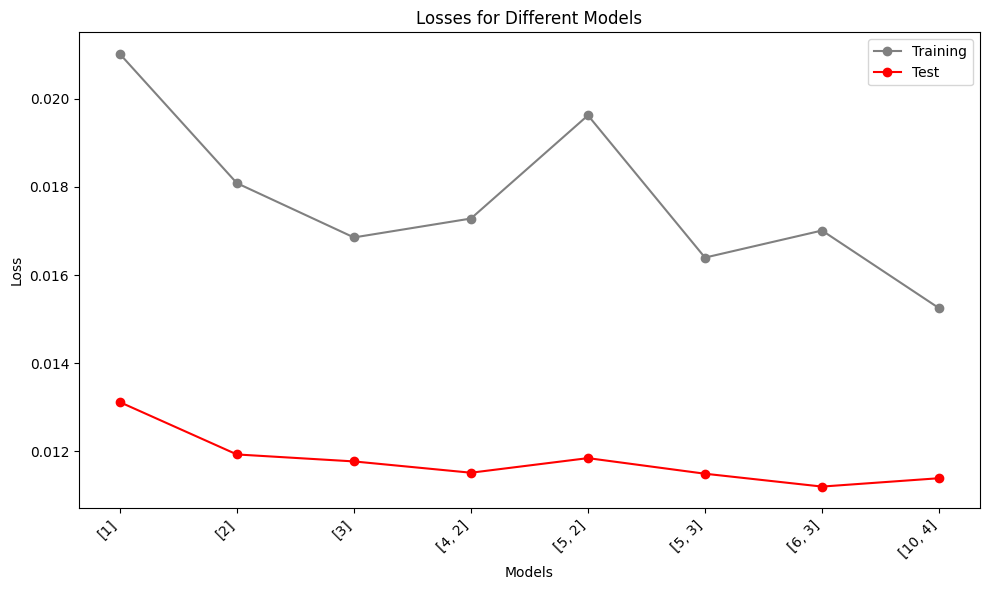

In [35]:
plotting.plot_losses(mean_train_losses, mean_test_losses, all_models)

### Training on the best model and testing in different datasets combination

In [39]:
max_epochs = 2
hidden_size = 3

GPU is available.


In [36]:
# Load the datasets with bottleneck and corridor data

bottleneck_train_val_dataset, bottleneck_test_dataset = pedestrian_dataset.create_dataset(pedestrian_dataset.PedestrianDataType.BOTTLENECK)
corridor_train_val_dataset, corridor_test_dataset = pedestrian_dataset.create_dataset(pedestrian_dataset.PedestrianDataType.CORRIDOR)
all_train_val_dataset, all_test_dataset = pedestrian_dataset.create_dataset(pedestrian_dataset.PedestrianDataType.ALL)

In [42]:
# Combine datasets
bottleneck_dataset = preprocessing.normalize_data(torch.utils.data.ConcatDataset(bottleneck_train_val_dataset))
corridor_dataset = preprocessing.normalize_data(torch.utils.data.ConcatDataset(corridor_train_val_dataset))
all_dataset = preprocessing.normalize_data(torch.utils.data.ConcatDataset(all_train_val_dataset))

# Normalized datasets
normalized_bottleneck_test = DataLoader(preprocessing.normalize_data(bottleneck_test_dataset), batch_size=batch_size, drop_last=True)
normalized_corridor_test = DataLoader(preprocessing.normalize_data(corridor_test_dataset), batch_size=batch_size, drop_last=True)
normalized_all_test = DataLoader(preprocessing.normalize_data(all_test_dataset), batch_size=batch_size, drop_last=False)

#### Initialize the KFold class

In [38]:
k_folds = 2
kfold = KFold(n_splits=k_folds, shuffle=True)

### Initialize different datasets combinations

In [49]:
dataset = preprocessing.normalize_data(torch.utils.data.ConcatDataset(all_train_val_datasets))

# Adjust the experiment datasets wıth different combinations of bottleneck and corridor data
load_dataset = {'B': [bottleneck_dataset, [normalized_bottleneck_test, normalized_corridor_test]],
                'R': [corridor_dataset, [normalized_corridor_test, normalized_bottleneck_test]], 
                'R+B': [all_dataset, [normalized_corridor_test, normalized_bottleneck_test, normalized_all_test]]}

### Train for all 3 models and evaluate on different datasets 

In [59]:
# Initialize the array
mean_test_losses = []

for i in load_dataset:
    test_losses = []
    
    for fold, (train_ids, val_ids) in enumerate(kfold.split(load_dataset[i][0])):  
        print(f"FOLD {fold}")
        print("--------------------------------")

        # Sample elements randomly from a given list of ids, with replacement.
        train_subsampler = torch.utils.data.sampler.WeightedRandomSampler(torch.ones_like(torch.from_numpy(train_ids)), len(train_ids), replacement=True)

        val_subsampler = torch.utils.data.SubsetRandomSampler(val_ids)

        # Define data loaders for training and testing data in this fold
        trainloader = torch.utils.data.DataLoader(
                          load_dataset[i][0], 
                          batch_size=10000, sampler=train_subsampler)  
        valloader = torch.utils.data.DataLoader(
                          load_dataset[i][0],
                          batch_size=10000, sampler=val_subsampler)

        # Init the neural network
        network = pedestrian_net.PedestrianNet(k=k,
                                               hidden_sizes=[3],
                                               learning_rate=learning_rate,
                                               optimizer=optimizer)
        network.to(device)

        # Initialize a trainer
        trainer = pl.Trainer(
            max_epochs=max_epochs,
            devices='auto',
            accelerator='gpu',
            callbacks=[early_stop_callback],
            log_every_n_steps=1,
            enable_checkpointing=True
        )

        # Train the network
        trainer.fit(network, trainloader, valloader)

        # Save the current model (checkpoint)
        checkpoint_name = f"./.name/checkpoints/2023-07-05--dataAll-ep100-it001-fold{fold}.ckpt"
        trainer.save_checkpoint(checkpoint_name)
        
        fold_losses = []
        for test_data in load_dataset[i][1]:
            # Test model
            result = trainer.test(network, dataloaders=test_data)

            # Save test losses
            fold_losses.append(result[0]["TEST_LOSS"])

        
        test_losses.append(fold_losses)
        
        print(test_losses)
        
    print("Training finished for model: ", network)
        
    mean_test_losses.append(np.mean(test_losses, axis=0))
    print("Mean losses: ", mean_test_losses)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type       | Params
-------------------------------------
0 | model | Sequential | 70    
-------------------------------------
70        Trainable params
0         Non-trainable params
70        Total params
0.000     Total estimated model params size (MB)


FOLD 0
--------------------------------
Epoch 0:  50%|█████████████             | 7/14 [00:00<00:00, 15.44it/s, loss=0.0339, v_num=237, train_loss_step=0.0308]
Validation: 0it [00:00, ?it/s]
Testing DataLoader 0:  10%|██████                                                       | 4/40 [00:37<05:36,  9.36s/it]

Epoch 0:  93%|███████████████████████▏ | 13/14 [00:01<00:00,  9.74it/s, loss=0.0339, v_num=237, train_loss_step=0.0308]
Epoch 0: 100%|█| 14/14 [00:01<00:00, 10.09it/s, loss=0.0339, v_num=237, train_loss_step=0.0308, val_loss_step=0.0286, v
Epoch 1:  50%|▌| 7/14 [00:01<00:01,  3.95it/s, loss=0.032, v_num=237, train_loss_step=0.0294, val_loss_step=0.0286, val
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                                                                   | 0/7 [00:00<?, ?it/s]
Epoch 1:  57%|▌| 8/14 [00:01<00:01,  4.19it/s, loss=0.032, v_num=237, train_loss_step=0.0294, val_loss_step=0.0286, val
Epoch 1:  64%|▋| 9/14 [00:01<00:01,  4.53it/s, loss=0.032

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Testing DataLoader 0: 100%|████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 13.64it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        TEST_LOSS          0.027247623383774303
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Testing DataLoader 0: 100%|████████████████████████████████████████████████████████████| 40/40 [00:02<00:00, 18.94it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs



────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        TEST_LOSS           0.06771596935179885
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
[[0.027247623383774303, 0.06771596935179885]]
FOLD 1
--------------------------------


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type       | Params
-------------------------------------
0 | model | Sequential | 70    
-------------------------------------
70        Trainable params
0         Non-trainable params
70        Total params
0.000     Total estimated model params size (MB)


Epoch 0:  50%|█████████████             | 7/14 [00:00<00:00, 18.01it/s, loss=0.0546, v_num=238, train_loss_step=0.0474]
Validation: 0it [00:00, ?it/s]
Epoch 0:  93%|███████████████████████▏ | 13/14 [00:01<00:00, 10.56it/s, loss=0.0546, v_num=238, train_loss_step=0.0474]
Epoch 0: 100%|█| 14/14 [00:01<00:00, 10.97it/s, loss=0.0546, v_num=238, train_loss_step=0.0474, val_loss_step=0.0414, v
Epoch 1:  50%|▌| 7/14 [00:01<00:01,  4.21it/s, loss=0.0479, v_num=238, train_loss_step=0.0377, val_loss_step=0.0414, va
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                                                                   | 0/7 [00:00<?, ?it/s]
Epoch 1:  57%|▌| 8/14 [00:01<00:01,  4.43it/s, loss=0.0479, v_num=238, train_loss_step=0.0377, val_loss_step=0.0414, va
Epoch 1:  64%|▋| 9/14 [00:01<00:01,  4.80it/s, loss=0.0479, v_num=238, train_loss_step=0.0377, val_loss_step=0.0414, va
Epoch 1:  71%|▋| 10/14 [00:01<00:00,  5.16it/s, loss=0.0479, v_num=238, train_loss_step=0.0377, va

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Testing DataLoader 0: 100%|████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 13.30it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        TEST_LOSS           0.03503528529993468
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Testing DataLoader 0: 100%|████████████████████████████████████████████████████████████| 40/40 [00:02<00:00, 18.72it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        TEST_LOSS           0.08343712208457536
──────────────────────────────────────────────────────────────────────────────────────────

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type       | Params
-------------------------------------
0 | model | Sequential | 70    
-------------------------------------
70        Trainable params
0         Non-trainable params
70        Total params
0.000     Total estimated model params size (MB)


Epoch 0:  50%|████████████▌            | 21/42 [00:01<00:01, 12.75it/s, loss=0.0499, v_num=239, train_loss_step=0.0405]
Validation: 0it [00:00, ?it/s]
Epoch 0:  98%|████████████████████████▍| 41/42 [00:03<00:00, 11.15it/s, loss=0.0499, v_num=239, train_loss_step=0.0405]
Epoch 0: 100%|█| 42/42 [00:03<00:00, 11.13it/s, loss=0.0499, v_num=239, train_loss_step=0.0405, val_loss_step=0.038, va
Epoch 1:  50%|▌| 21/42 [00:05<00:05,  4.07it/s, loss=0.0366, v_num=239, train_loss_step=0.0342, val_loss_step=0.038, va
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                                                                  | 0/21 [00:00<?, ?it/s]
Epoch 1:  52%|▌| 22/42 [00:05<00:05,  3.80it/s, loss=0.0366, v_num=239, train_loss_step=0.0342, val_loss_step=0.038, va
Epoch 1:  55%|▌| 23/42 [00:06<00:05,  3.68it/s, loss=0.0366, v_num=239, train_loss_step=0.0342, val_loss_step=0.038, va
Epoch 1:  57%|▌| 24/42 [00:06<00:04,  3.80it/s, loss=0.0366, v_num=239, train_loss_step=0.0342, va

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Testing DataLoader 0: 100%|████████████████████████████████████████████████████████████| 40/40 [00:02<00:00, 18.97it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        TEST_LOSS          0.006589159186067936
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 22.50it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs



────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        TEST_LOSS           0.04072407239043314
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
[[0.006589159186067936, 0.04072407239043314]]
FOLD 1
--------------------------------


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type       | Params
-------------------------------------
0 | model | Sequential | 70    
-------------------------------------
70        Trainable params
0         Non-trainable params
70        Total params
0.000     Total estimated model params size (MB)


Epoch 0:  50%|████████████▌            | 21/42 [00:01<00:01, 11.77it/s, loss=0.0304, v_num=240, train_loss_step=0.0238]
Validation: 0it [00:00, ?it/s]
Epoch 0:  98%|████████████████████████▍| 41/42 [00:03<00:00, 10.68it/s, loss=0.0304, v_num=240, train_loss_step=0.0238]
Epoch 0: 100%|█| 42/42 [00:03<00:00, 10.66it/s, loss=0.0304, v_num=240, train_loss_step=0.0238, val_loss_step=0.0248, v
Epoch 1:  50%|▌| 21/42 [00:05<00:05,  3.76it/s, loss=0.0234, v_num=240, train_loss_step=0.0243, val_loss_step=0.0248, v
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                                                                  | 0/21 [00:00<?, ?it/s]
Epoch 1:  52%|▌| 22/42 [00:06<00:05,  3.53it/s, loss=0.0234, v_num=240, train_loss_step=0.0243, val_loss_step=0.0248, v
Epoch 1:  55%|▌| 23/42 [00:06<00:05,  3.65it/s, loss=0.0234, v_num=240, train_loss_step=0.0243, val_loss_step=0.0248, v
Epoch 1:  57%|▌| 24/42 [00:06<00:04,  3.77it/s, loss=0.0234, v_num=240, train_loss_step=0.0243, va

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Testing DataLoader 0: 100%|████████████████████████████████████████████████████████████| 40/40 [00:02<00:00, 18.81it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        TEST_LOSS          0.013957332305229088
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Testing DataLoader 0: 100%|████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 12.90it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs



────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        TEST_LOSS          0.020708070307097075
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
[[0.006589159186067936, 0.04072407239043314], [0.013957332305229088, 0.020708070307097075]]
Training finished for model:  PedestrianNet(
  (model): Sequential(
    (0): Linear(in_features=21, out_features=3, bias=True)
    (1): ReLU()
    (2): Linear(in_features=3, out_features=1, bias=True)
  )
)
Mean losses:  [array([0.03114145, 0.07557655]), array([0.01027325, 0.03071607])]
FOLD 0
--------------------------------


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type       | Params
-------------------------------------
0 | model | Sequential | 70    
-------------------------------------
70        Trainable params
0         Non-trainable params
70        Total params
0.000     Total estimated model params size (MB)


Epoch 0:  50%|████████████▌            | 27/54 [00:02<00:02, 12.55it/s, loss=0.0184, v_num=241, train_loss_step=0.0185]
Validation: 0it [00:00, ?it/s]
Epoch 0:  98%|████████████████████████▌| 53/54 [00:04<00:00, 11.29it/s, loss=0.0184, v_num=241, train_loss_step=0.0185]
Epoch 0: 100%|█| 54/54 [00:04<00:00, 11.18it/s, loss=0.0184, v_num=241, train_loss_step=0.0185, val_loss_step=0.0184, v
Epoch 1:  50%|▌| 27/54 [00:06<00:06,  3.93it/s, loss=0.0183, v_num=241, train_loss_step=0.0184, val_loss_step=0.0184, v
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                                                                  | 0/27 [00:01<?, ?it/s]
Epoch 1:  52%|▌| 28/54 [00:07<00:07,  3.54it/s, loss=0.0183, v_num=241, train_loss_step=0.0184, val_loss_step=0.0184, v
Epoch 1:  54%|▌| 29/54 [00:07<00:06,  3.63it/s, loss=0.0183, v_num=241, train_loss_step=0.0184, val_loss_step=0.0184, v
Epoch 1:  56%|▌| 30/54 [00:08<00:06,  3.73it/s, loss=0.0183, v_num=241, train_loss_step=0.0184, va

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Testing DataLoader 0: 100%|████████████████████████████████████████████████████████████| 40/40 [00:02<00:00, 19.04it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        TEST_LOSS          0.014772966277924385
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Testing DataLoader 0: 100%|████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 13.48it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        TEST_LOSS          0.019647580371537462
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Testing DataLoader 0: 100%|████████████████████████████████████████████████████████████| 54/54 [00:02<00:00, 19.30it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs



────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        TEST_LOSS          0.013213418952331428
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
[[0.014772966277924385, 0.019647580371537462, 0.013213418952331428]]
FOLD 1
--------------------------------


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type       | Params
-------------------------------------
0 | model | Sequential | 70    
-------------------------------------
70        Trainable params
0         Non-trainable params
70        Total params
0.000     Total estimated model params size (MB)


Epoch 0:  50%|█████████████             | 27/54 [00:01<00:01, 15.74it/s, loss=0.0585, v_num=242, train_loss_step=0.042]
Validation: 0it [00:00, ?it/s]
Epoch 0:  98%|█████████████████████████▌| 53/54 [00:04<00:00, 11.39it/s, loss=0.0585, v_num=242, train_loss_step=0.042]
Epoch 0: 100%|█| 54/54 [00:04<00:00, 11.28it/s, loss=0.0585, v_num=242, train_loss_step=0.042, val_loss_step=0.0437, va
Epoch 1:  50%|▌| 27/54 [00:06<00:06,  3.99it/s, loss=0.0235, v_num=242, train_loss_step=0.0215, val_loss_step=0.0437, v
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                                                                  | 0/27 [00:00<?, ?it/s]
Epoch 1:  52%|▌| 28/54 [00:07<00:06,  3.75it/s, loss=0.0235, v_num=242, train_loss_step=0.0215, val_loss_step=0.0437, v
Epoch 1:  54%|▌| 29/54 [00:07<00:06,  3.85it/s, loss=0.0235, v_num=242, train_loss_step=0.0215, val_loss_step=0.0437, v
Epoch 1:  56%|▌| 30/54 [00:07<00:06,  3.93it/s, loss=0.0235, v_num=242, train_loss_step=0.0215, va

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Testing DataLoader 0: 100%|████████████████████████████████████████████████████████████| 40/40 [00:02<00:00, 18.95it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        TEST_LOSS          0.014810185476611002
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Testing DataLoader 0: 100%|████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 19.26it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        TEST_LOSS           0.02449428127948612
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Testing DataLoader 0: 100%|████████████████████████████████████████████████████████████| 54/54 [00:02<00:00, 18.69it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        TEST_LOSS          0.013645587189796108
──────────────────────────────────────────────────────────────────────────────────────────

In [46]:
mean_test_losses

[1.041371314510905,
 0.11447470647478761,
 0.18099656133586195,
 0.3120735044268826,
 0.034705807133809816,
 0.1344385326931064,
 0.06719317004159159]